# **Initialization**

In [ ]:
#import necessary packages
import pandas as pd
import numpy as np
import math
import geopy.distance
import shapely
import pickle
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.ticker
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
import gc
import os

from sklearn.model_selection import train_test_split
from scipy.stats import binned_statistic_2d
from scipy import stats
from nltk import ngrams
from shapely.geometry import Point

In [ ]:
#install packages not standard included in Google colab
!pip install git+https://github.com/dmort27/panphon
!pip install geoplot
!pip install levenshtein
!pip install unidecode
!pip install alphashape

import panphon
import geopandas
import geoplot
import seaborn as sns
import Levenshtein
import alphashape
from unidecode import unidecode

  Cloning https://github.com/dmort27/panphon to /tmp/pip-req-build-_jjencgh
  Running command git clone --filter=blob:none --quiet https://github.com/dmort27/panphon /tmp/pip-req-build-_jjencgh
  Resolved https://github.com/dmort27/panphon to commit 6acd3833743a49e63941a0b740ee69eae1dafc1c
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for panphon: filename=panphon-0.20.0-py2.py3-none-any.whl size=73251 sha256=92d2a12bb8f16e77fc02ce5569f4c3c649bd33d14303371654f857ea9b53b734
  Stored in directory: /tmp/pip-ephem-wheel-cache-nz3ip2b9/wheels/65/66/a4/bde5c32aa1f60bc2641fb5866b31e4c314099e21f1ed13a8f9
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10745 sha256=df04768eda8d5ddaaffa1ea5c350f053d2bd1c187e5ef946bb81ce5778f0ba24
  Stored in directory: /root/.cache/pip/wheels/9c/ea/66/8e45247b09052a933eb1a680b7c64802298faba58aac9b346b
Successfully built panphon unicodecsv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#the code was written in Keras 2.15.0 and newer versions are incompatible, this forces the install of the latest compatible Keras version for this code
!pip uninstall keras -y
!pip install keras==2.15.0

import keras
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras import layers

Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.0 MB/s eta 0:00:00


In [ ]:
#similarly, forces the install of the latest compatible Keras-NLP for this code
!pip install keras-nlp==0.4.1 --upgrade -q --use-deprecated=legacy-resolver --no-deps
import keras_nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 kB 11.4 MB/s eta 0:00:00


**Load WLD_preprocessed.csv from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Thesis/GitHub/datasets/WLD_preprocessed.csv')
#df_dutch_to_ipa = pd.read_csv('/content/drive/MyDrive/Thesis/dutch_to_IPA.csv', header=None)

#remove duplicate rows
df = df.drop_duplicates()
#df = df.reset_index(drop=True)

Mounted at /content/drive


**Fixed constants**

In [ ]:
#min and max values for rescaling between normalized coordinates and coordinates (y,x) -> (lat,lon)
global min_longitude
min_longitude = 4.7040582
global max_longitude
max_longitude = 6.1785077
global min_latitude
min_latitude = 50.59324
global max_latitude
max_latitude = 51.9320994

**Auxiliary functions**

In [ ]:
#convert (y,x) to (lat, lon)
def normalized_to_coordinates(y,x):
  longitude = x * (max_longitude - min_longitude) + min_longitude
  latitude = y * (max_latitude - min_latitude) + min_latitude
  return(latitude, longitude)

#convert (lat, lon) to (y,x)
def coordinates_to_normalized(lat, lon):
  y = (lat - min_latitude) / (max_latitude - min_latitude)
  x = (lon - min_longitude) / (max_longitude - min_longitude)
  return(y,x)

#calculate exact geodesic distances between lists of normalized (y, x)
def normalized_distance(coordslist1, coordslist2):
  distances = []
  for i in range(len(coordslist1)):
    y1 = coordslist1[i][0]
    x1 = coordslist1[i][1]
    y2 = coordslist2[i][0]
    x2 = coordslist2[i][1]
    latitude1, longitude1 = normalized_to_coordinates(y1,x1)
    latitude2, longitude2 = normalized_to_coordinates(y2,x2)
    distances.append(geopy.distance.geodesic((latitude1, longitude1), (latitude2, longitude2)).km)
  return(distances)

#calculate exact geodesic distances between lists of normalized (y,x) and return latitudinal and longitudinal distances separately
def normalized_distance_axes(coordslist1, coordslist2):
  distances_longitude = []
  distances_latitude = []
  for i in range(len(coordslist1)):
    y1 = coordslist1[i][0]
    x1 = coordslist1[i][1]
    y2 = coordslist2[i][0]
    x2 = coordslist2[i][1]
    latitude1, longitude1 = normalized_to_coordinates(y1,x1)
    latitude2, longitude2 = normalized_to_coordinates(y2,x2)
    distances_longitude.append(geopy.distance.geodesic((0, longitude1), (0, longitude2)).km)
    distances_latitude.append(geopy.distance.geodesic((latitude1, 0), (latitude2, 0)).km)
  return(distances_latitude, distances_longitude)

#auxiliary function for finding floats in list
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return(idx-1)
    else:
        return(idx)

#character based F1-metric for machine translation
def chrF(word1, word2, n): #cite Popovic, 2017 for this! beta=1 here
  #word1: reference/target word2: hypothesis/translation
  ngrams_iter1 = ngrams(word1, n)
  ngrams1 = [''.join(ngram) for ngram in ngrams_iter1]
  ngrams_iter2 = ngrams(word2, n)
  ngrams2 = [''.join(ngram) for ngram in ngrams_iter2]
  #precision
  count = 0
  for ngram in ngrams2:
    if ngram in ngrams1:
      count += 1
  if len(ngrams2) == 0:
    chrP = 0
  else:
    chrP = count / len(ngrams2)
  #recall
  count = 0
  for ngram in ngrams1:
    if ngram in ngrams2:
      count += 1
  if len(ngrams1) == 0:
    chrR = 0
  else:
    chrR = count / len(ngrams1)
  if (chrP + chrR) == 0:
    return(0)
  chrF = 2*chrP * chrR / (chrP + chrR)
  return(chrF)

# **Cleaning: sentence splitting + custom cleaning rules**

**Cleaning: remove noisy data from Limburgish words (but does not split them)**

In [ ]:
#only the first 118 most frequent chararacters are used in over 100 words, rest is assumed to be noise, these are:
whitelisted_characters = [' ', '!', '"', '#', '&', '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5',
                          '6', ':', ';', '?', '[', ']', '^', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                          'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '}', '~',
                          'à', 'á', 'â', 'ä', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø',
                          'ù', 'ú', 'û', 'ü', 'ā', 'ē', 'ę', 'ī', 'ŋ', 'ō', 'ő', 'š', 'ū', 'ű', 'ž', 'ǝ', 'ǫ', 'ǭ',
                          'ȳ', 'ə', 'ɛ', 'ʔ', '˂', '˃', '˙', '˱', '˲', '̃', '̄', '̆', '̇', '̋', '̌', '̜', '̝', '̞', '̣', '̥',
                          '̯', '͂', 'ͅ', 'ẽ', '’', '‧', '⁄', '∂']

def whitelistCompliant(word):
  for character in word:
    if not (character in whitelisted_characters):
      return(False)
  return(True)


dialect_list = df['dialectopgave'].values
cleaned_dialect_list = []
idx = []
for i, word in enumerate(dialect_list):
  try:
    word = word.lower() #normalize to lower case
    if whitelistCompliant(word) == False: #these characters are so noisy that the entry is assumed to be useless
      continue
    if word[-1] == '!': #sometimes added for exclamation
      word = word[:-1]
    if '!' in word: #can be safely ignored, noise
      word = word.replace('!', '')
    if '"' in word: #transcription error
      word = word.replace('"', 'ø')
    if '#' in word: #unicode error
      word = word.replace('&#x0304', '¯')
    if '&' in word: #sometimes used as conjunction
      word = word.replace('&', '')
    if '(sic)' in word: #used if uncertain
      word = word.replace('(sic)', '')
    if '(mv.)' in word: #not necessary for our purpose
      word = word.replace('(mv.)', '')
    if '(m.)' in word: #not necessary for our purpose
      word = word.replace('(m.)', '')
    if '(v.)' in word:
      word = word.replace('(v.)', '')
    if '(.)' in word:
      word = word.replace('(.)', '')
    if '(gew.uitspr.)' in word:
      word = word.replace('(gew.uitspr.)', '')
    if '(' or ')' in word: #remove remaining, usually optional words or sounds
      word = word.replace('(', '').replace(')', '')
    if word[-1] == '*':
      word = word.replace('*', '')
    if '*' in word: #remainder are noisy entries, remove
      continue
    if ',' in word:
      word = word.replace(',', '') #used for formatting alternatives or sentences
    if '/' == word: #nonsensical entries
      continue
    if '/' in word: #used for giving alternatives, replace with space to split words
      word = word.replace('/', ' ')
    #remove all numbers
    word = word.replace('0', '').replace('1', '').replace('2', '').replace('3', '').replace('4', '')
    word = word.replace('5', '').replace('6', '').replace('7', '').replace('8', '').replace('9', '')
    if ';' in word: #too difficult to resolve, only 112 entries
      continue
    if '?' in word: #mostly used for questions, sometimes for missing character (rare)
      word = word.replace('?', '')
    if '[' in word and ']' in word: #used to give semantic meaning in Dutch, useless for our purposes
      word = word.replace(word[word.index('[') : word.index(']')+1], '')
    if '[' in word or ']' in word:
      word = word.replace('[', '').replace(']', '')
    if '^' in word: #too noisy, remove
      continue
    if '`t' in word: #normalize spelling to unrounded ə
      word = word.replace('`t', 'ət')
    if '`n' in word:
      word = word.replace('`n', 'ən')
    if word[0] == '`': #transcription errors
      word = word[1:]
    if word[-1] == '`' :
      word = word[:-1]
    if '{' in word or '}'  in word:
      word = word.replace('{', '').replace('}', '')
    if '~' in word: #nonsensical symbol, only used in 196 entries
      word = word.replace('~', '')
    if '->' in word: #not useful for our purposes
      word = word.replace('->', '')
    if '˂' in word or '˃' in word:
      word = word.replace('˂', '').replace('˃', '')
    if '’n' in word: #normalize spelling to unrounded ə
      word = word.replace('’n', 'ən')
    if '’t' in word:
      word = word.replace('’t', 'ət')
    if 'd’r' in word:
      word = word.replace('d’r', 'dər')
    if '’' in word: #rest of ’ is superfluous
      word = word.replace('’', '')
    if '⁄t' in word: #normalize spelling to unrounded ə
      word = word.replace('⁄t', 'ət')
    if '⁄n' in word:
      word = word.replace('⁄n', 'ən')
    if '⁄m' in word:
      word = word.replace('⁄m', 'əm')
    if '⁄' in word: #remained is too noisy, removes 2759 entries but smarter approach is possible
      continue
    if '∂' in word: #too noisy, removes 189 entries
      continue
    if 'g' in word: #if g, replace by phonetic x (persistent mistake in WLD that otherwise limits our dataset too much)
      idxs = [j for j, char in enumerate(word) if char == 'g']
      idxs2 = []
      for index in idxs:
        if word[index:index+2] == 'gk' or word[index-1:index+1] == 'kg' or word[index:index+2] == 'gg' or word[index-1:index+1] == 'gg' or word[index-1:index+1] == 'ng':
          continue
        else:
          idxs2.append(index)
      for index in idxs2:
        word = word[:index] + 'x' + word[index+1:]
    if word == ' ' or word ==  '':
      continue
    cleaned_dialect_list.append(word)
    idx.append(i)
  except Exception as e:
    continue

df2 = df.iloc[idx].copy(deep=True)
df2['dialectopgave'] = cleaned_dialect_list
df = df2.copy(deep=True).reset_index(drop=True)

**Preprocessing: split sentences in WLD to individual words**

In [ ]:
#tries to match two sentences word-by-word and returns tuples of matches
def SplitAndMatch(sentence1, sentence2):
  sentence1_normalized = unidecode(sentence1).split()
  sentence2_normalized = unidecode(sentence2).split()
  sentence1_temp = sentence1.split()
  sentence2_temp = sentence2.split()

  distances2 = []
  #match using levenshtein distances
  matches = []
  for i, word1 in enumerate(sentence1_normalized):
    distances = []
    for word2 in sentence2_normalized:
      distances.append(Levenshtein.ratio(word1, word2))
    if not distances: #finished
      continue
    idx = np.argmax(distances)
    if distances[idx] <= 0.4:
      continue
    distances2.append(distances[idx])
    matches.append((sentence1_temp[i], sentence2_temp[idx]))
    sentence2_normalized.pop(idx)
    sentence2_temp.pop(idx)
  if not matches:
    return(False)
  return(matches)

In [ ]:
#splits entries and tries to match Limburgish (dialectopgave) and Dutch (trefwoord) word-by-word using Levenshtein distances
#this increases dataset size
dialect_list = df['dialectopgave'].to_numpy()
trefwoorden = df['trefwoord'].to_numpy()

matched = []
success_idx = []
split_list = []
for i in range(len(dialect_list)):
  output = SplitAndMatch(trefwoorden[i], dialect_list[i])
  if output != False: #if split successful
    split_list.append(output)
    matched.append(True)
    success_idx.append(i)
  else:
    matched.append(False)
df2 = df.copy(deep=True)
df2['matched'] = matched
df2_numpy = df2.to_numpy()

to_be_concatenated = []
for i, idx in enumerate(success_idx):
  split_array = np.array(split_list[i])
  temp_row = df2_numpy[idx]
  temp_row = np.repeat([temp_row], len(split_list[i]), axis=0)
  temp_row[:,3] = split_array[:,0]
  temp_row[:,4] = split_array[:,1]
  for j, row in enumerate(temp_row):
    to_be_concatenated.append(row)

df_to_be_concatenated = pd.DataFrame(to_be_concatenated, columns=df2.columns)
df_drop = df2.drop(success_idx)
df_temp = pd.concat([df_drop, df_to_be_concatenated])
df = df_temp.copy(deep=True)
df = df.reset_index(drop=True)

In [ ]:
#deletes WLD entries where the trefwoord/Dutch word is too noisy (either as a result of incorrect splitting or because the entire entry is noisy)
new_trefwoorden = []
idx_delete = []
for i, word in enumerate(df['trefwoord'].values):
  word = word.replace('(', '').replace(')', '').replace(',', '').replace('{', '').replace('}', '') #sometimes used, can be deleted without issue for normalization
  if len(word) == 0:
    idx_delete.append(i)
    continue
  if word[-1] == '-' or word[-1] == '?' or word[-1] == '!' or word[-1] == ':': #sometimes these characters remain after splitting
    word = word[:-1]
  if '.' in word: #deletes all language indications (e.g. 'fr.') and PoS descriptions
    idx_delete.append(i)
    continue
  if word == '`s' or word == '-' or word == '~' or word == '`t': #useless words as a result from splitting
    idx_delete.append(i)
    continue
  if '[' in word or ']' in word or '/' in word or '<' in word or '>' in word: #useless words
    idx_delete.append(i)
    continue
  new_trefwoorden.append(word)

df2 = df.copy(deep=True)
df2 = df2.drop(idx_delete)
df2['trefwoord'] = new_trefwoorden
df = df2.copy(deep=True)

# **Initialization: Cartography and advanced evaluation**

**A more advanced evaluation of the network (not just Euclidian distances)**

In [ ]:
#numeric evaluation
def AdvancedEvaluation(Y_pred, Y):
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

  #Geodesic distances
  errors = normalized_distance(Y_pred, Y)
  axes[0].hist(errors, bins='auto')
  axes[0].set_title('Errors (km)')

  #Latitudinal and longitudinal geodesic distances separately
  distances_latitude, distances_longitude = normalized_distance_axes(Y_pred, Y)
  axes[1].hist(distances_latitude, bins='auto')
  axes[2].hist(distances_longitude, bins='auto')
  axes[1].set_title('Latitudinal errors (km)')
  axes[2].set_title('Longitudinal errors (km)')
  fig.tight_layout()
  plt.show()

  print('Mean distance: {}. Sd distance: {}'.format(np.mean(errors), np.std(errors)))
  print('Mean latitude: {}. Sd latitude: {}'.format(np.mean(distances_latitude), np.std(distances_latitude)))
  print('Mean longitude: {}. Sd longitude: {}'.format(np.mean(distances_longitude), np.std(distances_longitude)))

In [ ]:
#graphic evaluation

#load province geojson
gdf2 = geopandas.read_file("/content/drive/MyDrive/Thesis/NUTS_RG_01M_2021_3035.geojson")
BE_limburg = gdf2[gdf2['id'] == 'BE22']
NL_limburg = gdf2[gdf2['id'] == 'NL42']
BE_liege = gdf2[gdf2['id'] == 'BE33']
region = pd.concat([BE_limburg, NL_limburg, BE_liege])
region_buffer = region.buffer(20000)
region = region.to_crs('EPSG:4326')
region_buffer = region_buffer.to_crs('EPSG:4326')

In [ ]:
#load isoglosses
isoglosses = geopandas.read_file("/content/drive/MyDrive/Thesis/Isoglossen_Limburgs2.geojson")
getelijn = geopandas.read_file("/content/drive/MyDrive/Thesis/Getelijn.geojson")

#convert to correct CRS
isoglosses2 = isoglosses.to_crs('EPSG:4326')
getelijn = getelijn.to_crs('EPSG:4326')

isoglosses2 = isoglosses2.dissolve(by='name')
getelijn = getelijn.dissolve(by='name')

for i, isogloss in enumerate(isoglosses2['geometry']):
  if isogloss.geom_type == 'MultiLineString':
    isoglosses2['geometry'][i] = shapely.ops.linemerge(isogloss)

for i, isogloss in enumerate(getelijn['geometry']):
  if isogloss.geom_type == 'MultiLineString':
    getelijn['geometry'][i] = shapely.ops.linemerge(isogloss)

isoglosses2_merged = isoglosses2.dissolve()

In [ ]:
#global axes range
xlims = [4.8, 6.35]
ylims = [50.55, 51.8]

#plot place names
def PlaceNames(fig, ax):
  places = [('Grote-Brogel', 51.1556381, 5.5081262), ('Hasselt', 50.9303735, 5.3378043), ('Maastricht', 50.8512438, 5.6909768),
            ('Roermond', 51.1933903, 5.9882649), ('Panningen', 51.3287995, 5.9819406), ('Venlo', 51.39244885, 6.1511724144122955),
            ('Venray', 51.5082754, 5.958901096612693), ('Heerlen', 50.8775239, 5.981506585454879), ('Kerkrade', 50.874908899999994, 6.0593852849074565),
            ('Tongeren', 50.7806267, 5.4639172), ('St. Truiden', 50.82694775, 5.203424911603399), ('Sittard', 50.9974235, 5.8666627),
            ('Bree', 51.1386239, 5.622980505851396), ('Tessenderlo', 51.0681628, 5.0893974), ('Lommel', 51.2305657, 5.3076895), ('Maaseik', 51.0947181, 5.791733),
            ('Eupen', 50.6305665, 6.0312717), ('Aubel', 50.7041498, 5.8585553), ('Kelmis', 50.7154957, 6.013341), ('Weert', 51.235582949999994, 5.705079711646853),
            ('Verviers', 50.59324, 5.867828), ('Gennep', 51.6950839, 5.9734549), ('Waasmont', 50.7287476, 5.065336)]

  for i in range(len(places)):
    ax.scatter(places[i][2], places[i][1], s=7, color='black', zorder=5)
    ax.annotate(places[i][0], (places[i][2], places[i][1] + 0.005), size=8, ha='center', va='bottom', path_effects=[pe.withStroke(linewidth=1, foreground="white")], zorder=5)
  ax.set_facecolor('#FAFAFA')

#plot fewer place names (small maps)
def PlaceNamesLight(fig, ax):
  places = [('Hasselt', 50.9303735, 5.3378043), ('Maastricht', 50.8512438, 5.6909768), ('Venlo', 51.39244885, 6.1511724144122955),
            ('Kerkrade', 50.874908899999994, 6.0593852849074565), ('Bree', 51.1386239, 5.622980505851396),
            ('St. Truiden', 50.82694775, 5.203424911603399), ('Lommel', 51.2305657, 5.3076895), ('Eupen', 50.6305665, 6.0312717),
            ('Gennep', 51.6950839, 5.9734549), ('Panningen', 51.3287995, 5.9819406)]

  for i in range(len(places)):
    ax.scatter(places[i][2], places[i][1], s=7, color='black', zorder=5)
    ax.annotate(places[i][0], (places[i][2], places[i][1] + 0.005), size=8, ha='center', va='bottom', path_effects=[pe.withStroke(linewidth=1, foreground="white")], zorder=5)
  ax.set_facecolor('#FAFAFA')

#map coordinates into triangulation plot using geopandas where 'values' are the heatmap values
def Map(fig, ax, coordinates, values, title):
  coordinates = np.array(coordinates)
  latitudes, longitudes = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])
  #gdf_coordinates = geopandas.GeoDataFrame(values, geometry = geopandas.points_from_xy(longitudes, latitudes))
  #gdf_coordinates.crs = "EPSG:4326"

  #triang = tri.Triangulation(longitudes, latitudes)
  tpc = ax.tripcolor(longitudes, latitudes, values, shading='flat', cmap='hot_r')

  region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
  ax.set_title(title)
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)
  cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
  fig.colorbar(tpc, cax=cax)
  PlaceNames(fig, ax)

#map coordinates into heatmap-colored scatter plot using geopandas where 'values' are the heatmap values
def Map2(fig, ax, coordinates, values, title):
  coordinates = np.array(coordinates)
  latitudes, longitudes = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])
  #gdf_coordinates = geopandas.GeoDataFrame(values, geometry = geopandas.points_from_xy(longitudes, latitudes))
  #gdf_coordinates.crs = "EPSG:4326"

  sc = ax.scatter(longitudes, latitudes, c=values, s=5, cmap='hot_r')

  region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
  ax.set_title(title)
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)
  cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
  fig.colorbar(sc, cax=cax)
  PlaceNames(fig, ax)

#map coordinates into 2D histogram using geopandas where 'values' are the heatmap values
def MapHist(fig, ax, coordinates, values, title):
  coordinates = np.array(coordinates)
  latitudes, longitudes = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])
  #gdf_coordinates = geopandas.GeoDataFrame(values, geometry = geopandas.points_from_xy(longitudes, latitudes))
  #gdf_coordinates.crs = "EPSG:4326"

  hist = ax.hist2d(longitudes, latitudes, bins=15, weights=values, cmap='hot_r', alpha=0.8)

  region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
  ax.set_title(title)
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)
  cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
  fig.colorbar(hist[3], cax=cax)
  PlaceNames(fig, ax)

#map coordinates into normalized 2D histogram using geopandas where 'values' are the heatmap values
def MapHistAverage(fig, ax, coordinates, values, title):
  coordinates = np.array(coordinates)
  latitudes, longitudes = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])
  #gdf_coordinates = geopandas.GeoDataFrame(values, geometry = geopandas.points_from_xy(longitudes, latitudes))
  #gdf_coordinates.crs = "EPSG:4326"

  H, xedges, yedges = np.histogram2d(longitudes, latitudes, bins = 15, weights = values)
  H_counts, xedges, yedges = np.histogram2d(longitudes, latitudes, bins = 15)
  H = H/H_counts

  plt.imshow(H.T, origin='lower',  cmap='hot_r', alpha=0.8, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
  plt.colorbar()

  region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
  ax.set_title(title)
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)
  cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
  PlaceNames(fig, ax)


#map coordinates into contour plot using geopandas where 'values' are the heatmap values
def MapContour(fig, ax, coordinates, values, title, factor):
  coordinates = np.array(coordinates)
  latitudes, longitudes = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])
  #gdf_coordinates = geopandas.GeoDataFrame(values, geometry = geopandas.points_from_xy(longitudes, latitudes))
  #gdf_coordinates.crs = "EPSG:4326"

  kernel = stats.gaussian_kde(np.array([longitudes, latitudes]), weights=values, bw_method=factor)
  xs, ys = np.mgrid[xlims[0]:xlims[1]:200j, ylims[0]:ylims[1]:200j]
  zs = kernel(np.array([xs.ravel(), ys.ravel()])).reshape(xs.shape)#*np.sum(values) / len(xs)

  cfset = ax.contourf(xs, ys, zs, cmap='hot_r', alpha=0.8)
  cset = ax.contour(xs, ys, zs, colors='k', linewidths = 0.7)

  #nullcline
  #nullcline = ax.contour(xs, ys, zs, levels=[100], linestyles='dashdot')

  fmt = matplotlib.ticker.LogFormatterSciNotation()
  fmt.create_dummy_axis()
  ax.clabel(cset, inline=1, fontsize=6, fmt=fmt)

  region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
  ax.set_title(title)
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)
  cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
  fig.colorbar(cfset, cax=cax)
  PlaceNames(fig, ax)

#map coordinates using geopandas
def MapScatter(fig, ax, coordinates, title):
  coordinates = np.array(coordinates)
  latitudes, longitudes = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])
  #gdf_coordinates = geopandas.GeoDataFrame(values, geometry = geopandas.points_from_xy(longitudes, latitudes))
  #gdf_coordinates.crs = "EPSG:4326"

  ax.scatter(longitudes, latitudes, s=2)
  region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
  ax.set_title(title)
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)
  PlaceNames(fig, ax)

In [ ]:
  #group entries and count per kloekecode
  df2 = df.copy()
  df2['index'] = np.arange(0, df.shape[0])
  WLD_grouped = df2.groupby(['Kloekecode', 'y', 'x'], as_index=False).count()

In [ ]:
#plots errors in km
def MapErrors(y, y_pred):
  errors = normalized_distance(y, y_pred)
  coordinates = list(zip(y[:,0], y[:,1]))
  df_visualize = pd.DataFrame({'coordinate' : coordinates, 'errors' : errors})
  df_visualize = df_visualize.groupby('coordinate').mean().reset_index()
  coordinates = np.array(df_visualize['coordinate'].tolist())

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
  plt.subplots_adjust(right=2)

  factor = 0.3
  Map(fig, axes[0], coordinates, df_visualize['errors'].tolist(), 'Triangulation')
  MapContour(fig, axes[1], coordinates, df_visualize['errors'].tolist(), 'Gaussian kernel density', factor)
  MapHist(fig, axes[2], coordinates, df_visualize['errors'].tolist(), 'Histogram')
  fig.suptitle('Distribution of errors (km)', fontsize=18)
  plt.show()

#plots errors in km, weighted by data density
def MapErrors_weighted(y, y_pred):
  errors = normalized_distance(y, y_pred)
  coordinates = list(zip(y[:,0], y[:,1]))
  df_visualize = pd.DataFrame({'coordinate' : coordinates, 'errors' : errors})
  df_visualize = df_visualize.groupby('coordinate').mean().reset_index()
  coordinates = np.array(df_visualize['coordinate'].tolist())
  values = df_visualize['errors'].tolist()

  factor = 0.3

  #Weight coordinates by percentage of total data they represent
  values1 = []
  weights = WLD_grouped['index'].values / np.sum(WLD_grouped['index'].values)
  for i in range(len(values)):
    idx = find_nearest(WLD_grouped['y'], y[i,0])
    weight = weights[idx]
    values1.append(values[i] * weight)

  #Weight coordinates by gaussian kernel to approximate average density per coordinate
  kernel = stats.gaussian_kde([WLD_grouped['y'].values, WLD_grouped['x'].values], weights=WLD_grouped['index'].values, bw_method=factor)
  values2 = np.multiply(values, kernel([coordinates[:,0], coordinates[:,1]]))

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
  plt.subplots_adjust(right=2)
  Map(fig, axes[0], coordinates, values1, 'Triangulation')
  MapContour(fig, axes[1], coordinates, values1, 'Gaussian kernel density', factor)
  MapHist(fig, axes[2], coordinates, values1, 'Histogram')
  fig.suptitle('Distribution of errors, weighted by representativeness of data', fontsize=18)
  plt.show()

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
  plt.subplots_adjust(right=2)
  Map(fig, axes[0], coordinates, values2, 'Triangulation')
  MapContour(fig, axes[1], coordinates, values2, 'Gaussian kernel density', factor)
  MapHist(fig, axes[2], coordinates, values2, 'Histogram')
  fig.suptitle('Distribution of errors, Gaussian weighted by representativeness of data', fontsize=18)
  plt.show()

#plots errors in km by axes
def MapErrorsAxes(y, y_pred):
  distances_latitude, distances_longitude = normalized_distance_axes(y, y_pred)
  coordinates = list(zip(y[:,0], y[:,1]))
  df_visualize = pd.DataFrame({'coordinate' : coordinates, 'errors_lon' : distances_longitude, 'errors_lat' : distances_latitude})
  df_visualize = df_visualize.groupby('coordinate').mean().reset_index()
  coordinates = np.array(df_visualize['coordinate'].tolist())

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
  plt.subplots_adjust(right=2)
  factor = 0.3
  Map(fig, axes[0], coordinates, df_visualize['errors_lat'].tolist(), 'Triangulation')
  MapContour(fig, axes[1], coordinates, df_visualize['errors_lat'].tolist(), 'Gaussian kernel density', factor)
  MapHist(fig, axes[2], coordinates, df_visualize['errors_lat'].tolist(), 'Histogram')
  fig.suptitle('Distribution of latitudinal errors (km)', fontsize=18)
  plt.show()

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
  plt.subplots_adjust(right=2)
  factor = 0.3
  Map(fig, axes[0], coordinates, df_visualize['errors_lon'].tolist(), 'Triangulation')
  MapContour(fig, axes[1], coordinates, df_visualize['errors_lon'].tolist(), 'Gaussian kernel density', factor)
  MapHist(fig, axes[2], coordinates, df_visualize['errors_lon'].tolist(), 'Histogram')
  fig.suptitle('Distribution of longitudinal errors (km)', fontsize=18)
  plt.show()

#plots errors in km by axes, weighted by data density
def MapErrorsAxes_weighted(y, y_pred):
  distances_latitude, distances_longitude = normalized_distance_axes(y, y_pred)
  for i in range(2):
    if i == 0:
      errors = distances_latitude
    else:
      errors = distances_longitude
    coordinates = list(zip(y[:,0], y[:,1]))
    df_visualize = pd.DataFrame({'coordinate' : coordinates, 'errors' : errors})
    df_visualize = df_visualize.groupby('coordinate').mean().reset_index()
    coordinates = np.array(df_visualize['coordinate'].tolist())
    values = df_visualize['errors'].tolist()

    factor = 0.3

    #Weight coordinates by percentage of total data they represent
    values1 = []
    weights = WLD_grouped['index'].values / np.sum(WLD_grouped['index'].values)
    for j in range(len(values)):
      idx = find_nearest(WLD_grouped['y'], y[j,0])
      weight = weights[idx]
      values1.append(values[j] * weight)

    #Weight coordinates by gaussian kernel to approximate average density per coordinate
    kernel = stats.gaussian_kde([WLD_grouped['y'].values, WLD_grouped['x'].values], weights=WLD_grouped['index'].values, bw_method=factor)
    values2 = np.multiply(values, kernel([coordinates[:,0], coordinates[:,1]]))

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
    plt.subplots_adjust(right=2)
    Map(fig, axes[0], coordinates, values1, 'Triangulation')
    MapContour(fig, axes[1], coordinates, values1, 'Gaussian kernel density', factor)
    MapHist(fig, axes[2], coordinates, values1, 'Histogram')
    if i == 0:
      fig.suptitle('Distribution of latitudinal errors, weighted by representativeness of data', fontsize=18)
    else:
      fig.suptitle('Distribution of longitudinal errors, weighted by representativeness of data', fontsize=18)
    plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
    plt.subplots_adjust(right=2)
    Map(fig, axes[0], coordinates, values2, 'Triangulation')
    MapContour(fig, axes[1], coordinates, values2, 'Gaussian kernel density', factor)
    MapHist(fig, axes[2], coordinates, values2, 'Histogram')
    if i == 0:
      fig.suptitle('Distribution of latitudinal errors, Gaussian weighted by representativeness of data', fontsize=18)
    else:
      fig.suptitle('Distribution of longitudinal errors, Gaussian weighted by representativeness of data', fontsize=18)
    plt.show()

In [ ]:
colors_markers = []
for marker in [".", "v", "s", 'P', "^", "d", '_', '|']:
  for color in ['red', 'green', 'blue', 'cyan', 'orange', 'black', 'yellow']:
    colors_markers.append((color, marker))

In [ ]:
#plot ordinary dialect map
def DialectMap(keyword, df):
  entries = df.loc[df['trefwoord'] == keyword]
  entries_grouped = entries.groupby(['dialectopgave'], as_index=False).agg({'y' : lambda x: list(x), 'x' : lambda x: list(x)})
  entries_grouped = entries_grouped.sort_values(by='y', key=lambda x: x.str.len(), ascending=False).to_numpy()

  legend = {}

  fig, ax = plt.subplots()
  for i, row in enumerate(entries_grouped[0:20]): #only consider 20 most frequent word occurrences
    coordinates = np.transpose(np.array([row[1], row[2]]))
    latitude, longitude = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])
    sc = ax.scatter(longitude, latitude, color=colors_markers[i][0], s=15, marker=colors_markers[i][1], cmap='brg', label=row[0])
    legend[colors_markers[i]] = row[0]

  isoglosses2.plot(ax=ax, color = 'red')
  region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
  ax.set_title('Dialect map of: ' + keyword)
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)
  cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
  fig.colorbar(sc, cax=cax)
  ax.legend(handles=legend_entries, ncols=2, bbox_to_anchor=(1, 1), loc='upper left')
  plt.show()
  print(legend)

#plot ordinary dialect map but only for specific sounds
def DialectMapSounds(keyword, df, sounds, diacritics=False, coords1=False, coords2=False):
  sounds_dict = {}
  for sound in sounds:
    sounds_dict[sound] = []

  #select all entries that match with requested sounds
  entries = df.loc[df['trefwoord'] == keyword].to_numpy()
  for entry in entries:
    for sound in sounds:
      if diacritics == True:
        if sound in unidecode(entry[3]):
          sounds_dict[sound].append([entry[3], entry[-3], entry[-2]])
      else:
        if sound in entry[3]:
          sounds_dict[sound].append([entry[3], entry[-3], entry[-2]])

  #remove sounds that aren't featured
  for sound in sounds:
    if sounds_dict[sound] == []:
      del sounds_dict[sound]
      sounds.remove(sound)

  fig, ax = plt.subplots(figsize=(3.5,4))

  for i, sound in enumerate(sounds):
    entries = np.array(sounds_dict[sound])
    coordinates = np.transpose(np.array([entries[:,1], entries[:,2]]).astype(float))
    latitude, longitude = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])
    sc = ax.scatter(longitude, latitude, color=colors_markers[i][0], s=12, marker=colors_markers[i][1], cmap='brg', label=sound)

  region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
  ax.set_title('Sound occurrences of $\it{' + keyword + '}$')
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)
  PlaceNamesLight(fig, ax)

  #buffer is 1 km, which is approx. width of Uerdinger line as by Pauwels, 1935. This is only indicative of the margin of error of isoglosses. The Gete line is notably much broader
  isoglosses2_merged.to_crs('EPSG:3035').buffer(1000).to_crs('EPSG:4326').plot(ax=ax, color='#1167b1', alpha=0.2, zorder=1)
  #isoglosses2.to_crs('EPSG:3035').buffer(900).to_crs('EPSG:4326').plot(ax=ax, color='#8d021f', alpha=0.2, zorder=1)
  isoglosses2_merged.to_crs('EPSG:3035').buffer(500).to_crs('EPSG:4326').plot(ax=ax, color='#1167b1', alpha=0.2, zorder=1)
  isoglosses2_merged.plot(ax=ax, color = '#1167b1', alpha=1, linewidth=2, label='Isogloss', zorder=1)

  if isinstance(coords1, list):
    ax.plot(coords1[0], coords1[1], markersize=10, marker="*", markerfacecolor="None", markeredgecolor='black', linewidth=1)

  if isinstance(coords2, list):
    ax.plot(coords2[0], coords2[1], markersize=10, marker="*", markerfacecolor="None", markeredgecolor='black', linewidth=1)

  ax.legend()
  plt.tight_layout()
  plt.savefig('Fig.png', dpi=1200)
  plt.show()

# **Undersampling (optional)**

**(Optional:) Undersampling to spread data equally over area**

In [ ]:
#%%script false --no-raise-error

#assign weight to each datapoint based on the frequency of its kloekecode
WLD_grouped = df.groupby(['Kloekecode', 'y', 'x'], as_index=False).count()
kloekecodes = df['Kloekecode'].values
grouped_kloekecodes = WLD_grouped['Kloekecode'].values
ys = df['y'].values
xs = df['x'].values
weights = WLD_grouped['index'].values #/ np.sum(WLD_grouped['index'].values)
sample_probabilities = []

#method 1, weighted per kloekecode
'''for i in range(df.shape[0]):
  kloekecode = kloekecodes[i]
  idx = np.where(grouped_kloekecodes == kloekecode)[0]
  sample_probabilities.append(1/(weights[idx][0]**2))'''

#method 2, weighted per Gaussian kernel
kernel = stats.gaussian_kde([WLD_grouped['y'].values, WLD_grouped['x'].values], weights=WLD_grouped['index'].values, bw_method=0.2)
kernel_weights = kernel([ys, xs])
sample_probabilities = 1 / (kernel([ys, xs])**2)

#sample new dataset with probability of datapoint being sampled equal to its kloekecode frequency
df = df.sample(frac=0.7, weights=sample_probabilities)

In [ ]:
%%script false --no-raise-error

#geographic distribution of WLD before resampling
print('Before resampling:')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
plt.subplots_adjust(right=2)
factor = 0.3

WLD_grouped = df.groupby(['Kloekecode', 'y', 'x'], as_index=False).count()
WLD_unique = df[['y', 'x', 'Kloekecode']].drop_duplicates()
MapContour(fig, axes[0], list(zip(WLD_grouped['y'].values, WLD_grouped['x'].values)), WLD_grouped['index'].values, 'Density distribution of WLD entries (Gaussian kernel)', factor)
MapHist(fig, axes[1], list(zip(WLD_grouped['y'].values, WLD_grouped['x'].values)), WLD_grouped['index'].values, 'Histogram distribution of WLD entries')
MapContour(fig, axes[2], list(zip(WLD_unique['y'].values, WLD_unique['x'].values)), [1]*WLD_unique.shape[0], 'Density distribution of kloekecodes (Gaussian kernel)', factor)
plt.show()

#geographic distribution of WLD after resampling
print('After resampling:')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
plt.subplots_adjust(right=2)
factor = 0.3

WLD_grouped = df_resampled.groupby(['Kloekecode', 'y', 'x'], as_index=False).count()
WLD_unique = df_resampled[['y', 'x', 'Kloekecode']].drop_duplicates()
MapContour(fig, axes[0], list(zip(WLD_grouped['y'].values, WLD_grouped['x'].values)), WLD_grouped['index'].values, 'Density distribution of WLD entries (Gaussian kernel)', factor)
MapHist(fig, axes[1], list(zip(WLD_grouped['y'].values, WLD_grouped['x'].values)), WLD_grouped['index'].values, 'Histogram distribution of WLD entries')
MapContour(fig, axes[2], list(zip(WLD_unique['y'].values, WLD_unique['x'].values)), [1]*WLD_unique.shape[0], 'Density distribution of kloekecodes (Gaussian kernel)', factor)
plt.show()

# **Spelling normalization**

In [ ]:
#graphemes that indicate that a word is definitely not in high-quality IPA
blacklisted = ['aa', 'ee', 'uu', 'oo', 'ij', 'ei', 'eu', 'oe', 'au', 'ou', 'ui', 'y', 'sch', 'sj',
              'ng', 'nk', 'uw', 'ae', 'ao', 'äö', 'ië', 'eë', 'i-j', 'dj', 'qu', 'tj', 'zj', 'oë',
              'uë', 'ch', 'rr', 'tt', 'pp', 'ss', 'dd', 'ff', 'gg', 'kk', 'll', 'mm', 'cc', 'bb', 'nn',
              'oa', 'ks', 'ie', 'ai', 'ww', 'ea', 'ei']

#Note: r is always written like this in WLD (so not phonetic representation of velar/uvular/etc.) and g is already corrected above in the handcrafted normalization

def isBlacklisted(word):
  for grapheme in blacklisted:
    if grapheme in word:
      return(True)
  return(False)

In [ ]:
#only consider successfully split entries!!
matched_mask = (df['matched'] == True)

dialect_list = df['dialectopgave'].values
normalized_list = []
normalized_mask = []

#only consider high-quality IPA entries
for i, word in enumerate(dialect_list):
  if not isBlacklisted(word):
    normalized_list.append(word)
    normalized_mask.append(True)
  else:
    normalized_mask.append(False)

#AND of masks
matched_mask = np.array(matched_mask)
normalized_mask = np.array(normalized_mask)
mask = matched_mask & normalized_mask
mask2 = matched_mask & ~normalized_mask

#split into normalized and yet to be normalized data
df_normalized = df[mask]
normalized = df_normalized[['trefwoord', 'dialectopgave', 'y', 'x']].values
df_to_be_normalized = df[mask2]
to_be_normalized = df_to_be_normalized[['trefwoord', 'dialectopgave', 'y', 'x']].values

# **Geographic transformer: dialect normalization**

## generate training dataset or build training dataset

Following cells only need to be run once to make the datasets that the transformer will be trained and tested on

In [ ]:
%%script false --no-raise-error

#graphemes that indicate that a word is definitely not in high-quality IPA
blacklisted = ['aa', 'ee', 'uu', 'oo', 'ij', 'ei', 'eu', 'oe', 'au', 'ou', 'ui', 'y', 'sch', 'sj',
              'ng', 'nk', 'uw', 'ae', 'ao', 'äö', 'ië', 'eë', 'i-j', 'dj', 'qu', 'tj', 'zj', 'oë',
              'uë', 'ch', 'rr', 'tt', 'pp', 'ss', 'dd', 'ff', 'gg', 'kk', 'll', 'mm', 'cc', 'bb', 'nn',
              'oa', 'ks', 'ie', 'ai', 'ww', 'ea', 'ei']

#Note: r is always written like this in WLD (so not phonetic representation of velar/uvular/etc.) and g is already corrected above in the handcrafted normalization

def isBlacklisted(word):
  for grapheme in blacklisted:
    if grapheme in word:
      return(True)
  return(False)

In [ ]:
%%script false --no-raise-error
#used to generate dataset for the transformer normalization training

#only consider successfully split entries!!
matched_mask = (df['matched'] == True)

dialect_list = df['dialectopgave'].values
normalized_list = []
normalized_mask = []

#only consider high-quality IPA entries
for i, word in enumerate(dialect_list):
  if not isBlacklisted(word):
    normalized_list.append(word)
    normalized_mask.append(True)
  else:
    normalized_mask.append(False)

#AND of masks
matched_mask = np.array(matched_mask)
normalized_mask = np.array(normalized_mask)
mask = matched_mask & normalized_mask
mask2 = matched_mask & ~normalized_mask

#split into normalized and yet to be normalized data
df_normalized = df[mask]
normalized = df_normalized[['trefwoord', 'dialectopgave', 'y', 'x']].values
df_to_be_normalized = df[mask2]
to_be_normalized = df_to_be_normalized[['trefwoord', 'dialectopgave', 'y', 'x']].values

In [ ]:
%%script false --no-raise-error
#works for both the generation of training, validation and test set, only adapt the output files!

#select yet to be normalized words if a normalized word in its proximity exists
source_list = []
target_list = []
xy_list_source = []
xy_list_target = []
bias_list = []

for i in range(to_be_normalized.shape[0]):
  if i % 1000 == 0:
    print(i/to_be_normalized.shape[0])
  idx = np.where(normalized[:,0] == to_be_normalized[i, 0])[0].tolist()
  try:
      if len(idx) == 0: #if no cognates are found
        continue
      y1 = np.array(normalized[idx, 2])
      x1 = np.array(normalized[idx, 3])
      y2 = np.array([to_be_normalized[i,2]]*len(idx))
      x2 = np.array([to_be_normalized[i,3]]*len(idx))

      distances = np.sqrt(list(((y1 - y2)*148.95)**2 + (((x1-x2)*104.40)**2))) #this is only an approximation to speed up this process
      if (np.min(distances) <= 0.5):#only use a reference word if it is 0.5 km or closer
        bias = normalized[idx, 2:4][np.argmin(distances)] - to_be_normalized[i,2:4].tolist()
        source_list.append(to_be_normalized[i, 1])
        target_list.append(normalized[idx, 1][np.argmin(distances)])
        xy_list_source.append(normalized[idx, 2:4][np.argmin(distances).tolist()])
        xy_list_target.append(to_be_normalized[i, 2:4].tolist())
        bias_list.append(bias)
  except Exception as e:
    print(e)
    continue

y_list_source = np.array(xy_list_source)[:,0]
x_list_source = np.array(xy_list_source)[:,1]
y_list_target = np.array(xy_list_target)[:,0]
x_list_target = np.array(xy_list_target)[:,1]
bias_list_y = np.array(bias_list)[:,0]
bias_list_x = np.array(bias_list)[:,1]
pd.DataFrame(np.transpose([source_list, target_list, y_list_source, x_list_source, y_list_target, x_list_target, bias_list_y, bias_list_x])).to_csv('/content/drive/MyDrive/Thesis/normalization_words05km.csv')

The following cells do need to run

In [ ]:
vocabulary_normalization = ['-', '.', ':', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¯', 'à', 'á', 'â', 'ä',
              'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ù', 'ú', 'û', 'ü',
              'ā', 'ē', 'ę', 'ī', 'ŋ', 'ō', 'ő', 'š', 'ū', 'ű', 'ž', 'ǝ', 'ǫ', 'ǭ', 'ȳ', 'ə', 'ɛ', 'ʔ',
              '˙', '˱', '˲', '̃', '̄', '̆', '̇', '̋', '̌', '̜', '̝', '̞', '̣', '̥', '̯', '͂', 'ͅ', 'ẽ', '‧']

In [ ]:
#load normalization dataset from csv
df_source_target = pd.read_csv('/content/drive/MyDrive/Thesis/normalization_words05km.csv')

#remove duplicate rows (a result from the generation of this normalization dataset)
df_source_target = df_source_target.drop(['Unnamed: 0'], axis=1)
df_source_target = df_source_target.drop_duplicates()

source_list = df_source_target['0'].values
target_list = df_source_target['1'].values
y_list_source = df_source_target['2'].values
x_list_source = df_source_target['3'].values
y_list_target = df_source_target['4'].values
x_list_target = df_source_target['5'].values
y_bias_list = df_source_target['6'].values
x_bias_list = df_source_target['7'].values

xy_list_source = np.array(list(zip(y_list_source, x_list_source)))
xy_list_target = np.array(list(zip(y_list_target, x_list_target)))
xy_bias_list = np.array(list(zip(y_bias_list, x_bias_list)))

#only consider lengths under 10
source_list2 = []
target_list2 = []
xy_list_source2 = []
xy_list_target2 = []
for i in range(len(source_list)):
  if (len(str(source_list[i])) <= 10) and (len(str(target_list[i])) <= 10):
    source_list2.append(source_list[i])
    target_list2.append(target_list[i])
    xy_list_source2.append(xy_list_source[i])
    xy_list_target2.append(xy_list_target[i])

#add the start token and end token to the target words
target_list2 = ['$' + str(word) + '□' for word in target_list2]
vocabulary_normalization.append('□')
vocabulary_normalization.append('$')

In [ ]:
#initialize the embedding layers that embed characters into representation vectors of a certain embedding dimension
embedder_normalization = tf.keras.layers.TextVectorization(max_tokens=2000, output_mode='int', split='character', output_sequence_length=10, vocabulary=vocabulary_normalization, standardize=None)
dislodger_normalization = tf.keras.layers.TextVectorization(max_tokens=2000, output_mode='int', split='character', output_sequence_length=11, vocabulary=vocabulary_normalization, standardize=None)

## 2.1 standard transformer architecture (preferred for normalizing input for dialect translation)

### training

In [ ]:
#split
'''source_train, source_remainder, target_train, target_remainder = train_test_split(list(zip(source_list2, xy_list_source2)), list(zip(target_list2, xy_list_target2)), test_size=0.2, random_state=0)
source_val, source_test, target_val, target_test = train_test_split(source_remainder, target_remainder, test_size=0.5, random_state=0)

source_train_coords = np.array(source_train)[:,1]
source_train_coords = np.array([row.tolist() for row in source_train_coords])
source_train = np.array(source_train)[:,0]

source_val_coords = np.array(source_val)[:,1]
source_val_coords = np.array([row.tolist() for row in source_val_coords])
source_val = np.array(source_val)[:,0]

source_test_coords = np.array(source_test)[:,1]
source_test_coords = np.array([row.tolist() for row in source_test_coords])
source_test = np.array(source_test)[:,0]

target_train_coords = np.array(target_train)[:,1]
target_train_coords = np.array([row.tolist() for row in target_train_coords])
target_train = np.array(target_train)[:,0]

target_val_coords = np.array(target_val)[:,1]
target_val_coords = np.array([row.tolist() for row in target_val_coords])
target_val = np.array(target_val)[:,0]

target_test_coords = np.array(target_test)[:,1]
target_test_coords = np.array([row.tolist() for row in target_test_coords])
target_test = np.array(target_test)[:,0]'''


#or load frozen (used for both normal and geographic transformer normalization)
split_baseline_data_list = ['source_train', 'source_train_coords', 'source_val', 'source_val_coords', 'source_test', 'source_test_coords',
                            'target_train', 'target_train_coords', 'target_val', 'target_val_coords', 'target_test', 'target_test_coords']

for file in split_baseline_data_list:
  print(file)
  with open('/content/drive/MyDrive/Thesis/split_baseline_data/' + file + '_05km' + '.pickle', 'rb') as handle:
      exec(file + ' = pickle.load(handle)')

def format_dataset(source, target):
    source_embedded = embedder_normalization(source)
    target_embedded = dislodger_normalization(target)
    return({"encoder_inputs": source_embedded, "decoder_inputs": target_embedded[:, :-1],}, target_embedded[:, 1:])

def make_dataset(pairs):
    sources, targets = zip(*pairs)
    sources = list(sources)
    targets = list(targets)
    dataset = tf.data.Dataset.from_tensor_slices((sources, targets))
    dataset = dataset.batch(512)
    dataset = dataset.map(format_dataset)
    return(dataset.prefetch(16).cache())

ds_train_normalization = make_dataset(list(zip(source_train, target_train)))
ds_val_normalization = make_dataset(list(zip(source_val, target_val)))
ds_test_normalization = make_dataset(list(zip(source_test, target_test)))

In [ ]:
#define the transformer layers
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
embed_dim = 150
latent_dim = 1000
num_heads = 7
sequence_length = 12
vocab_size = len(embedder_normalization.get_vocabulary())

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoded = TransformerEncoder(embed_dim, latent_dim, num_heads)(x) #WARNING! using a stacked encoder and decoder block here
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(encoded)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs) #WARNING! using a stacked encoder and decoder block here
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer_normalization = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
#%%script false --no-raise-error

#early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1, mode='min')

#verify normalization callback
callback_source = np.array(source_val)
callback_target = np.array(target_val)

class NormalizationCallback(keras.callbacks.Callback):
  def __init__(self, transformer):
      self.transformer = transformer

  def on_epoch_end(self, epoch, logs=None):
    if (epoch % 5) == 0:
      distances = []
      distances_non_diacritic = []
      distances_chrf = []
      distances_chrf_non_diacritic = []

      #divide in batches to prevent GPU RAM overflow
      batch_size = 1024
      batches = int(np.floor(len(callback_source) / batch_size))
      for i in range(batches):
        idx_start = i*batch_size
        if i == batches-1:
          idx_end = len(callback_source)
        else:
          idx_end = (i+1)*batch_size

        output = BeamSearch_normalization(self.transformer, callback_source[idx_start:idx_end])
        for j in range(len(output)):
          reference = callback_target[idx_start:idx_end][j][1:-1]
          distances.append(Levenshtein.ratio(output[j], reference))
          distances_non_diacritic.append(Levenshtein.ratio(unidecode(output[j]), unidecode(reference)))
          distances_chrf.append(chrF(reference, output[j], 3))
          distances_chrf_non_diacritic.append(chrF(unidecode(reference), unidecode(output[j]), 3))
      print('')
      print('Mean Levenshtein: ', np.mean(distances), ' mean Levenshtein non diacrt.: ', np.mean(distances_non_diacritic), ' mean chrF: ', np.mean(distances_chrf), ' mean chrF non diacrt.: ', np.mean(distances_chrf_non_diacritic))
      return(np.mean(distances), np.mean(distances_non_diacritic), np.mean(distances_chrf), np.mean(distances_chrf_non_diacritic))

#for use outside of callbacks
def verifyNormalization(transformer):
  distances = []
  distances_non_diacritic = []
  distances_chrf = []
  distances_chrf_non_diacritic = []

  #divide in batches to prevent GPU RAM overflow
  batch_size = 1024
  batches = int(np.floor(len(callback_source) / batch_size))
  for i in range(batches):
    idx_start = i*batch_size
    if i == batches-1:
      idx_end = len(callback_source)
    else:
      idx_end = (i+1)*batch_size

    output = BeamSearch_normalization(transformer, callback_source[idx_start:idx_end])
    for j in range(len(output)):
      reference = callback_target[idx_start:idx_end][j][1:-1]
      distances.append(Levenshtein.ratio(output[j], reference))
      distances_non_diacritic.append(Levenshtein.ratio(unidecode(output[j]), unidecode(reference)))
      distances_chrf.append(chrF(reference, output[j], 3))
      distances_chrf_non_diacritic.append(chrF(unidecode(reference), unidecode(output[j]), 3))
  print('')
  print('Mean Levenshtein: ', np.mean(distances), ' mean Levenshtein sd: ', np.std(distances),
        ' mean Levenshtein non diacrt.: ', np.mean(distances_non_diacritic), ' mean Levenshtein non diacrt. sd: ', np.std(distances_non_diacritic),
        ' mean chrF: ', np.mean(distances_chrf), ' mean chrF sd: ', np.std(distances_chrf), ' mean chrF non diacrt.: ', np.mean(distances_chrf_non_diacritic), ' mean chrF non diacrt. sd: ', np.std(distances_chrf_non_diacritic))
  return(np.mean(distances), np.mean(distances_non_diacritic), np.mean(distances_chrf), np.mean(distances_chrf_non_diacritic), np.std(distances), np.std(distances_non_diacritic), np.std(distances_chrf), np.std(distances_chrf_non_diacritic))

In [ ]:
#%%script false --no-raise-error
#train single transformer

epochs = 50 # This should be at least 50 for convergence

transformer_normalization.summary()
transformer_normalization.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
transformer_normalization.fit(ds_train_normalization, validation_data=ds_val_normalization, epochs=epochs, verbose=2, callbacks=[callback, NormalizationCallback(transformer_normalization)]) #callbacks=[NormalizationCallback()]

### Initialize beamsearch decoder

#### Load beam_search from KerasNLP

The following code is deprecated in the future and is therefore taken entirely from https://github.com/keras-team/keras-nlp/blob/v0.4.1/keras_nlp/utils/text_generation.py#L213, allappropriate rights belong to the KerasNLP team according to an Apache 2.0 license. Only the beam_search_likelihood function was adapted by me (Andreas Simons) to return the likelihood of the most promising beam at the end, instead of the embedded indices.

In [ ]:
# Copyright 2023 The KerasNLP Authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Text generation utilities."""

import tensorflow as tf
from absl import logging
from tensorflow import keras


def _validate_prompt(prompt):
    """Helper function to validate input to text_generation utils."""
    if not isinstance(prompt, (tf.Tensor, tf.RaggedTensor)):
        prompt = tf.convert_to_tensor(prompt)
    return prompt


def _validate_token_probability_fn(token_probability_fn, prompt):
    """Helper function to validate `token_probability_fn` output."""
    test_pred = token_probability_fn(prompt)
    if len(test_pred.shape) != 2:
        raise ValueError(
            "Output of `token_probability_fn` is not a 2D tensor, "
            "please provide a function with the output shape "
            "[batch_size, vocab_size]."
        )

    return tf.shape(test_pred)[-1], test_pred.dtype


def _get_prompt_shape(prompt):
    """Helper function to get the batch size and prompt length."""
    if isinstance(prompt, tf.Tensor):
        shape = tf.shape(prompt)
        return (shape[0], shape[1])
    elif isinstance(prompt, tf.RaggedTensor):
        batch_size = prompt.nrows()
        length = tf.math.reduce_min(tf.RaggedTensor.row_lengths(prompt))
        return (batch_size, length)


def _pad_prompt(prompt, max_length):
    """Pad prompt to `max_length` and compute a mask for controlled updates.

    This utility will pad the (possibly ragged) prompt to `max_length`, and
    compute a mask where the input was originally set in the prompt, to avoid
    overwriting the original inputs when generating token(s) for the next
    timestep.
    """
    if isinstance(prompt, tf.Tensor):
        shape = tf.shape(prompt)
        extra_space = tf.math.maximum(0, max_length - shape[1])
        pad_shape = [shape[0], extra_space]

        mask = tf.ones(shape, tf.bool)
        mask = tf.concat((mask, tf.zeros(pad_shape, tf.bool)), axis=1)
        prompt = tf.concat((prompt, tf.zeros(pad_shape, prompt.dtype)), axis=1)
    elif isinstance(prompt, tf.RaggedTensor):
        # TODO: `to_tensor()` works with `jit_compile = True` in TF 2.8.x but
        # fails in TF 2.9.x. Fix this. After this issue has been fixed, we can
        # condense the two branches into one by starting off with a ragged tensor.
        mask = tf.ones_like(prompt, dtype=tf.bool)
        mask = mask.to_tensor(shape=(None, max_length))
        prompt = prompt.to_tensor(shape=(None, max_length))
    return prompt, mask


def _mask_tokens_after_end_token(
    prompt, max_length, end_token_id, pad_token_id
):
    """Helper function to mask the tokens after the end token."""
    # Mask out tokens after `end_token_id` is encountered.
    # Find index of first end_token_id.
    end_indices = tf.math.argmax(prompt == end_token_id, -1)
    # Use max_length if no `end_token_id` is found.
    end_indices = tf.where(
        end_indices == 0,
        tf.cast(max_length, dtype=end_indices.dtype),
        end_indices,
    )
    # Build a mask including end_token and replace tokens after end_token
    # with `pad_token_id`.
    valid_indices = tf.sequence_mask(end_indices + 1, maxlen=max_length)
    return tf.where(valid_indices, prompt, pad_token_id)


def greedy_search(
    token_probability_fn,
    prompt,
    max_length,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on greedy search.

    Greedy search always appends the token having the largest probability to
    existing sequence.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and output the probability distribution or the logits of the next
            token.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens.
        max_length: int. The max length of generated text.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int RaggedTensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.greedy_search(
        token_probability_fn,
        prompt,
        max_length=10,
        end_token_id=END_ID,
    )
    ```

    """
    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    _validate_token_probability_fn(token_probability_fn, prompt)

    def one_step(length, prompt):
        pred = token_probability_fn(prompt[:, :length])
        next_token = tf.cast(tf.argmax(pred, axis=-1), dtype=prompt.dtype)
        next_token = tf.where(mask[:, length], prompt[:, length], next_token)

        # Append the next token to current sequence.
        prompt = tf.tensor_scatter_nd_update(
            tensor=prompt,
            indices=tf.stack(
                (
                    tf.cast(tf.range(batch_size), dtype=length.dtype),
                    tf.repeat(length, batch_size),
                ),
                axis=1,
            ),
            updates=next_token,
        )

        length = tf.add(length, 1)
        return (length, prompt)

    # Run a while loop till text of length `max_length` has been generated.
    length, prompt = tf.while_loop(
        cond=lambda length, _: tf.less(length, max_length),
        body=one_step,
        loop_vars=(length, prompt),
    )

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )

    return tf.squeeze(prompt) if input_is_1d else prompt


def beam_search(
    token_probability_fn,
    prompt,
    max_length,
    num_beams,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on beam search algorithm.

    At each time-step, beam search keeps the beams (sequences) of the top
    `num_beams` highest accumulated probabilities, and uses each one of the
    beams to predict candidate next tokens.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and outputs the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token. The input shape would be `[batch_size * num_beams, length]`
            and the output should be `[batch_size * num_beams, vocab_size]`.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens. The initial beam for beam search.
        max_length: int. The max length of generated text.
        num_beams: int. The number of beams that should be kept at each
            time-step. `num_beams` should be strictly positive.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.beam_search(
        token_probability_fn,
        prompt,
        max_length=10,
        num_beams=5,
        end_token_id=END_ID,
    )
    ```

    """
    if num_beams <= 0:
        raise ValueError(
            f"`num_beams` should be strictly positive. Received: `num_beams={num_beams}`."
        )
    if num_beams == 1:
        return greedy_search(
            token_probability_fn=token_probability_fn,
            prompt=prompt,
            max_length=max_length,
            end_token_id=end_token_id,
            pad_token_id=pad_token_id,
        )

    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    vocab_size, pred_dtype = _validate_token_probability_fn(
        token_probability_fn, prompt
    )

    if length >= max_length:
        return tf.squeeze(prompt) if input_is_1d else prompt

    # Initialize beam with shape `(batch_size, num_beams, length)`.
    beams = tf.repeat(tf.expand_dims(prompt, axis=1), num_beams, axis=1)

    # Initialize `beams_prob` with shape `(batch_size, num_beams)`.
    beams_prob = tf.zeros([batch_size, 1], dtype=pred_dtype)
    beams_prob = tf.concat(
        [beams_prob, tf.fill((batch_size, num_beams - 1), pred_dtype.min)],
        axis=-1,
    )

    def one_step(beams, beams_prob, length):
        truncated_beams = beams[..., :length]

        flattened_beams = tf.reshape(
            truncated_beams, shape=[batch_size * num_beams, -1]
        )
        preds = token_probability_fn(flattened_beams)
        if from_logits:
            preds = keras.activations.softmax(preds, axis=-1)
        # Reshape `preds` to shape `(batch_size, num_beams * vocab_size)`.
        preds = tf.reshape(preds, shape=[batch_size, -1])

        probs = tf.math.log(preds) + tf.repeat(
            beams_prob, repeats=vocab_size, axis=1
        )

        candidate_prob, candidate_indexes = tf.math.top_k(
            probs, k=num_beams, sorted=False
        )
        candidate_beam_indexes = candidate_indexes // vocab_size
        next_token = candidate_indexes % vocab_size

        beams = tf.gather(beams, candidate_beam_indexes, axis=1, batch_dims=1)

        # Build a new column of updates to scatter into the beam tensor.
        next_token = tf.where(
            condition=mask[..., length, tf.newaxis],
            x=beams[..., length],
            y=next_token,
        )
        next_token = tf.reshape(next_token, shape=[-1])

        # Generate `(batch_index, beam_index)` tuples for each beam.
        beam_indices = tf.where(tf.ones((batch_size, num_beams), tf.bool))
        beam_indices = tf.cast(beam_indices, dtype=length.dtype)
        # Build a tensor of repeated `length` values.
        length_indices = tf.fill((batch_size * num_beams, 1), length)
        # Concatenate to a triplet of `(batch_index, beam_index, length)`.
        indices = tf.concat([beam_indices, length_indices], axis=-1)

        # Update `beams[:, :, length]` with `next_token`.
        beams = tf.tensor_scatter_nd_update(
            tensor=beams,
            indices=indices,
            updates=next_token,
        )

        beams_prob = candidate_prob
        length = tf.add(length, 1)

        return beams, beams_prob, length

    # Run a while loop till text of length `max_length` has been generated.
    beams, beams_prob, length = tf.while_loop(
        cond=lambda beams, beams_prob, length: tf.less(length, max_length),
        body=one_step,
        loop_vars=(beams, beams_prob, length),
    )

    # Get the beam with the maximum probability.
    max_indexes = tf.math.argmax(beams_prob, axis=-1)
    max_beams = tf.gather(
        beams, max_indexes[:, tf.newaxis], axis=1, batch_dims=1
    )
    prompt = tf.squeeze(max_beams)

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )
    return tf.squeeze(prompt) if input_is_1d else prompt

def beam_search_likelihood(
    token_probability_fn,
    prompt,
    max_length,
    num_beams,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on beam search algorithm.

    At each time-step, beam search keeps the beams (sequences) of the top
    `num_beams` highest accumulated probabilities, and uses each one of the
    beams to predict candidate next tokens.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and outputs the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token. The input shape would be `[batch_size * num_beams, length]`
            and the output should be `[batch_size * num_beams, vocab_size]`.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens. The initial beam for beam search.
        max_length: int. The max length of generated text.
        num_beams: int. The number of beams that should be kept at each
            time-step. `num_beams` should be strictly positive.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.beam_search(
        token_probability_fn,
        prompt,
        max_length=10,
        num_beams=5,
        end_token_id=END_ID,
    )
    ```

    """
    if num_beams <= 0:
        raise ValueError(
            f"`num_beams` should be strictly positive. Received: `num_beams={num_beams}`."
        )
    if num_beams == 1:
        return greedy_search(
            token_probability_fn=token_probability_fn,
            prompt=prompt,
            max_length=max_length,
            end_token_id=end_token_id,
            pad_token_id=pad_token_id,
        )

    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    vocab_size, pred_dtype = _validate_token_probability_fn(
        token_probability_fn, prompt
    )

    if length >= max_length:
        return tf.squeeze(prompt) if input_is_1d else prompt

    # Initialize beam with shape `(batch_size, num_beams, length)`.
    beams = tf.repeat(tf.expand_dims(prompt, axis=1), num_beams, axis=1)

    # Initialize `beams_prob` with shape `(batch_size, num_beams)`.
    beams_prob = tf.zeros([batch_size, 1], dtype=pred_dtype)
    beams_prob = tf.concat(
        [beams_prob, tf.fill((batch_size, num_beams - 1), pred_dtype.min)],
        axis=-1,
    )

    def one_step(beams, beams_prob, length):
        truncated_beams = beams[..., :length]

        flattened_beams = tf.reshape(
            truncated_beams, shape=[batch_size * num_beams, -1]
        )
        preds = token_probability_fn(flattened_beams)
        if from_logits:
            preds = keras.activations.softmax(preds, axis=-1)
        # Reshape `preds` to shape `(batch_size, num_beams * vocab_size)`.
        preds = tf.reshape(preds, shape=[batch_size, -1])

        probs = tf.math.log(preds) + tf.repeat(
            beams_prob, repeats=vocab_size, axis=1
        )

        candidate_prob, candidate_indexes = tf.math.top_k(
            probs, k=num_beams, sorted=False
        )
        candidate_beam_indexes = candidate_indexes // vocab_size
        next_token = candidate_indexes % vocab_size

        beams = tf.gather(beams, candidate_beam_indexes, axis=1, batch_dims=1)

        # Build a new column of updates to scatter into the beam tensor.
        next_token = tf.where(
            condition=mask[..., length, tf.newaxis],
            x=beams[..., length],
            y=next_token,
        )
        next_token = tf.reshape(next_token, shape=[-1])

        # Generate `(batch_index, beam_index)` tuples for each beam.
        beam_indices = tf.where(tf.ones((batch_size, num_beams), tf.bool))
        beam_indices = tf.cast(beam_indices, dtype=length.dtype)
        # Build a tensor of repeated `length` values.
        length_indices = tf.fill((batch_size * num_beams, 1), length)
        # Concatenate to a triplet of `(batch_index, beam_index, length)`.
        indices = tf.concat([beam_indices, length_indices], axis=-1)

        # Update `beams[:, :, length]` with `next_token`.
        beams = tf.tensor_scatter_nd_update(
            tensor=beams,
            indices=indices,
            updates=next_token,
        )

        beams_prob = candidate_prob
        length = tf.add(length, 1)

        return beams, beams_prob, length

    # Run a while loop till text of length `max_length` has been generated.
    beams, beams_prob, length = tf.while_loop(
        cond=lambda beams, beams_prob, length: tf.less(length, max_length),
        body=one_step,
        loop_vars=(beams, beams_prob, length),
    )

    # Get the beam with the maximum probability.
    max_indexes = tf.reduce_max(beams_prob, axis=-1)
    prompt = tf.squeeze(max_indexes)
    return tf.squeeze(prompt)


def random_search(
    token_probability_fn,
    prompt,
    max_length,
    seed=None,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on randomly sampling the entire probability
    distribution.

    Random sampling samples the next token from the probability distribution
    provided by `token_probability_fn` and appends it to the existing sequence.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and output the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens.
        max_length: int. The max length of generated text.
        seed: int, defaults to None. The random seed used for sampling.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.random_search(
        token_probability_fn,
        prompt,
        max_length=10,
        end_token_id=END_ID,
    )
    ```

    """
    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    _validate_token_probability_fn(token_probability_fn, prompt)

    def one_step(length, prompt):
        pred = token_probability_fn(prompt[:, :length])
        if from_logits:
            pred = keras.activations.softmax(pred, axis=-1)
        next_token = tf.squeeze(
            tf.cast(
                tf.random.categorical(tf.math.log(pred), 1, seed=seed),
                dtype=prompt.dtype,
            ),
            axis=1,
        )
        next_token = tf.where(mask[:, length], prompt[:, length], next_token)

        # Append the next token to current sequence.
        prompt = tf.tensor_scatter_nd_update(
            tensor=prompt,
            indices=tf.stack(
                (
                    tf.cast(tf.range(batch_size), dtype=length.dtype),
                    tf.repeat(length, batch_size),
                ),
                axis=1,
            ),
            updates=next_token,
        )

        length = tf.add(length, 1)
        return (length, prompt)

    # Run a while loop till text of length `max_length` has been generated.
    length, prompt = tf.while_loop(
        cond=lambda length, _: tf.less(length, max_length),
        body=one_step,
        loop_vars=(length, prompt),
    )

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )

    return tf.squeeze(prompt) if input_is_1d else prompt


def top_k_search(
    token_probability_fn,
    prompt,
    max_length,
    k,
    seed=None,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on top-k sampling.

    Top-k search samples the next token from the top-k tokens in the
    probability distribution provided by `token_probability_fn` and appends it
    to the existing sequence.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and output the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens.
        max_length: int. The max length of generated text.
        k: int. The number of top tokens to sample from. Should be non-negative
            and less than the vocabulary size.
        seed: int, defaults to None. The random seed used for sampling.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.top_k_search(
        token_probability_fn,
        prompt,
        max_length=10,
        k=4,
        end_token_id=END_ID,
    )
    ```

    """
    if k <= 0:
        raise ValueError(f"`k` should be strictly positive. Received: `k={k}`.")

    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    _validate_token_probability_fn(token_probability_fn, prompt)

    # If k is greater than the vocabulary size, use the entire vocabulary.
    pred = token_probability_fn(prompt)
    if k > pred.shape[1]:
        logging.warning(
            f"`k` larger than vocabulary size={pred.shape[1]}."
            f"Setting `k` to vocabulary size. Received: `k={k}`."
        )
        k = pred.shape[1]

    def one_step(length, prompt):
        pred = token_probability_fn(prompt[:, :length])
        if from_logits:
            pred = keras.activations.softmax(pred, axis=-1)

        # Filter out top-k tokens.
        top_k_pred, top_k_indices = tf.math.top_k(pred, k=k, sorted=False)
        # Sample the next token from the probability distribution.
        next_token = tf.random.categorical(
            tf.math.log(top_k_pred), 1, seed=seed
        )

        # Rearrange to get the next token idx from the original order.
        next_token = tf.gather_nd(top_k_indices, next_token, batch_dims=1)
        next_token = tf.cast(next_token, dtype=prompt.dtype)
        next_token = tf.where(mask[:, length], prompt[:, length], next_token)

        # Append the next token to current sequence.
        prompt = tf.tensor_scatter_nd_update(
            tensor=prompt,
            indices=tf.stack(
                (
                    tf.cast(tf.range(batch_size), dtype=length.dtype),
                    tf.repeat(length, batch_size),
                ),
                axis=1,
            ),
            updates=next_token,
        )

        length = tf.add(length, 1)
        return (length, prompt)

    # Run a while loop till text of length `max_length` has been generated.
    length, prompt = tf.while_loop(
        cond=lambda length, _: tf.less(length, max_length),
        body=one_step,
        loop_vars=(length, prompt),
    )

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )

    return tf.squeeze(prompt) if input_is_1d else prompt


def top_p_search(
    token_probability_fn,
    prompt,
    max_length,
    p,
    seed=None,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on top-p (nucleus) sampling.

    Top-p search selects tokens from the smallest subset of output probabilities
    that sum to greater than `p`. Put another way, top-p will first order
    token predictions by likelihood, and ignore all tokens after the cumulative
    probability of selected tokens exceeds `p`. The probability of each
    token is provided by `token_probability_fn`.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and output the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens.
        max_length: int. The max length of generated text.
        p: float. The probability that the top tokens sums up to. Should
            follow the constraint of 0 < p < 1.
        seed: int, defaults to None. The random seed used for sampling.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.top_p_search(
        token_probability_fn,
        prompt,
        max_length=10,
        p=0.8,
        end_token_id=END_ID,
    )
    ```

    """
    if p <= 0 or p >= 1:
        raise ValueError(
            f"`p` should be in the range (0, 1). Received: `p={p}`."
        )

    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    _validate_token_probability_fn(token_probability_fn, prompt)

    def one_step(length, prompt):
        pred = token_probability_fn(prompt[:, :length])
        if from_logits:
            pred = keras.activations.softmax(pred, axis=-1)
        # Sort preds in descending order.
        sorted_preds, sorted_indices = tf.math.top_k(
            pred, k=pred.shape[1], sorted=True
        )
        # Calculate cumulative probability distribution.
        cumulative_probs = tf.math.cumsum(sorted_preds, axis=-1)
        # Create a mask for the tokens to keep.
        keep_mask = cumulative_probs <= p
        # Shift to include the last token that exceed p.
        shifted_keep_mask = tf.concat(
            [tf.ones_like(keep_mask[:, :1]), keep_mask[:, :-1]], axis=-1
        )
        # Filter out unmasked tokens and sample from filtered distribution.
        probs = tf.where(
            shifted_keep_mask,
            sorted_preds,
            tf.zeros(tf.shape(pred), dtype=sorted_preds.dtype),
        )
        sorted_next_token = tf.random.categorical(
            tf.math.log(probs), 1, seed=seed
        )
        next_token = tf.gather_nd(
            sorted_indices, sorted_next_token, batch_dims=1
        )
        next_token = tf.cast(next_token, dtype=prompt.dtype)
        next_token = tf.where(mask[:, length], prompt[:, length], next_token)

        # Append the next token to current sequence.
        prompt = tf.tensor_scatter_nd_update(
            tensor=prompt,
            indices=tf.stack(
                (
                    tf.cast(tf.range(batch_size), dtype=length.dtype),
                    tf.repeat(length, batch_size),
                ),
                axis=1,
            ),
            updates=next_token,
        )

        length = tf.add(length, 1)
        return (length, prompt)

    # Run a while loop till text of length `max_length` has been generated.
    length, prompt = tf.while_loop(
        cond=lambda length, _: tf.less(length, max_length),
        body=one_step,
        loop_vars=(length, prompt),
    )

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )

    return tf.squeeze(prompt) if input_is_1d else prompt

#### Define embedder and dislodger function + beam search wrapper for returning decoded word or likelihood

In [ ]:
#embedder and dislodger functions for word2vec and vec2word
vocab = dislodger_normalization.get_vocabulary()
vocab_index_lookup = dict(zip(range(len(vocab)), vocab))
index_vocab_lookup = dict(zip(vocab, range(len(vocab))))

def Embed(input):
  if isinstance(input, str):
    word = input
    output = []
    for character in word:
      output.append(index_vocab_lookup[character])
    return(output)
  else:
    outputs = []
    for word in input:
      output = []
      for character in word:
        output.append(index_vocab_lookup[character])
      outputs.append(output)
    return(outputs)

def Dislodge(input):
  if len(input.shape) == 1:
    indices = input
    output = ''
    for index in indices:
      output = output + vocab_index_lookup[index]
    return(output[1:-1])
  else:
    outputs = []
    for indices in input:
      output = ''
      for index in indices:
        output = output + vocab_index_lookup[index]
      outputs.append(output[1:-1])
    return(outputs)

In [ ]:
#define BeamSearch
#takes as input list/batch of words

#returns most likely word for the typical Vaswani transformer (without coordinate embedding)
def BeamSearch_normalization(model, input_words):
    #set number of beams
    NUM_BEAMS = 3

    #get batch size
    batch_size = tf.shape(input_words)[0].numpy()

    #embed the encoder input
    input_encoder = embedder_normalization(input_words)

    #function that outputs logits for the next character
    def character_probability_fn(input_decoder):
        num_samples = tf.shape(input_decoder)[0]
        repeats = num_samples // batch_size #repeat the input so the transformer receives the entire batch
        input_encoder_repeated = tf.repeat(
            input_encoder,
            repeats=repeats,
            axis=0
        )
        length_input_decoder = tf.shape(input_decoder)[1].numpy()

        #pad the decoded characters to length 10
        paddings = tf.constant([[0, 0,], [0, 10 - tf.shape(input_decoder)[1].numpy()]])
        input_decoder = tf.pad(input_decoder, paddings, 'CONSTANT')

        outputs = model(
            [input_encoder_repeated, input_decoder]
        )[:, length_input_decoder-1, :]
        return(outputs)

    #create the decode input vector by padding the start token
    prompt = tf.fill((batch_size, 1), 93)

    outputs = beam_search(
        character_probability_fn,
        prompt,
        max_length=10,
        num_beams=NUM_BEAMS,
        end_token_id=92 #end token
    )

    #convert back to characters
    outputs = Dislodge(outputs.numpy())
    return(outputs)

### Hyperparameter seach

In [ ]:
#%%script false --no-raise-error #only run for hyperparameter search
#optuna hyperparameter search
def create_model(trial):
  gc.collect()

  embed_dim = trial.suggest_int('embed_dim', 1, 1024)
  latent_dim = trial.suggest_int('latent_dim', 1, 1024)
  num_heads = trial.suggest_int('num_heads', 1, 16)
  sequence_length = 12
  vocab_size = len(embedder_normalization.get_vocabulary())

  encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
  x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

  n_coder_layers = trial.suggest_int('n_coder_layers', 1, 5) #tune over stacked encoder layers
  for i in range(0, n_coder_layers):
    x = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
  encoder_outputs = x
  encoder = keras.Model(encoder_inputs, encoder_outputs)

  decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
  encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
  x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
  for i in range(0, n_coder_layers):
    x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
  x = layers.Dropout(0.5)(x)
  decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
  decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

  decoder_outputs = decoder([decoder_inputs, encoder_outputs])
  transformer_normalization = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")
  transformer_normalization.compile("rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return(transformer_normalization)

In [ ]:
#%%script false --no-raise-error #only needs to run for hyperparameter search
def objective(trial):
  gc.collect()
  transformer_normalization = create_model(trial)
  history = transformer_normalization.fit(ds_train_normalization, epochs=50, validation_data=ds_val_normalization, use_multiprocessing=True, callbacks=[callback]) #callbacks=[callback], removed because it biases results towards shorter amount of epochs
  accuracy = history.history['val_loss'][-1] #validation mse is used for hyperparameter tuning
  #only keep the function below if this code isn't run in parallel!
  #levenshtein_distance, levenshtein_distance_non_diacr, chrf_distance, chrf_distance_non_diacr, levenshtein_distance_sd, levenshtein_distance_non_diacr_sd, chrf_distance_sd, chrf_distance_non_diacr_sd = verifyNormalization(transformer_normalization)
  '''
  trial.set_user_attr("Levenshtein", levenshtein_distance)
  trial.set_user_attr("Levenshtein non diacritic", levenshtein_distance_non_diacr)
  trial.set_user_attr("ChrF", chrf_distance)
  trial.set_user_attr("ChrF non diacritic", chrf_distance_non_diacr)
  trial.set_user_attr("Levenshtein sd", levenshtein_distance_sd)
  trial.set_user_attr("Levenshtein non diacritic sd", levenshtein_distance_non_diacr_sd)
  trial.set_user_attr("ChrF sd", chrf_distance_sd)
  trial.set_user_attr("ChrF non diacritic sd", chrf_distance_non_diacr_sd)'''
  return(accuracy)

study = optuna.create_study(study_name = "Normal transformer HPS", storage='sqlite:///drive/MyDrive/Thesis/normal_transformer_HPS_05km3.db', load_if_exists=True, direction='minimize')
optuna.logging.set_verbosity(optuna.logging.INFO)

print('Trials yet to be completed: ', 100-completed_trials(study))
study.optimize(objective, n_trials=100-completed_trials(study), n_jobs=1)

show_result(study)

### loading network

In [ ]:
vocabulary_normalization = ['-', '.', ':', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¯', 'à', 'á', 'â', 'ä',
              'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ù', 'ú', 'û', 'ü',
              'ā', 'ē', 'ę', 'ī', 'ŋ', 'ō', 'ő', 'š', 'ū', 'ű', 'ž', 'ǝ', 'ǫ', 'ǭ', 'ȳ', 'ə', 'ɛ', 'ʔ',
              '˙', '˱', '˲', '̃', '̄', '̆', '̇', '̋', '̌', '̜', '̝', '̞', '̣', '̥', '̯', '͂', 'ͅ', 'ẽ', '‧', '□', '$']

In [ ]:
#initialize the embedding layers that embed characters into representation vectors of a certain embedding dimension
embedder_normalization = tf.keras.layers.TextVectorization(max_tokens=2000, output_mode='int', split='character', output_sequence_length=10, vocabulary=vocabulary_normalization, standardize=None)
dislodger_normalization = tf.keras.layers.TextVectorization(max_tokens=2000, output_mode='int', split='character', output_sequence_length=11, vocabulary=vocabulary_normalization, standardize=None)

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return(tf.math.not_equal(inputs, 0))

class CoordinateEmbedding(layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim
        # Signal that the layer is safe for mask propagation
        self.supports_masking = True

    def call(self, inputs, coords):
        #add 2 extra entries to first dimension (rows), first column gets yx, rest padded with 0
        coords = tf.cast(coords, tf.float32)
        coords = tf.expand_dims(coords, 2)
        coords = tf.transpose(coords, [0, 2, 1])
        length = tf.shape(inputs)[1]
        paddings = tf.concat(([[0, 0], [0, length-1]], [[0, 0]]), axis=0)
        to_be_appended = tf.pad(coords, paddings, "CONSTANT", constant_values=0)
        to_be_appended = tf.reshape(to_be_appended, [tf.shape(inputs)[0], length, 2])
        inputs = tf.concat([inputs, to_be_appended], 2)
        return(inputs)

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
embed_dim = 250
latent_dim = 300
num_heads = 2
sequence_length= 12
vocab_size = len(embedder_normalization.get_vocabulary())

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
coords =  keras.Input(shape=(2,), dtype="float32", name="coords_source")
x1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
x2 = CoordinateEmbedding(sequence_length, embed_dim)(x1, coords)
encoder_outputs = TransformerEncoder(embed_dim+2, latent_dim, num_heads)(x2)
encoder = keras.Model([encoder_inputs, coords], encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
coords2 =  keras.Input(shape=(2,), dtype="float32", name="coords_target")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim+2), name="decoder_state_inputs")
x1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x2 = CoordinateEmbedding(sequence_length, embed_dim)(x1, coords2)
x3 = TransformerDecoder(embed_dim+2, latent_dim, num_heads)(x2, encoded_seq_inputs)
x = layers.Dropout(0.5)(x3)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs, coords2], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs, coords2])
transformer_normalization = keras.Model([encoder_inputs, coords, decoder_inputs, coords2], decoder_outputs, name="transformer")

In [ ]:
#transformer_normalization.load_weights('/content/drive/MyDrive/Thesis/checkpoints/GeographicTransformerNormalization_without_coords')

## 2.2 transformer with geographic coordinate embedding (preferred for normalizing WLD)

### training

In [ ]:
#split
'''source_train, source_remainder, target_train, target_remainder = train_test_split(list(zip(source_list2, xy_list_source2)), list(zip(target_list2, xy_list_target2)), test_size=0.2, random_state=0)
source_val, source_test, target_val, target_test = train_test_split(source_remainder, target_remainder, test_size=0.5, random_state=0)

source_train_coords = np.array(source_train)[:,1]
source_train_coords = np.array([row.tolist() for row in source_train_coords])
source_train = np.array(source_train)[:,0]

source_val_coords = np.array(source_val)[:,1]
source_val_coords = np.array([row.tolist() for row in source_val_coords])
source_val = np.array(source_val)[:,0]

source_test_coords = np.array(source_test)[:,1]
source_test_coords = np.array([row.tolist() for row in source_test_coords])
source_test = np.array(source_test)[:,0]

target_train_coords = np.array(target_train)[:,1]
target_train_coords = np.array([row.tolist() for row in target_train_coords])
target_train = np.array(target_train)[:,0]

target_val_coords = np.array(target_val)[:,1]
target_val_coords = np.array([row.tolist() for row in target_val_coords])
target_val = np.array(target_val)[:,0]

target_test_coords = np.array(target_test)[:,1]
target_test_coords = np.array([row.tolist() for row in target_test_coords])
target_test = np.array(target_test)[:,0]'''


#or load frozen (used for both normal and geographic transformer normalization)
split_baseline_data_list = ['source_train', 'source_train_coords', 'source_val', 'source_val_coords', 'source_test', 'source_test_coords',
                            'target_train', 'target_train_coords', 'target_val', 'target_val_coords', 'target_test', 'target_test_coords']

for file in split_baseline_data_list:
  print(file)
  with open('/content/drive/MyDrive/Thesis/split_baseline_data/' + file + '_05km' + '.pickle', 'rb') as handle:
      exec(file + ' = pickle.load(handle)')

def format_dataset(source, target, coords_source, coords_target):
    source_embedded = embedder_normalization(source)
    target_embedded = dislodger_normalization(target)
    return({"encoder_inputs": source_embedded, "decoder_inputs": target_embedded[:, :-1], "coords_source" : coords_source, "coords_target" : coords_target}, target_embedded[:, 1:])

def make_dataset(sources, targets, coords_source, coords_target):
    dataset = tf.data.Dataset.from_tensor_slices((sources, targets, coords_source, coords_target))
    dataset = dataset.batch(256)
    dataset = dataset.map(format_dataset)
    return(dataset.prefetch(16).cache())

ds_train_normalization = make_dataset(source_train, target_train, source_train_coords, target_train_coords)
ds_val_normalization = make_dataset(source_val, target_val, source_val_coords, target_val_coords)
ds_test_normalization = make_dataset(source_test, target_test, source_test_coords, target_test_coords)

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return(tf.math.not_equal(inputs, 0))

class CoordinateEmbedding(layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim
        # Signal that the layer is safe for mask propagation
        self.supports_masking = True

    def call(self, inputs, coords):
        #add 2 extra entries to first dimension (rows), first column gets yx, rest padded with 0
        coords = tf.cast(coords, tf.float32)
        coords = tf.expand_dims(coords, 2)
        coords = tf.transpose(coords, [0, 2, 1])
        length = tf.shape(inputs)[1]
        paddings = tf.concat(([[0, 0], [0, length-1]], [[0, 0]]), axis=0)
        to_be_appended = tf.pad(coords, paddings, "CONSTANT", constant_values=0)
        to_be_appended = tf.reshape(to_be_appended, [tf.shape(inputs)[0], length, 2])
        inputs = tf.concat([inputs, to_be_appended], 2)
        return(inputs)

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
embed_dim = 150
latent_dim = 1000
num_heads = 7
sequence_length = 12
vocab_size = len(embedder_normalization.get_vocabulary())

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
coords =  keras.Input(shape=(2,), dtype="float32", name="coords_source")
x1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
x2 = CoordinateEmbedding(sequence_length, embed_dim)(x1, coords)
encoder_outputs = TransformerEncoder(embed_dim+2, latent_dim, num_heads)(x2) #WARNING! using a stacked encoder and decoder block here
encoder_outputs = TransformerEncoder(embed_dim+2, latent_dim, num_heads)(encoder_outputs)
encoder = keras.Model([encoder_inputs, coords], encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
coords2 =  keras.Input(shape=(2,), dtype="float32", name="coords_target")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim+2), name="decoder_state_inputs")
x1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x2 = CoordinateEmbedding(sequence_length, embed_dim)(x1, coords2)
x3 = TransformerDecoder(embed_dim+2, latent_dim, num_heads)(x2, encoded_seq_inputs) #WARNING! using a stacked encoder and decoder block here
x3 = TransformerDecoder(embed_dim+2, latent_dim, num_heads)(x3, encoded_seq_inputs)
x = layers.Dropout(0.5)(x3)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs, coords2], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs, coords2])
transformer_normalization = keras.Model([encoder_inputs, coords, decoder_inputs, coords2], decoder_outputs, name="transformer")

In [ ]:
#%%script false --no-raise-error
#verify normalization callback

callback_source = np.array(source_val)
callback_target = np.array(target_val)
callback_source_coords = np.array(source_val_coords)
callback_target_coords = np.array(target_val_coords)

class NormalizationCallback(keras.callbacks.Callback):
  def __init__(self, transformer):
      self.transformer = transformer

  def on_epoch_end(self, epoch, logs=None):
    if (epoch % 5) == 0:
      distances = []
      distances_non_diacritic = []
      distances_chrf = []
      distances_chrf_non_diacritic = []

      #divide in batches to prevent GPU RAM overflow
      batch_size = 1024
      batches = int(np.floor(len(callback_source) / batch_size))
      for i in range(batches):
        idx_start = i*batch_size
        if i == batches-1:
          idx_end = len(callback_source)
        else:
          idx_end = (i+1)*batch_size

        output = BeamSearch_normalization(self.transformer, callback_source[idx_start:idx_end], callback_source_coords[idx_start:idx_end], callback_target_coords[idx_start:idx_end])
        for j in range(len(output)):
          reference = callback_target[idx_start:idx_end][j][1:-1]
          distances.append(Levenshtein.ratio(output[j], reference))
          distances_non_diacritic.append(Levenshtein.ratio(unidecode(output[j]), unidecode(reference)))
          distances_chrf.append(chrF(reference, output[j], 3))
          distances_chrf_non_diacritic.append(chrF(unidecode(reference), unidecode(output[j]), 3))
      print('')
      print('Mean Levenshtein: ', np.mean(distances), ' mean Levenshtein non diacrt.: ', np.mean(distances_non_diacritic), ' mean chrF: ', np.mean(distances_chrf), ' mean chrF non diacrt.: ', np.mean(distances_chrf_non_diacritic))
      return(np.mean(distances), np.mean(distances_non_diacritic), np.mean(distances_chrf), np.mean(distances_chrf_non_diacritic))

#for use outside of callbacks
def verifyNormalization(transformer):
  distances = []
  distances_non_diacritic = []
  distances_chrf = []
  distances_chrf_non_diacritic = []

  #divide in batches to prevent GPU RAM overflow
  batch_size = 1024
  batches = int(np.floor(len(callback_source) / batch_size))
  for i in range(batches):
    idx_start = i*batch_size
    if i == batches-1:
      idx_end = len(callback_source)
    else:
      idx_end = (i+1)*batch_size

    output = BeamSearch_normalization(self.transformer, callback_source[idx_start:idx_end], callback_source_coords[idx_start:idx_end], callback_target_coords[idx_start:idx_end])
    for j in range(len(output)):
      reference = callback_target[idx_start:idx_end][j][1:-1]
      distances.append(Levenshtein.ratio(output[j], reference))
      distances_non_diacritic.append(Levenshtein.ratio(unidecode(output[j]), unidecode(reference)))
      distances_chrf.append(chrF(reference, output[j], 3))
      distances_chrf_non_diacritic.append(chrF(unidecode(reference), unidecode(output[j]), 3))
  print('')
  print('Mean Levenshtein: ', np.mean(distances), ' mean Levenshtein sd: ', np.std(distances),
        ' mean Levenshtein non diacrt.: ', np.mean(distances_non_diacritic), ' mean Levenshtein non diacrt. sd: ', np.std(distances_non_diacritic),
        ' mean chrF: ', np.mean(distances_chrf), ' mean chrF sd: ', np.std(distances_chrf), ' mean chrF non diacrt.: ', np.mean(distances_chrf_non_diacritic), ' mean chrF non diacrt. sd: ', np.std(distances_chrf_non_diacritic))
  return(np.mean(distances), np.mean(distances_non_diacritic), np.mean(distances_chrf), np.mean(distances_chrf_non_diacritic), np.std(distances), np.std(distances_non_diacritic), np.std(distances_chrf), np.std(distances_chrf_non_diacritic))

In [ ]:
#early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1, mode='min')

In [ ]:
%%script false --no-raise-error
#train single transformer

epochs = 50 # This should be at least 50 for convergence

transformer_normalization.summary()
transformer_normalization.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
transformer_normalization.fit(ds_train_normalization, validation_data=ds_val_normalization, epochs=epochs, verbose=2, callbacks=[callback, NormalizationCallback(transformer_normalization)]) #callbacks=[NormalizationCallback()]

### Initialize beamsearch decoder

#### Load beam_search from KerasNLP

The following code is deprecated in the future and is therefore taken entirely from https://github.com/keras-team/keras-nlp/blob/v0.4.1/keras_nlp/utils/text_generation.py#L213, allappropriate rights belong to the KerasNLP team according to an Apache 2.0 license. Only the beam_search_likelihood function was adapted by me (Andreas Simons) to return the likelihood of the most promising beam at the end, instead of the embedded indices.

In [ ]:
# Copyright 2023 The KerasNLP Authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Text generation utilities."""

import tensorflow as tf
from absl import logging
from tensorflow import keras


def _validate_prompt(prompt):
    """Helper function to validate input to text_generation utils."""
    if not isinstance(prompt, (tf.Tensor, tf.RaggedTensor)):
        prompt = tf.convert_to_tensor(prompt)
    return prompt


def _validate_token_probability_fn(token_probability_fn, prompt):
    """Helper function to validate `token_probability_fn` output."""
    test_pred = token_probability_fn(prompt)
    if len(test_pred.shape) != 2:
        raise ValueError(
            "Output of `token_probability_fn` is not a 2D tensor, "
            "please provide a function with the output shape "
            "[batch_size, vocab_size]."
        )

    return tf.shape(test_pred)[-1], test_pred.dtype


def _get_prompt_shape(prompt):
    """Helper function to get the batch size and prompt length."""
    if isinstance(prompt, tf.Tensor):
        shape = tf.shape(prompt)
        return (shape[0], shape[1])
    elif isinstance(prompt, tf.RaggedTensor):
        batch_size = prompt.nrows()
        length = tf.math.reduce_min(tf.RaggedTensor.row_lengths(prompt))
        return (batch_size, length)


def _pad_prompt(prompt, max_length):
    """Pad prompt to `max_length` and compute a mask for controlled updates.

    This utility will pad the (possibly ragged) prompt to `max_length`, and
    compute a mask where the input was originally set in the prompt, to avoid
    overwriting the original inputs when generating token(s) for the next
    timestep.
    """
    if isinstance(prompt, tf.Tensor):
        shape = tf.shape(prompt)
        extra_space = tf.math.maximum(0, max_length - shape[1])
        pad_shape = [shape[0], extra_space]

        mask = tf.ones(shape, tf.bool)
        mask = tf.concat((mask, tf.zeros(pad_shape, tf.bool)), axis=1)
        prompt = tf.concat((prompt, tf.zeros(pad_shape, prompt.dtype)), axis=1)
    elif isinstance(prompt, tf.RaggedTensor):
        # TODO: `to_tensor()` works with `jit_compile = True` in TF 2.8.x but
        # fails in TF 2.9.x. Fix this. After this issue has been fixed, we can
        # condense the two branches into one by starting off with a ragged tensor.
        mask = tf.ones_like(prompt, dtype=tf.bool)
        mask = mask.to_tensor(shape=(None, max_length))
        prompt = prompt.to_tensor(shape=(None, max_length))
    return prompt, mask


def _mask_tokens_after_end_token(
    prompt, max_length, end_token_id, pad_token_id
):
    """Helper function to mask the tokens after the end token."""
    # Mask out tokens after `end_token_id` is encountered.
    # Find index of first end_token_id.
    end_indices = tf.math.argmax(prompt == end_token_id, -1)
    # Use max_length if no `end_token_id` is found.
    end_indices = tf.where(
        end_indices == 0,
        tf.cast(max_length, dtype=end_indices.dtype),
        end_indices,
    )
    # Build a mask including end_token and replace tokens after end_token
    # with `pad_token_id`.
    valid_indices = tf.sequence_mask(end_indices + 1, maxlen=max_length)
    return tf.where(valid_indices, prompt, pad_token_id)


def greedy_search(
    token_probability_fn,
    prompt,
    max_length,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on greedy search.

    Greedy search always appends the token having the largest probability to
    existing sequence.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and output the probability distribution or the logits of the next
            token.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens.
        max_length: int. The max length of generated text.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int RaggedTensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.greedy_search(
        token_probability_fn,
        prompt,
        max_length=10,
        end_token_id=END_ID,
    )
    ```

    """
    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    _validate_token_probability_fn(token_probability_fn, prompt)

    def one_step(length, prompt):
        pred = token_probability_fn(prompt[:, :length])
        next_token = tf.cast(tf.argmax(pred, axis=-1), dtype=prompt.dtype)
        next_token = tf.where(mask[:, length], prompt[:, length], next_token)

        # Append the next token to current sequence.
        prompt = tf.tensor_scatter_nd_update(
            tensor=prompt,
            indices=tf.stack(
                (
                    tf.cast(tf.range(batch_size), dtype=length.dtype),
                    tf.repeat(length, batch_size),
                ),
                axis=1,
            ),
            updates=next_token,
        )

        length = tf.add(length, 1)
        return (length, prompt)

    # Run a while loop till text of length `max_length` has been generated.
    length, prompt = tf.while_loop(
        cond=lambda length, _: tf.less(length, max_length),
        body=one_step,
        loop_vars=(length, prompt),
    )

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )

    return tf.squeeze(prompt) if input_is_1d else prompt


def beam_search(
    token_probability_fn,
    prompt,
    max_length,
    num_beams,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on beam search algorithm.

    At each time-step, beam search keeps the beams (sequences) of the top
    `num_beams` highest accumulated probabilities, and uses each one of the
    beams to predict candidate next tokens.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and outputs the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token. The input shape would be `[batch_size * num_beams, length]`
            and the output should be `[batch_size * num_beams, vocab_size]`.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens. The initial beam for beam search.
        max_length: int. The max length of generated text.
        num_beams: int. The number of beams that should be kept at each
            time-step. `num_beams` should be strictly positive.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.beam_search(
        token_probability_fn,
        prompt,
        max_length=10,
        num_beams=5,
        end_token_id=END_ID,
    )
    ```

    """
    if num_beams <= 0:
        raise ValueError(
            f"`num_beams` should be strictly positive. Received: `num_beams={num_beams}`."
        )
    if num_beams == 1:
        return greedy_search(
            token_probability_fn=token_probability_fn,
            prompt=prompt,
            max_length=max_length,
            end_token_id=end_token_id,
            pad_token_id=pad_token_id,
        )

    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    vocab_size, pred_dtype = _validate_token_probability_fn(
        token_probability_fn, prompt
    )

    if length >= max_length:
        return tf.squeeze(prompt) if input_is_1d else prompt

    # Initialize beam with shape `(batch_size, num_beams, length)`.
    beams = tf.repeat(tf.expand_dims(prompt, axis=1), num_beams, axis=1)

    # Initialize `beams_prob` with shape `(batch_size, num_beams)`.
    beams_prob = tf.zeros([batch_size, 1], dtype=pred_dtype)
    beams_prob = tf.concat(
        [beams_prob, tf.fill((batch_size, num_beams - 1), pred_dtype.min)],
        axis=-1,
    )

    def one_step(beams, beams_prob, length):
        truncated_beams = beams[..., :length]

        flattened_beams = tf.reshape(
            truncated_beams, shape=[batch_size * num_beams, -1]
        )
        preds = token_probability_fn(flattened_beams)
        if from_logits:
            preds = keras.activations.softmax(preds, axis=-1)
        # Reshape `preds` to shape `(batch_size, num_beams * vocab_size)`.
        preds = tf.reshape(preds, shape=[batch_size, -1])

        probs = tf.math.log(preds) + tf.repeat(
            beams_prob, repeats=vocab_size, axis=1
        )

        candidate_prob, candidate_indexes = tf.math.top_k(
            probs, k=num_beams, sorted=False
        )
        candidate_beam_indexes = candidate_indexes // vocab_size
        next_token = candidate_indexes % vocab_size

        beams = tf.gather(beams, candidate_beam_indexes, axis=1, batch_dims=1)

        # Build a new column of updates to scatter into the beam tensor.
        next_token = tf.where(
            condition=mask[..., length, tf.newaxis],
            x=beams[..., length],
            y=next_token,
        )
        next_token = tf.reshape(next_token, shape=[-1])

        # Generate `(batch_index, beam_index)` tuples for each beam.
        beam_indices = tf.where(tf.ones((batch_size, num_beams), tf.bool))
        beam_indices = tf.cast(beam_indices, dtype=length.dtype)
        # Build a tensor of repeated `length` values.
        length_indices = tf.fill((batch_size * num_beams, 1), length)
        # Concatenate to a triplet of `(batch_index, beam_index, length)`.
        indices = tf.concat([beam_indices, length_indices], axis=-1)

        # Update `beams[:, :, length]` with `next_token`.
        beams = tf.tensor_scatter_nd_update(
            tensor=beams,
            indices=indices,
            updates=next_token,
        )

        beams_prob = candidate_prob
        length = tf.add(length, 1)

        return beams, beams_prob, length

    # Run a while loop till text of length `max_length` has been generated.
    beams, beams_prob, length = tf.while_loop(
        cond=lambda beams, beams_prob, length: tf.less(length, max_length),
        body=one_step,
        loop_vars=(beams, beams_prob, length),
    )

    # Get the beam with the maximum probability.
    max_indexes = tf.math.argmax(beams_prob, axis=-1)
    max_beams = tf.gather(
        beams, max_indexes[:, tf.newaxis], axis=1, batch_dims=1
    )
    prompt = tf.squeeze(max_beams)

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )
    return tf.squeeze(prompt) if input_is_1d else prompt

def beam_search_likelihood(
    token_probability_fn,
    prompt,
    max_length,
    num_beams,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on beam search algorithm.

    At each time-step, beam search keeps the beams (sequences) of the top
    `num_beams` highest accumulated probabilities, and uses each one of the
    beams to predict candidate next tokens.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and outputs the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token. The input shape would be `[batch_size * num_beams, length]`
            and the output should be `[batch_size * num_beams, vocab_size]`.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens. The initial beam for beam search.
        max_length: int. The max length of generated text.
        num_beams: int. The number of beams that should be kept at each
            time-step. `num_beams` should be strictly positive.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.beam_search(
        token_probability_fn,
        prompt,
        max_length=10,
        num_beams=5,
        end_token_id=END_ID,
    )
    ```

    """
    if num_beams <= 0:
        raise ValueError(
            f"`num_beams` should be strictly positive. Received: `num_beams={num_beams}`."
        )
    if num_beams == 1:
        return greedy_search(
            token_probability_fn=token_probability_fn,
            prompt=prompt,
            max_length=max_length,
            end_token_id=end_token_id,
            pad_token_id=pad_token_id,
        )

    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    vocab_size, pred_dtype = _validate_token_probability_fn(
        token_probability_fn, prompt
    )

    if length >= max_length:
        return tf.squeeze(prompt) if input_is_1d else prompt

    # Initialize beam with shape `(batch_size, num_beams, length)`.
    beams = tf.repeat(tf.expand_dims(prompt, axis=1), num_beams, axis=1)

    # Initialize `beams_prob` with shape `(batch_size, num_beams)`.
    beams_prob = tf.zeros([batch_size, 1], dtype=pred_dtype)
    beams_prob = tf.concat(
        [beams_prob, tf.fill((batch_size, num_beams - 1), pred_dtype.min)],
        axis=-1,
    )

    def one_step(beams, beams_prob, length):
        truncated_beams = beams[..., :length]

        flattened_beams = tf.reshape(
            truncated_beams, shape=[batch_size * num_beams, -1]
        )
        preds = token_probability_fn(flattened_beams)
        if from_logits:
            preds = keras.activations.softmax(preds, axis=-1)
        # Reshape `preds` to shape `(batch_size, num_beams * vocab_size)`.
        preds = tf.reshape(preds, shape=[batch_size, -1])

        probs = tf.math.log(preds) + tf.repeat(
            beams_prob, repeats=vocab_size, axis=1
        )

        candidate_prob, candidate_indexes = tf.math.top_k(
            probs, k=num_beams, sorted=False
        )
        candidate_beam_indexes = candidate_indexes // vocab_size
        next_token = candidate_indexes % vocab_size

        beams = tf.gather(beams, candidate_beam_indexes, axis=1, batch_dims=1)

        # Build a new column of updates to scatter into the beam tensor.
        next_token = tf.where(
            condition=mask[..., length, tf.newaxis],
            x=beams[..., length],
            y=next_token,
        )
        next_token = tf.reshape(next_token, shape=[-1])

        # Generate `(batch_index, beam_index)` tuples for each beam.
        beam_indices = tf.where(tf.ones((batch_size, num_beams), tf.bool))
        beam_indices = tf.cast(beam_indices, dtype=length.dtype)
        # Build a tensor of repeated `length` values.
        length_indices = tf.fill((batch_size * num_beams, 1), length)
        # Concatenate to a triplet of `(batch_index, beam_index, length)`.
        indices = tf.concat([beam_indices, length_indices], axis=-1)

        # Update `beams[:, :, length]` with `next_token`.
        beams = tf.tensor_scatter_nd_update(
            tensor=beams,
            indices=indices,
            updates=next_token,
        )

        beams_prob = candidate_prob
        length = tf.add(length, 1)

        return beams, beams_prob, length

    # Run a while loop till text of length `max_length` has been generated.
    beams, beams_prob, length = tf.while_loop(
        cond=lambda beams, beams_prob, length: tf.less(length, max_length),
        body=one_step,
        loop_vars=(beams, beams_prob, length),
    )

    # Get the beam with the maximum probability.
    max_indexes = tf.reduce_max(beams_prob, axis=-1)
    prompt = tf.squeeze(max_indexes)
    return tf.squeeze(prompt)


def random_search(
    token_probability_fn,
    prompt,
    max_length,
    seed=None,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on randomly sampling the entire probability
    distribution.

    Random sampling samples the next token from the probability distribution
    provided by `token_probability_fn` and appends it to the existing sequence.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and output the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens.
        max_length: int. The max length of generated text.
        seed: int, defaults to None. The random seed used for sampling.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.random_search(
        token_probability_fn,
        prompt,
        max_length=10,
        end_token_id=END_ID,
    )
    ```

    """
    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    _validate_token_probability_fn(token_probability_fn, prompt)

    def one_step(length, prompt):
        pred = token_probability_fn(prompt[:, :length])
        if from_logits:
            pred = keras.activations.softmax(pred, axis=-1)
        next_token = tf.squeeze(
            tf.cast(
                tf.random.categorical(tf.math.log(pred), 1, seed=seed),
                dtype=prompt.dtype,
            ),
            axis=1,
        )
        next_token = tf.where(mask[:, length], prompt[:, length], next_token)

        # Append the next token to current sequence.
        prompt = tf.tensor_scatter_nd_update(
            tensor=prompt,
            indices=tf.stack(
                (
                    tf.cast(tf.range(batch_size), dtype=length.dtype),
                    tf.repeat(length, batch_size),
                ),
                axis=1,
            ),
            updates=next_token,
        )

        length = tf.add(length, 1)
        return (length, prompt)

    # Run a while loop till text of length `max_length` has been generated.
    length, prompt = tf.while_loop(
        cond=lambda length, _: tf.less(length, max_length),
        body=one_step,
        loop_vars=(length, prompt),
    )

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )

    return tf.squeeze(prompt) if input_is_1d else prompt


def top_k_search(
    token_probability_fn,
    prompt,
    max_length,
    k,
    seed=None,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on top-k sampling.

    Top-k search samples the next token from the top-k tokens in the
    probability distribution provided by `token_probability_fn` and appends it
    to the existing sequence.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and output the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens.
        max_length: int. The max length of generated text.
        k: int. The number of top tokens to sample from. Should be non-negative
            and less than the vocabulary size.
        seed: int, defaults to None. The random seed used for sampling.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.top_k_search(
        token_probability_fn,
        prompt,
        max_length=10,
        k=4,
        end_token_id=END_ID,
    )
    ```

    """
    if k <= 0:
        raise ValueError(f"`k` should be strictly positive. Received: `k={k}`.")

    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    _validate_token_probability_fn(token_probability_fn, prompt)

    # If k is greater than the vocabulary size, use the entire vocabulary.
    pred = token_probability_fn(prompt)
    if k > pred.shape[1]:
        logging.warning(
            f"`k` larger than vocabulary size={pred.shape[1]}."
            f"Setting `k` to vocabulary size. Received: `k={k}`."
        )
        k = pred.shape[1]

    def one_step(length, prompt):
        pred = token_probability_fn(prompt[:, :length])
        if from_logits:
            pred = keras.activations.softmax(pred, axis=-1)

        # Filter out top-k tokens.
        top_k_pred, top_k_indices = tf.math.top_k(pred, k=k, sorted=False)
        # Sample the next token from the probability distribution.
        next_token = tf.random.categorical(
            tf.math.log(top_k_pred), 1, seed=seed
        )

        # Rearrange to get the next token idx from the original order.
        next_token = tf.gather_nd(top_k_indices, next_token, batch_dims=1)
        next_token = tf.cast(next_token, dtype=prompt.dtype)
        next_token = tf.where(mask[:, length], prompt[:, length], next_token)

        # Append the next token to current sequence.
        prompt = tf.tensor_scatter_nd_update(
            tensor=prompt,
            indices=tf.stack(
                (
                    tf.cast(tf.range(batch_size), dtype=length.dtype),
                    tf.repeat(length, batch_size),
                ),
                axis=1,
            ),
            updates=next_token,
        )

        length = tf.add(length, 1)
        return (length, prompt)

    # Run a while loop till text of length `max_length` has been generated.
    length, prompt = tf.while_loop(
        cond=lambda length, _: tf.less(length, max_length),
        body=one_step,
        loop_vars=(length, prompt),
    )

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )

    return tf.squeeze(prompt) if input_is_1d else prompt


def top_p_search(
    token_probability_fn,
    prompt,
    max_length,
    p,
    seed=None,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on top-p (nucleus) sampling.

    Top-p search selects tokens from the smallest subset of output probabilities
    that sum to greater than `p`. Put another way, top-p will first order
    token predictions by likelihood, and ignore all tokens after the cumulative
    probability of selected tokens exceeds `p`. The probability of each
    token is provided by `token_probability_fn`.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and output the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens.
        max_length: int. The max length of generated text.
        p: float. The probability that the top tokens sums up to. Should
            follow the constraint of 0 < p < 1.
        seed: int, defaults to None. The random seed used for sampling.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.top_p_search(
        token_probability_fn,
        prompt,
        max_length=10,
        p=0.8,
        end_token_id=END_ID,
    )
    ```

    """
    if p <= 0 or p >= 1:
        raise ValueError(
            f"`p` should be in the range (0, 1). Received: `p={p}`."
        )

    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    _validate_token_probability_fn(token_probability_fn, prompt)

    def one_step(length, prompt):
        pred = token_probability_fn(prompt[:, :length])
        if from_logits:
            pred = keras.activations.softmax(pred, axis=-1)
        # Sort preds in descending order.
        sorted_preds, sorted_indices = tf.math.top_k(
            pred, k=pred.shape[1], sorted=True
        )
        # Calculate cumulative probability distribution.
        cumulative_probs = tf.math.cumsum(sorted_preds, axis=-1)
        # Create a mask for the tokens to keep.
        keep_mask = cumulative_probs <= p
        # Shift to include the last token that exceed p.
        shifted_keep_mask = tf.concat(
            [tf.ones_like(keep_mask[:, :1]), keep_mask[:, :-1]], axis=-1
        )
        # Filter out unmasked tokens and sample from filtered distribution.
        probs = tf.where(
            shifted_keep_mask,
            sorted_preds,
            tf.zeros(tf.shape(pred), dtype=sorted_preds.dtype),
        )
        sorted_next_token = tf.random.categorical(
            tf.math.log(probs), 1, seed=seed
        )
        next_token = tf.gather_nd(
            sorted_indices, sorted_next_token, batch_dims=1
        )
        next_token = tf.cast(next_token, dtype=prompt.dtype)
        next_token = tf.where(mask[:, length], prompt[:, length], next_token)

        # Append the next token to current sequence.
        prompt = tf.tensor_scatter_nd_update(
            tensor=prompt,
            indices=tf.stack(
                (
                    tf.cast(tf.range(batch_size), dtype=length.dtype),
                    tf.repeat(length, batch_size),
                ),
                axis=1,
            ),
            updates=next_token,
        )

        length = tf.add(length, 1)
        return (length, prompt)

    # Run a while loop till text of length `max_length` has been generated.
    length, prompt = tf.while_loop(
        cond=lambda length, _: tf.less(length, max_length),
        body=one_step,
        loop_vars=(length, prompt),
    )

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )

    return tf.squeeze(prompt) if input_is_1d else prompt

#### Define embedder and dislodger function + beam search wrapper for returning decoded word or likelihood

In [ ]:
#embedder and dislodger functions for word2vec and vec2word
vocab = dislodger_normalization.get_vocabulary()
vocab_index_lookup = dict(zip(range(len(vocab)), vocab))
index_vocab_lookup = dict(zip(vocab, range(len(vocab))))

def Embed(input):
  if isinstance(input, str):
    word = input
    output = []
    for character in word:
      output.append(index_vocab_lookup[character])
    return(output)
  else:
    outputs = []
    for word in input:
      output = []
      for character in word:
        output.append(index_vocab_lookup[character])
      outputs.append(output)
    return(outputs)

def Dislodge(input):
  if len(input.shape) == 1:
    indices = input
    output = ''
    for index in indices:
      output = output + vocab_index_lookup[index]
    return(output[1:-1])
  else:
    outputs = []
    for indices in input:
      output = ''
      for index in indices:
        output = output + vocab_index_lookup[index]
      outputs.append(output[1:-1])
    return(outputs)

In [ ]:
#define BeamSearch
#takes as input list/batch of words

#returns most likely word according to beam search
def BeamSearch_normalization(model, input_words, coords_source, coords_target):
    #set number of beams
    NUM_BEAMS = 3

    #get batch size
    batch_size = tf.shape(input_words)[0].numpy()

    #embed the encoder input
    input_encoder = embedder_normalization(input_words)

    coords_source = tf.constant(coords_source)
    coords_target = tf.constant(coords_target)

    #function that outputs logits for the next character
    def character_probability_fn(input_decoder):
        num_samples = tf.shape(input_decoder)[0]
        repeats = num_samples // batch_size #repeat the input so the transformer receives the entire batch
        input_encoder_repeated = tf.repeat(
            input_encoder,
            repeats=repeats,
            axis=0
        )
        length_input_decoder = tf.shape(input_decoder)[1].numpy()

        #pad the decoded characters to length 10
        paddings = tf.constant([[0, 0,], [0, 10 - tf.shape(input_decoder)[1].numpy()]])
        input_decoder = tf.pad(input_decoder, paddings, 'CONSTANT')

        coords_source_repeated = tf.repeat(coords_source, repeats=repeats, axis=0)
        coords_target_repeated = tf.repeat(coords_target, repeats=repeats, axis=0)

        outputs = model(
            [input_encoder_repeated, coords_source_repeated, input_decoder, coords_target_repeated]
        )[:, length_input_decoder-1, :]
        return(outputs)

    #create the decode input vector by padding the start token
    prompt = tf.fill((batch_size, 1), 93)

    outputs = beam_search(
        character_probability_fn,
        prompt,
        max_length=10,
        num_beams=NUM_BEAMS,
        end_token_id=92 #end token
    )

    #convert back to characters
    outputs = Dislodge(outputs.numpy())
    return(outputs)

### Hyperparameter search

In [ ]:
#%%script false --no-raise-error #only needs to run for hyperparameter search
#optuna hyperparameter search
def create_model(trial):
  gc.collect()
  embed_dim = trial.suggest_int('embed_dim', 1, 1024)
  latent_dim = trial.suggest_int('latent_dim', 1, 1024)
  num_heads = trial.suggest_int('num_heads', 1, 16)
  sequence_length = 12
  vocab_size = len(embedder_normalization.get_vocabulary())

  encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
  coords =  keras.Input(shape=(2,), dtype="float32", name="coords_source")
  x1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
  x2 = CoordinateEmbedding(sequence_length, embed_dim)(x1, coords)
  encoder_outputs = TransformerEncoder(embed_dim+2, latent_dim, num_heads)(x2)
  encoder = keras.Model([encoder_inputs, coords], encoder_outputs)

  decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
  coords2 =  keras.Input(shape=(2,), dtype="float32", name="coords_target")
  encoded_seq_inputs = keras.Input(shape=(None, embed_dim+2), name="decoder_state_inputs")
  x1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
  x2 = CoordinateEmbedding(sequence_length, embed_dim)(x1, coords2)
  x3 = TransformerDecoder(embed_dim+2, latent_dim, num_heads)(x2, encoded_seq_inputs)
  x = layers.Dropout(0.5)(x3)
  decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
  decoder = keras.Model([decoder_inputs, encoded_seq_inputs, coords2], decoder_outputs)

  decoder_outputs = decoder([decoder_inputs, encoder_outputs, coords2])
  transformer_normalization = keras.Model([encoder_inputs, coords, decoder_inputs, coords2], decoder_outputs, name="transformer")
  transformer_normalization.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return(transformer_normalization)

In [ ]:
#%%script false --no-raise-error #only needs to run for hyperparameter search
def objective(trial):
  tf.keras.backend.clear_session()
  gc.collect()
  transformer_normalization = create_model(trial)
  history = transformer_normalization.fit(ds_train_normalization, epochs=50, validation_data=ds_val_normalization, use_multiprocessing=True, callbacks=[callback, NormalizationCallback(transformer_normalization)])
  accuracy = history.history['val_loss'][-1] #validation mse is used for hyperparameter tuning
  #only keep the function below if this code isn't run in parallel!
  levenshtein_distance, levenshtein_distance_non_diacr, chrf_distance, chrf_distance_non_diacr, levenshtein_distance_sd, levenshtein_distance_non_diacr_sd, chrf_distance_sd, chrf_distance_non_diacr_sd = verifyNormalization(transformer_normalization)
  trial.set_user_attr("Levenshtein", levenshtein_distance)
  trial.set_user_attr("Levenshtein non diacritic", levenshtein_distance_non_diacr)
  trial.set_user_attr("ChrF", chrf_distance)
  trial.set_user_attr("ChrF non diacritic", chrf_distance_non_diacr)
  trial.set_user_attr("Levenshtein sd", levenshtein_distance_sd)
  trial.set_user_attr("Levenshtein non diacritic sd", levenshtein_distance_non_diacr_sd)
  trial.set_user_attr("ChrF sd", chrf_distance_sd)
  trial.set_user_attr("ChrF non diacritic sd", chrf_distance_non_diacr_sd)
  return(accuracy)

study = optuna.create_study(study_name = "Geographic transformer HPS", storage='sqlite:///drive/MyDrive/Thesis/geographic_transformer_HPS.db', load_if_exists=True, direction='minimize')
optuna.logging.set_verbosity(optuna.logging.INFO)

print('Trials yet to be completed: ', 100-completed_trials(study))
study.optimize(objective, n_trials=100-completed_trials(study), n_jobs=1)

show_result(study)

In [ ]:
#%%script false --no-raise-error #test code for verifying outputs of network
for idx in np.random.randint(0, len(source_test), 10):
  print('')
  print('input: ', source_test[idx])
  #print('Transformed: ', decode_sequence(source_test[idx], source_test_coords[idx], target_test_coords[idx]), '| target: ', target_test[idx][1:-1])
  print('Transformed: ', BeamSearch_normalization(transformer_normalizetion, source_test[idx], source_test_coords[idx], target_test_coords[idx], '$','□',3), '| target: ', target_test[idx][1:-1])
  print('Coords: ', source_test_coords[idx], target_test_coords[idx])
  print('Bias: ', target_test_coords[idx] - source_test_coords[idx])

### loading network

In [ ]:
vocabulary_normalization = ['-', '.', ':', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¯', 'à', 'á', 'â', 'ä',
              'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ù', 'ú', 'û', 'ü',
              'ā', 'ē', 'ę', 'ī', 'ŋ', 'ō', 'ő', 'š', 'ū', 'ű', 'ž', 'ǝ', 'ǫ', 'ǭ', 'ȳ', 'ə', 'ɛ', 'ʔ',
              '˙', '˱', '˲', '̃', '̄', '̆', '̇', '̋', '̌', '̜', '̝', '̞', '̣', '̥', '̯', '͂', 'ͅ', 'ẽ', '‧', '□', '$']

In [ ]:
#initialize the embedding layers that embed characters into representation vectors of a certain embedding dimension
embedder_normalization = tf.keras.layers.TextVectorization(max_tokens=2000, output_mode='int', split='character', output_sequence_length=10, vocabulary=vocabulary_normalization, standardize=None)
dislodger_normalization = tf.keras.layers.TextVectorization(max_tokens=2000, output_mode='int', split='character', output_sequence_length=11, vocabulary=vocabulary_normalization, standardize=None)

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return(tf.math.not_equal(inputs, 0))

class CoordinateEmbedding(layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim
        # Signal that the layer is safe for mask propagation
        self.supports_masking = True

    def call(self, inputs, coords):
        #add 2 extra entries to first dimension (rows), first column gets yx, rest padded with 0
        coords = tf.cast(coords, tf.float32)
        coords = tf.expand_dims(coords, 2)
        coords = tf.transpose(coords, [0, 2, 1])
        length = tf.shape(inputs)[1]
        paddings = tf.concat(([[0, 0], [0, length-1]], [[0, 0]]), axis=0)
        to_be_appended = tf.pad(coords, paddings, "CONSTANT", constant_values=0)
        to_be_appended = tf.reshape(to_be_appended, [tf.shape(inputs)[0], length, 2])
        inputs = tf.concat([inputs, to_be_appended], 2)
        return(inputs)

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
embed_dim = 250
latent_dim = 300
num_heads = 2
sequence_length= 12
vocab_size = len(embedder_normalization.get_vocabulary())

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
coords =  keras.Input(shape=(2,), dtype="float32", name="coords_source")
x1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
x2 = CoordinateEmbedding(sequence_length, embed_dim)(x1, coords)
encoder_outputs = TransformerEncoder(embed_dim+2, latent_dim, num_heads)(x2)
encoder = keras.Model([encoder_inputs, coords], encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
coords2 =  keras.Input(shape=(2,), dtype="float32", name="coords_target")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim+2), name="decoder_state_inputs")
x1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x2 = CoordinateEmbedding(sequence_length, embed_dim)(x1, coords2)
x3 = TransformerDecoder(embed_dim+2, latent_dim, num_heads)(x2, encoded_seq_inputs)
x = layers.Dropout(0.5)(x3)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs, coords2], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs, coords2])
transformer_normalization = keras.Model([encoder_inputs, coords, decoder_inputs, coords2], decoder_outputs, name="transformer")

In [ ]:
transformer_normalization.load_weights('/content/drive/MyDrive/Thesis/checkpoints/GeographicTransformerNormalization_with_coords')

## 2.1 and 2.2: Initialize normalization functions

In [ ]:
#normalizes sentences using the normalization transformer from 2.1 (without embedded coordinates)

#takes as input either single sentence or list of sentences
def NormalizeSentences(sentences):
  if isinstance(sentences, str):
    sentence = sentences
    normalized = BeamSearch_normalization(list(sentence.split()))
    output = ''
    if isinstance(normalized, list):
      for word in normalized:
        output += ' ' + word
      return(output)
    else:
      return(normalized)
  else:
    sentence_lengths = []
    transformer_input = []
    for sentence in sentences:
      sentence_lengths.append(len(sentence.split()))
      transformer_input += sentence.split()
    normalized = BeamSearch_normalization(transformer_input)
    index = 0
    output_sentences = []
    for length in sentence_lengths:
      words = normalized[index:index+length]
      if isinstance(words, list):
        output = ''
        for word in words:
          output += ' ' + word
        output_sentences.append(output)
      else:
        output_sentences.append(words)
      index += length
    return(output_sentences)

## 2.1 or 2.2: Perform normalization

In [ ]:
#graphemes that indicate that a word is definitely not in high-quality IPA
blacklisted = ['aa', 'ee', 'uu', 'oo', 'ij', 'ei', 'eu', 'oe', 'au', 'ou', 'ui', 'y', 'sch', 'sj',
              'ng', 'nk', 'uw', 'ae', 'ao', 'äö', 'ië', 'eë', 'i-j', 'dj', 'qu', 'tj', 'zj', 'oë',
              'uë', 'ch', 'rr', 'tt', 'pp', 'ss', 'dd', 'ff', 'gg', 'kk', 'll', 'mm', 'cc', 'bb', 'nn',
              'oa', 'ks', 'ie', 'ai', 'ww', 'ea', 'ei']

#Note: r is always written like this in WLD (so not phonetic representation of velar/uvular/etc.) and g is already corrected above in the handcrafted normalization

def isBlacklisted(word):
  for grapheme in blacklisted:
    if grapheme in word:
      return(True)
  return(False)

dialect_list = df['dialectopgave'].values
normalized_list = []
normalized_mask = []

#only consider high-quality IPA entries
for i, word in enumerate(dialect_list):
  if not isBlacklisted(word):
    normalized_list.append(word)
    normalized_mask.append(True)
  else:
    normalized_mask.append(False)

matched_mask = np.array(df['matched'] == True)
normalized_mask = np.array(normalized_mask)

mask = matched_mask & normalized_mask
mask2 = matched_mask & ~normalized_mask

#split into normalized and yet to be normalized data
df_already_normalized = df[mask]
df_to_be_normalized = df[mask2]

In [ ]:
#plot geographic distribution of normalized section of WLD

print(df_already_normalized.shape)
print(df_to_be_normalized.shape)
fig, ax = plt.subplots(figsize=(6,8))
WLD_grouped = df_already_normalized.groupby(['Kloekecode', 'y', 'x'], as_index=False).count()
MapHist(fig, ax, list(zip(WLD_grouped['y'].values, WLD_grouped['x'].values)), WLD_grouped['index'].values, '')
plt.show()

In [ ]:
tokenized_target_sentence = dislodger(['kiwi'])[:, :-1]
tokenized_input_sentence = embedder(['$'])
print(tokenized_input_sentence)
print(tokenized_target_sentence)
#transformer([tokenized_input_sentence, np.array([[0, 0]]), tokenized_target_sentence, np.array([[0,0]])])

In [ ]:
# Define a function that outputs the next token's probability given the
# input sequence.
def token_probability_fn(inputs):
    tokenized_input_sentence = inputs[0]
    tokenized_target_sentence = inputs[1]
    predictions = transformer([tokenized_input_sentence, np.array([[0, 0]]), tokenized_target_sentence, np.array([[0, 0]])])[0, len(decoded_so_far)-1, :]
    return(predictions)

test = tf.constant(np.array([tokenized_input_sentence, tokenized_target_sentence]))
print(test)


# Print the generated sequence (token ids).
keras_nlp.utils.beam_search(
    token_probability_fn,
    prompt,
    max_length=10,
    num_beams=5,
    end_token_id=END_ID,
)

In [ ]:
import tensorflow as tf

def beam_search_decode(model, input_tokens, beam_size, max_length, start_token, end_token, coords_from, coords_to):
    # Set the initial input tokens
    input_shape = tf.shape(input_tokens)
    batch_size = input_shape[0]
    input_length = input_shape[1]

    input_tokens = tf.expand_dims(start_token, axis=1)
    sequences = input_tokens
    input_sequences = tf.repeat(sequences, beam_size, axis=0)

    input_tokens = tf.expand_dims(input_tokens, axis=1)
    coords_from = tf.expand_dims(coords_from, axis=1)
    coords_to = tf.expand_dims(coords_to, axis=1)

    # Set up the initial scores and sequences
    sequences = input_tokens
    sequences_scores = tf.zeros((batch_size, 1))

    input_sequences = tf.repeat(sequences, beam_size, axis=0)

    for _ in range(max_length):
        # Expand the sequences
        expanded_sequences = tf.repeat(sequences, beam_size, axis=0)
        expanded_sequences_scores = tf.repeat(sequences_scores, beam_size, axis=0)

        # Generate predictions for the expanded sequences
        print(sequences.shape)
        print(expanded_sequences.shape)
        predictions = model([input_sequences, coords_from, expanded_sequences, coords_to])

        # Get the top-k predicted tokens and their probabilities
        topk_probs, topk_indices = tf.nn.top_k(predictions[:, -1, :], k=beam_size)

        # Calculate scores for the expanded sequences
        expanded_sequences_scores += tf.math.log(topk_probs)
        expanded_sequences_scores = tf.reshape(expanded_sequences_scores, (-1,))

        # Calculate the beam indices and token indices
        beam_indices = topk_indices // tf.shape(predictions)[2]
        token_indices = topk_indices % tf.shape(predictions)[2]

        # Update the sequences and scores
        sequences = tf.concat([tf.gather(sequences, beam_indices), tf.expand_dims(token_indices, axis=1)], axis=1)
        sequences_scores = expanded_sequences_scores

        # Check for completed sequences
        completed_indices = tf.where(tf.equal(sequences[:, -1], end_token))[:, 0]
        if len(completed_indices) > 0:
            # Sort completed sequences by score
            completed_sequences = tf.gather(sequences, completed_indices)
            completed_scores = tf.gather(sequences_scores, completed_indices)
            sorted_indices = tf.argsort(completed_scores, direction='DESCENDING')
            completed_sequences = tf.gather(completed_sequences, sorted_indices)

            # Trim completed sequences
            sequences = sequences[:batch_size - len(completed_indices)]
            sequences_scores = sequences_scores[:batch_size - len(completed_indices)]

            # Append completed sequences to the result
            sequences = tf.concat([sequences, completed_sequences[:beam_size]], axis=0)
            sequences_scores = tf.concat([sequences_scores, completed_scores[:beam_size]], axis=0)

            # Break if all sequences are completed
            if len(sequences) == batch_size:
                break

    # Get the best sequence
    best_sequence = sequences[tf.argmax(sequences_scores)]
    best_sequence = tf.boolean_mask(best_sequence, tf.not_equal(best_sequence, end_token))

    return best_sequence

# Example usage
# Assuming you have a trained transformer model named "transformer_model"
# and you have defined the following values:
# input_tokens, beam_size, max_length, start_token, end_token

start_token = embedder(['$'])
end_token = dislodger(['□'])
input = embedder(['kiwi'])
best_sequence = beam_search_decode(transformer, input, 3, 10, start_token, end_token, tf.constant([(0,0)]), tf.constant([(0,0)]))
print("Best sequence:", best_sequence)

In [ ]:
#decode with beam search (improved)
vocab = dislodger.get_vocabulary()
@tf.function
def BeamSearch(transformer, input_sentence, coords_from, coords_to, start_token, end_token, k):
  tokenized_input_sentence = embedder([input_sentence])

  queue = []
  #generate first beam
  tokenized_target_sentence = dislodger([start_token])[:, :-1]
  predictions = transformer([tokenized_input_sentence, coords_from, tokenized_target_sentence, coords_to])[0, len(tokenized_target_sentence)-1, :]
  results = tf.math.top_k(predictions, k=k)
  idx = results.indices
  for index in idx:
    queue.append(([tokenized_target_sentence[0], index], -tf.math.log(predictions[index])))
  queue = tf.constant(queue)
  print(tf.shape(queue))
  queue = tf.sort(queue, axis=-1, direction='ASCENDING', name=None)
  queue = queue[queue[:,1].astype(float).argsort(axis=0)[::-1]]

  print(queue)

  results = []
  #loop through beams
  while(True):
    count = 0
    for i in range(len(queue)): #checks if all candidates are exhausted
      if (queue[i][0][-1] == end_token) or (len(queue[i][0]) == 11):
        count += 1
    if count == k:
      queue = queue[queue[:,1].astype(float).argsort(axis=0)][-k:,:]
      return(queue[0][0][1:-1])
    to_be_deleted = []
    for i in range(len(queue)): #expand all candidates
      if (queue[i][0][-1] == end_token): #skips if word has reached max length or has end token
        continue
      decoded_so_far = queue[i][0] #generate next beam
      tokenized_target_sentence = dislodger([decoded_so_far])[:, :-1]
      predictions = transformer([tokenized_input_sentence, coords_from, tokenized_target_sentence, coords_to])[0, len(decoded_so_far)-1, :]
      for index in range(len(predictions)):
        token = decoded_so_far + vocab_index_lookup[index]
        probability = float(queue[i][1]) - np.log(predictions[index])
        queue = np.append(queue, [[token, probability]], axis = 0)
      to_be_deleted.append(i)
    queue = np.delete(queue, to_be_deleted, axis=0)
    queue = queue[queue[:,1].astype(float).argsort(axis=0)]
    queue = queue[0:k,:] #keep only top-k

In [ ]:
import time
import datetime

dialect_list_to_be_normalized = df_already_normalized['dialectopgave'].values
coords = list(zip(df['y'].values, df['x'].values))
dialect_list_normalized = []

timestamp = time.time()
for i in range(2000):
  if (i % 20 == 0):
    elapsed = time.time() - timestamp
    timestamp = time.time()
    print(i/len(dialect_list_to_be_normalized))
    print('Time remaining: ', datetime.timedelta(seconds=(2000* elapsed/20)))
  output = BeamSearch(transformer, dialect_list_to_be_normalized[i], np.array([coords[i]]), np.array([coords[i]]), '$', '□', 3)
  dialect_list_normalized.append(output)

## Hyperparameter search visualization + baselines (both transformers)

In [ ]:
study = optuna.create_study(study_name = "Normal transformer HPS", storage='sqlite:///drive/MyDrive/Thesis/normal_transformer_HPS_05km3.db', load_if_exists=True, direction='minimize')
plot_optimization_history(study)
show_result(study)

In [ ]:
#plots val loss showing influence of parameters
df_study = study.trials_dataframe()

embed_dim = df_study['params_embed_dim'].values
latent_dim = df_study['params_latent_dim'].values
num_heads = df_study['params_num_heads'].values
n_coder_layers = df_study['params_n_coder_layers'].values
values = df_study['value'].values

embed_dim = embed_dim[~np.isnan(embed_dim)]
latent_dim = latent_dim[~np.isnan(embed_dim)]
num_heads = num_heads[~np.isnan(embed_dim)]
n_coder_layers = n_coder_layers[~np.isnan(n_coder_layers)]
values = values[~np.isnan(embed_dim)]

print('embed_dim')
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(embed_dim, values, s=3)
ax.set_xlabel('Embedding dimension')
plt.yticks([0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5])
ax.yaxis.grid(True)
ax.set_ylim(0.5, 3.5)
ax.set_ylabel('Sparse categorical crossentropy (validation set)')
plt.tight_layout()
plt.savefig('Fig29.png', dpi=1200)
plt.show()

print('latent_dim')
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(latent_dim, values, s=3)
ax.set_xlabel('Latent dimension')
plt.yticks([0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5])
ax.yaxis.grid(True)
ax.set_ylim(0.5, 3.5)
ax.set_ylabel('Sparse categorical crossentropy (validation set)')
plt.tight_layout()
plt.savefig('Fig30.png', dpi=1200)
plt.show()

In [ ]:
#boxplot showing influence of n_coder_layers

n_coder_layers_1 = df_study[df_study['params_n_coder_layers'] == 1]['value'].values
n_coder_layers_2 = df_study[df_study['params_n_coder_layers'] == 2]['value'].values
n_coder_layers_3 = df_study[df_study['params_n_coder_layers'] == 3]['value'].values
n_coder_layers_4 = df_study[df_study['params_n_coder_layers'] == 4]['value'].values
n_coder_layers_5 = df_study[df_study['params_n_coder_layers'] == 5]['value'].values
n_coder_layers_1 = n_coder_layers_1[~np.isnan(n_coder_layers_1)]
n_coder_layers_2 = n_coder_layers_2[~np.isnan(n_coder_layers_2)]
n_coder_layers_3 = n_coder_layers_3[~np.isnan(n_coder_layers_3)]
n_coder_layers_4 = n_coder_layers_4[~np.isnan(n_coder_layers_4)]
n_coder_layers_5 = n_coder_layers_5[~np.isnan(n_coder_layers_5)]

fig, ax = plt.subplots(figsize=(5,4))
all_data = [n_coder_layers_1, n_coder_layers_2, n_coder_layers_3, n_coder_layers_4, n_coder_layers_5]
labels = ['single layer', '2-stacked', '3-stacked', '4-stacked', '5-stacked']

bplot = ax.boxplot(all_data, patch_artist=True, labels=labels)

for median in bplot['medians']:
    median.set_color('red')

print('1 layer: mean crossentropy: {} var crossentropy: {}'.format(np.mean(n_coder_layers_1), np.var(n_coder_layers_1)))
print('2 layer: mean crossentropy: {} var crossentropy: {}'.format(np.mean(n_coder_layers_2), np.var(n_coder_layers_2)))
print('3 layer: mean crossentropy: {} var crossentropy: {}'.format(np.mean(n_coder_layers_3), np.var(n_coder_layers_3)))
print('4 layer: mean crossentropy: {} var crossentropy: {}'.format(np.mean(n_coder_layers_4), np.var(n_coder_layers_4)))
print('5 layer: mean crossentropy: {} var crossentropy: {}'.format(np.mean(n_coder_layers_5), np.var(n_coder_layers_5)))

#plt.yticks([0.026, 0.027, 0.028, 0.029, 0.030, 0.031, 0.032, 0.034])
ax.yaxis.grid(True)

ax.set_ylim(0.5, 3.5)
ax.set_ylabel('Sparse categorical crossentropy (validation set)')
plt.tight_layout()
plt.savefig('Fig27.png', dpi=1200)
plt.show()

In [ ]:
#plot showing influence of num_heads
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

df_temp = pd.DataFrame({'num_heads' : num_heads, 'loss' : values})
df_temp = df_temp.groupby('num_heads', as_index=False).agg({'loss' : lambda x: list(x)})
x = []
y = []
y_errorbar = []

for row in df_temp.values:
  x.append(row[0])
  temp_mean = np.mean(row[1])
  y.append(temp_mean)
  y_errorbar.append([temp_mean - np.min(row[1]), np.max(row[1]) - temp_mean])

y_errorbar = np.array(y_errorbar)
y_errorbar = [y_errorbar[:,0], y_errorbar[:,1]]

ax.errorbar(x, y, yerr=y_errorbar, capsize=4, fmt='o', elinewidth=1)

ax.set_xlabel('Number of attention heads')
ax.set_ylabel('Sparse categorical crossentropy loss')
ax.set_xlim(0.5,16.5)
ax.set_ylim(0.5, 3.5)
#ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
ax.set_xticks(np.arange(1,17,1))

ax.yaxis.grid(True)

plt.tight_layout()
plt.savefig('Fig28.png', dpi=1200)
plt.show()

In [ ]:
#analyze results of network on test set
distances = []
distances_non_diacritic = []
distances_chrf = []
distances_chrf_non_diacritic = []

#divide in batches to prevent GPU RAM overflow
batch_size = 1024
batches = int(np.floor(len(source_test) / batch_size))
for i in range(batches):
  idx_start = i*batch_size
  if i == batches-1:
    idx_end = len(source_test)
  else:
    idx_end = (i+1)*batch_size

  output = BeamSearch_normalization(transformer_normalization, source_test[idx_start:idx_end], source_test_coords[idx_start:idx_end], target_test_coords[idx_start:idx_end])
  for j in range(len(output)):
    reference = target_test[idx_start:idx_end][j][1:-1]
    distances.append(Levenshtein.ratio(output[j], reference))
    distances_non_diacritic.append(Levenshtein.ratio(unidecode(output[j]), unidecode(reference)))
    distances_chrf.append(chrF(reference, output[j], 3))
    distances_chrf_non_diacritic.append(chrF(unidecode(reference), unidecode(output[j]), 3))

print('Levenshtein distance average: ', np.mean(distances), ' sd:', np.std(distances))
print('Levenshtein, non-diacritic distance average: ', np.mean(distances_non_diacritic), ' sd:', np.std(distances_non_diacritic))
print('ChrF distance average: ', np.mean(distances_chrf), ' sd:', np.std(distances_chrf))
print('ChrF, non-diacritic distance average: ', np.mean(distances_chrf_non_diacritic), ' sd:', np.std(distances_chrf_non_diacritic))

fig, axes = plt.subplots()
plt.hist(distances)
plt.show()

fig, ax = plt.subplots()
plt.hist(distances_non_diacritic)
plt.show()

fig, ax = plt.subplots()
plt.hist(distances_chrf)
plt.show()

fig, ax = plt.subplots()
plt.hist(distances_chrf_non_diacritic)
plt.show()

#results below are outdated
#standard transformer:
#                   avg | sd
# lev.              2.090  1.663
# lev. non diacr.   1.21   1.217
# chrf.             0.319  0.407
# chrf. non diacr.  0.487  0.423

#geographic transformer:
#                   avg | sd
# lev.              2.058  1.805
# lev. non diacr.   1.280   1.420
# chrf.             0.351  0.414
# chrf. non diacr.  0.499  0.438

In [ ]:
%%script false --no-raise-error
#sample code for pickling distance data

with open('/content/drive/MyDrive/Thesis/split_baseline_data/geographic_lev.pickle', 'wb') as handle:
    pickle.dump(distances, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Thesis/split_baseline_data/geographic_lev_non_diacr.pickle', 'wb') as handle:
    pickle.dump(distances_non_diacritic, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Thesis/split_baseline_data/geographic_chrf.pickle', 'wb') as handle:
    pickle.dump(distances_chrf, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Thesis/split_baseline_data/geographic_chrf_non_diacr.pickle', 'wb') as handle:
    pickle.dump(distances_chrf_non_diacritic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#boxplots of distances of normal vs geographic transformer

fig, ax = plt.subplots(figsize=(10,4))
all_data = [normal_lev, geographic_lev, normal_lev_non_diacr, geographic_lev_non_diacr, normal_chrf, geographic_chrf, normal_chrf_non_diacr, geographic_chrf_non_diacr]
labels = ['normal', 'GET']*4

bplot = ax.boxplot(all_data, patch_artist=True, labels=labels, positions=[1, 2, 4, 5, 7, 8, 10, 11])

for median in bplot['medians']:
    median.set_color('red')

#plot titles
ax.text(1.5, 1.08, 'Levenshtein', horizontalalignment='center', fontsize=12)
ax.text(4.5, 1.08, '  Levenshtein \n (no diacritics)', horizontalalignment='center', fontsize=12)
ax.text(7.5, 1.08, 'ChrF', horizontalalignment='center', fontsize=12)
ax.text(10.5, 1.08, ' ChrF \n (no diacritics)', horizontalalignment='center', fontsize=12)

#plot reference levels
#Levenshtein
plt.plot([0.5, 2.5], [0.599, 0.599], linestyle='dashed', lw=1.5, alpha=0.8, color='black')
plt.plot([0.5, 2.5], [0.751, 0.751], linestyle='dashed', lw=1.5, alpha=0.8, color='black')

#Levenshtein no diacritics
plt.plot([3.5, 5.5], [0.71, 0.71], linestyle='dashed', lw=1.5, alpha=0.8, color='black')
plt.plot([3.5, 5.5], [0.84, 0.84], linestyle='dashed', lw=1.5, alpha=0.8, color='black')

#ChrF
plt.plot([6.5, 8.5], [0.112, 0.112], linestyle='dashed', lw=1.5, alpha=0.8, color='black')
plt.plot([6.5, 8.5], [0.44, 0.44], linestyle='dashed', lw=1.5, alpha=0.8, color='black')

#ChrF no diacritics
plt.plot([9.5, 11.5], [0.242, 0.242], linestyle='dashed', lw=1.5, alpha=0.8, color='black')
plt.plot([9.5, 11.5], [0.589, 0.589], linestyle='dashed', lw=1.5, alpha=0.8, color='black')

#print('1 layer: mean crossentropy: {} var crossentropy: {}'.format(np.mean(n_coder_layers_1), np.var(n_coder_layers_1)))

#plt.yticks([0.026, 0.027, 0.028, 0.029, 0.030, 0.031, 0.032, 0.034])
ax.yaxis.grid(True)

ax.set_ylim(-0.05, 1.05)
#ax.set_ylabel('Sparse categorical crossentropy (validation set)')
plt.tight_layout()
plt.savefig('Fig31.png', dpi=1200)
plt.show()

### Baselines on the maximum expected accuracy of any normalization method:

In [ ]:
#reference/baseline score for transformer test set
#this shows how poorly normalized the words are

distances = []
distances_non_diacritic = []
distances_chrf = []
distances_chrf_non_diacritic = []

#get sample from training set
#idx = np.random.randint(0, len(source_train), 5000)
sample_source2 = np.array(source_list2)#[idx]
sample_target2 = np.array(target_list2)#[idx]
sample_source_coords2 = np.array(xy_list_source2)#[idx]
sample_target_coords2 = np.array(xy_list_target2)#[idx]

for i in range(len(sample_target2)):
  not_normalized = sample_source2[i]
  normalized = sample_target2[i][1:-1]
  distances.append(Levenshtein.ratio(not_normalized, normalized))
  distances_non_diacritic.append(Levenshtein.ratio(unidecode(normalized), unidecode(not_normalized)))
  distances_chrf.append(chrF(not_normalized, normalized, 3))
  distances_chrf_non_diacritic.append(chrF(unidecode(not_normalized), unidecode(normalized), 3))
print('Levenshtein ratio average: ', np.mean(distances), ' sd:', np.std(distances))
print('Levenshtein, non-diacritic ratio average: ', np.mean(distances_non_diacritic), ' sd:', np.std(distances_non_diacritic))
print('ChrF distance average: ', np.mean(distances_chrf), ' sd:', np.std(distances_chrf))
print('ChrF, non-diacritic distance average: ', np.mean(distances_chrf_non_diacritic), ' sd:', np.std(distances_chrf_non_diacritic))

#below needs to be updated
#                   avg | sd
# lev.              0.599 0.177
# lev. non diacr.   0.710 0.169
# chrf.             0.112  0.192
# chrf. non diacr.  0.242  0.297

In [ ]:
#reference/baseline score for transformer performance
#this shows how uniform the spelling variations per word are when considering variations in a distance of 5 km within the coordinates of the source word
#this reflects the quality of the spelling variation, and a natural maximum limit in accuracy we can expect from any transformer trained on normalizing the data

distances = []
distances_non_diacritic = []
distances_chrf = []
distances_chrf_non_diacritic = []

#group by source word
df_source_target_grouped = df_source_target.groupby(['0'], as_index=False).agg({'1': lambda x: list(x), '2': lambda x: list(x), '3': lambda x: list(x), '4': lambda x: list(x), '5': lambda x: list(x)})
grouped_numpy = df_source_target_grouped.values

count = 0
#loop through source word
for row in grouped_numpy:
  if len(row[1]) > 1: #only consider variations if there is more than one occurence per word
    coords_y = row[2]
    coords_x = row[3]
    subtract_matrix_y = np.subtract.outer(coords_y, coords_y)
    subtract_matrix_x = np.subtract.outer(coords_x, coords_x)
    matrix = np.sqrt((subtract_matrix_y*148.95)**2 + (subtract_matrix_x*104.4)**2) #distance matrix between each word in the source word group
    distances_group = []
    distances_non_diacritic_group = []
    distances_chrf_group = []
    distances_chrf_non_diacritic_group = []
    for i in range(len(matrix)):
      for j in range(i):
        if matrix[i,j] <= 5: #only use words that are closer than this distance (in km) to each other
          not_normalized = row[1][i]
          normalized = row[1][j]
          distances_group.append(Levenshtein.ratio(not_normalized, normalized)) #average within group
          distances_non_diacritic_group.append(Levenshtein.ratio(unidecode(normalized), unidecode(not_normalized)))
          distances_chrf_group.append(chrF(not_normalized, normalized, 3))
          distances_chrf_non_diacritic_group.append(chrF(unidecode(not_normalized), unidecode(normalized), 3))
    if len(distances_group) == 0: #skip if no words are close enough
      continue
    count += 1
    distances.append(np.average(distances_group)) #average over all groups
    distances_non_diacritic.append(np.average(distances_non_diacritic_group))
    distances_chrf.append(np.average(distances_chrf_group))
    distances_chrf_non_diacritic.append(np.average(distances_chrf_non_diacritic_group))

print('Total amount of groups: ', count)
print('Levenshtein ratio average: ', np.mean(distances), ' sd:', np.std(distances))
print('Levenshtein, non-diacritic ratio average: ', np.mean(distances_non_diacritic), ' sd:', np.std(distances_non_diacritic))
print('ChrF ratio average: ', np.mean(distances_chrf), ' sd:', np.std(distances_chrf))
print('ChrF, non-diacritic distance average: ', np.mean(distances_chrf_non_diacritic), ' sd:', np.std(distances_chrf_non_diacritic))

#below needs to be updated
#baseline):
#                   avg | sd
# lev.              0.751 0.212
# lev. non diacr.   0.847 0.173
# chrf.             0.440  0.380
# chrf. non diacr.  0.589  0.372

#total: 5601 word groups

### Hypothesis tests on normal vs geographic transformer and further analysis

In [ ]:
#load pickled distances for hypothesis tests

distances_data_list = ['normal_lev', 'geographic_lev', 'normal_lev_non_diacr', 'geographic_lev_non_diacr', 'normal_chrf', 'geographic_chrf',
                       'normal_chrf_non_diacr', 'geographic_chrf_non_diacr']
for file in distances_data_list:
  print(file)
  with open('/content/drive/MyDrive/Thesis/split_baseline_data/' + file + '.pickle', 'rb') as handle:
      exec(file + ' = pickle.load(handle)')

In [ ]:
from scipy.stats import wilcoxon

print(np.mean(normal_lev), np.mean(geographic_lev))
#hypothesis test 1:
#null: normal_lev and geographic_lev are equal (two-sided test)
results = wilcoxon(normal_lev, geographic_lev)
print(results)

#hypothesis test 2:
#null: normal_lev performs better than geographic_lev (one-sided test)
results = wilcoxon(normal_lev, geographic_lev, alternative='less')
print(results)

print(np.mean(normal_lev_non_diacr), np.mean(geographic_lev_non_diacr))
#hypothesis test 3:
#null: normal_lev_non_diacr and geographic_lev_non_diacr are equal (two-sided test)
results = wilcoxon(normal_lev_non_diacr, geographic_lev_non_diacr)
print(results)

#hypothesis test 4:
#null: normal_lev_non_diacr performs better than geographic_lev_non_diacr (one-sided test)
results = wilcoxon(normal_lev_non_diacr, geographic_lev_non_diacr, alternative='less')
print(results)

print(np.mean(normal_chrf), np.mean(geographic_chrf))
#hypothesis test 5:
#null: normal_chrf and geographic_chrf are equal (two-sided test)
results = wilcoxon(normal_chrf, geographic_chrf)
print(results)

#hypothesis test 6:
#null: normal_chrf performs better than geographic_chrf encoded (one-sided test)
results = wilcoxon(normal_chrf, geographic_chrf, alternative='less')
print(results)

print(np.mean(normal_chrf_non_diacr), np.mean(geographic_chrf_non_diacr))
#hypothesis test 7:
#null: normal_chrf_non_diacr and geographic_chrf_non_diacr are equal (two-sided test)
results = wilcoxon(normal_chrf_non_diacr, geographic_chrf_non_diacr)
print(results)

#hypothesis test 8:
#null: normal_chrf_non_diacr performs better than geographic_chrf_non_diacr encoded (one-sided test)
results = wilcoxon(normal_chrf_non_diacr, geographic_chrf_non_diacr, alternative='less')
print(results)

### Visualization and examples

In [ ]:
#plot chrf values of test set on map
def ErrorHistAverage(fig, ax, coordinates, values, title):
  y_coordinates = coordinates[:,0]
  x_coordinates = coordinates[:,1]
  longitudes, latitudes = normalized_to_coordinates(y_coordinates, x_coordinates)
  H, xedges, yedges = np.histogram2d(latitudes, longitudes, bins = 15, weights = values)
  H_counts, xedges, yedges = np.histogram2d(latitudes, longitudes, bins = 15)
  H = H/H_counts

  im = ax.imshow(H.T, origin='lower',  cmap='hot_r', alpha=0.8, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
  colorbar = fig.colorbar(im, ax=ax)
  colorbar.ax.set_title('n.d. ChrF', size=11)
  #ax.colorbar()

  region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
  PlaceNamesLight(fig, ax)
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)

coordinates = list(zip(source_test_coords[:,0], source_test_coords[:,1]))

fig, ax = plt.subplots(figsize=(3.5,4))

df_visualize = pd.DataFrame({'coordinate' : coordinates, 'errors' : geographic_chrf_non_diacr})
df_visualize = df_visualize.groupby('coordinate').mean().reset_index()
coordinates_euclidean = np.array(df_visualize['coordinate'].tolist())
distances_euclidean = np.array(df_visualize['errors'].tolist())
ErrorHistAverage(fig, ax, coordinates_euclidean, distances_euclidean, 'Histogram')
plt.tight_layout()
plt.savefig('Fig32.png', dpi=1200)
plt.show()

In [ ]:
#generate examples for Overleaf
idxs = np.random.randint(0, len(source_test), 30)
for idx in idxs:
  source = source_test[idx]
  target = target_test[idx][1:-1]
  output = BeamSearch_normalization(transformer_normalization, [source_test[idx]], [source_test_coords[idx]], [target_test_coords[idx]])
  non_diacr_chrf = np.around(chrF(unidecode(target), unidecode(output), 3), 3)
  print('{\\unifont ' + source + '} & {\\unifont ' + output + '} & {\\unifont ' + target + '} & ' + str(non_diacr_chrf) + ' & \\\\')
  print('\\hline')

NameError: name 'source_test' is not defined

In [ ]:
#find entry corresponding to dialect word and coordinates
word = 'vaen'
coordinates = [0.2305684973343748,0.4081803412053105]
coordinate_y = coordinates[0]
coordinate_x = coordinates[1]
df_temp = df_to_be_normalized[df_to_be_normalized['dialectopgave'] == word]
print(df_temp[df_temp['y'] == coordinate_y])

           index begrip trefwoord dialectopgave Kloekecode  \
1720268  1555232   vlag      vaan          vaen      P119p   

                                                aflevering   bronnenlijst  \
1720268  2006_Limburgse Dialecten III 3,1 (Maatsch gedr...  ZND 17 (1935)   

               lat       lon         y        x  matched  
1720268  50.901939  5.305899  0.230568  0.40818     True  


<ipython-input-21-fa3fa0c15758>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(longitude, latitude, color=colors_markers[i][0], s=15, marker=colors_markers[i][1], cmap='brg', label=row[0])


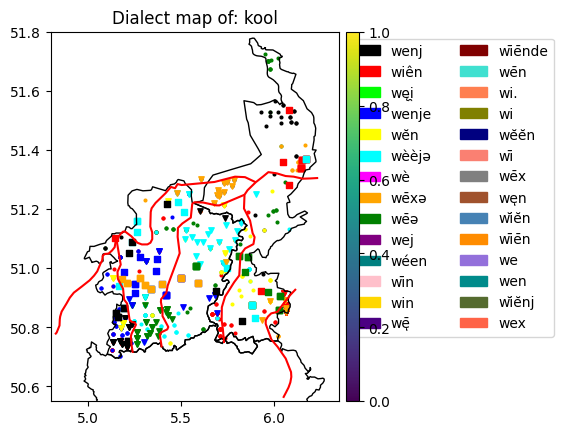

{('red', '.'): 'kuul', ('green', '.'): 'kool', ('blue', '.'): 'kyəl', ('cyan', '.'): 'keul', ('orange', '.'): 'koel', ('black', '.'): 'koeël', ('yellow', '.'): 'koal', ('red', 'v'): 'koǝl', ('green', 'v'): 'køͅyl', ('blue', 'v'): 'kyl', ('cyan', 'v'): 'kūəl', ('orange', 'v'): 'kuuël', ('black', 'v'): 'kȳəl', ('yellow', 'v'): 'kȳl', ('red', 's'): 'koël', ('green', 's'): 'kǭl', ('blue', 's'): 'kul', ('cyan', 's'): 'kuəl', ('orange', 's'): 'kil', ('black', 's'): 'kuuəl'}


In [ ]:
DialectMap('kool', df)

In [ ]:
DialectMapSounds('kool', df, ['i', 'ie', 'e', 'u', 'o'], True, [5.0702987, 50.9341079])

In [ ]:
print(BeamSearch_normalization(transformer_normalization, [''], [[0.19135108585711208,0.6714974639687558]], [[0.19135108585711208,0.6714974639687558]]))

leͅifkəs


# **Geographic transformer: dialect translation**

## Initialize dataframe for benchmarking + visualization

In [ ]:
#%%script false --no-raise-error
#graphemes that indicate that a word is definitely not in high-quality IPA
blacklisted = ['aa', 'ee', 'uu', 'oo', 'ij', 'ei', 'eu', 'oe', 'au', 'ou', 'ui', 'y', 'sch', 'sj',
              'ng', 'nk', 'uw', 'ae', 'ao', 'äö', 'ië', 'eë', 'i-j', 'dj', 'qu', 'tj', 'zj', 'oë',
              'uë', 'ch', 'rr', 'tt', 'pp', 'ss', 'dd', 'ff', 'gg', 'kk', 'll', 'mm', 'cc', 'bb', 'nn',
              'oa', 'ks', 'ie', 'ai', 'ww', 'ea', 'ei']

#Note: r is always written like this in WLD (so not phonetic representation of velar/uvular/etc.) and g is already corrected above in the handcrafted normalization

def isBlacklisted(word):
  for grapheme in blacklisted:
    if grapheme in word:
      return(True)
  return(False)

In [ ]:
#%%script false --no-raise-error
#used to generate the dataset for the transformer training

matched_mask = (df['matched'] == True)

dialect_list = df['dialectopgave'].values
normalized_list = []
normalized_mask = []

#only consider high-quality IPA entries
for i, word in enumerate(dialect_list):
  if not isBlacklisted(word):
    normalized_list.append(word)
    normalized_mask.append(True)
  else:
    normalized_mask.append(False)

#AND of masks
matched_mask = np.array(matched_mask)
normalized_mask = np.array(normalized_mask)
mask = matched_mask & normalized_mask

#extract normalized data
df_normalized = df[mask]
normalized = df_normalized[['trefwoord', 'dialectopgave', 'y', 'x']].values

df_grouped = df_normalized.groupby(['trefwoord'], as_index=False).agg({'dialectopgave': lambda x: list(x), 'y': lambda x: list(x), 'x': lambda x: list(x)})
gc.collect()

0

## generate training dataset

Following cells only need to be run once to generate the datasets that the transformer will be trained and tested on. NOTE: resampling not required, this is done per keyword (below)

In [ ]:
%%script false --no-raise-error
#generates the training set for training the transformer in dialect translation
#WARNING: this requires at least 20GB of RAM

#remove most common keywords (noisy filler words from sentences)
df_grouped.reset_index(drop=True)
lengths = [len(grouped) for grouped in df_grouped['dialectopgave'].values]
removed_idxs = np.argsort(lengths)[-20:]

df_grouped = df_grouped.drop(removed_idxs, axis=0)

#the following code is optimized to prevent memory overflow
source_list = np.empty(55000000, dtype=object) #make large enough to have buffer
target_list = np.empty(55000000, dtype=object)

temp_source_list = []
temp_target_list = []

counter = 0

for i in range(1, df_grouped.shape[0]): #skip first element (nonsense)
  if i % 250 == 0:
    print(i/df_grouped.shape[0])
    #sample 10% for downsizing the dataset
    new_size = int(np.floor(len(temp_source_list) / 10))
    idx = np.random.randint(0, len(temp_source_list), new_size)
    source_list[counter : counter + new_size] = np.array(temp_source_list)[idx]
    target_list[counter : counter + new_size] = np.array(temp_target_list)[idx]
    temp_source_list = []
    temp_target_list = []
    counter += new_size
    gc.collect()

  #resample keyword to make geographically representative
  entries = df_grouped.iloc[[i]]
  if len(entries['dialectopgave'].values[0]) <= 10: #skip if less than 10 dialect entries
    continue
  kernel = stats.gaussian_kde([entries['y'].values[0], entries['x'].values[0]], weights=[1]*len(entries['dialectopgave'].values[0]), bw_method=0.4)
  kernel_weights = kernel([entries['y'].values[0], entries['x'].values[0]])
  sample_probabilities = 1 / (kernel_weights)

  entries_new = pd.DataFrame(np.transpose(np.array([entries['dialectopgave'].values[0], entries['y'].values[0], entries['x'].values[0]])))
  entries = entries_new.sample(frac=1, weights=sample_probabilities, replace=True)

  words_list = entries[0].values
  coordinates_list = list(zip(entries[1].values, entries[2].values))

  #filter out words longer than 10 characters
  words_list_10 = []
  coordinates_list_10 = []
  for j in range(len(words_list)):
    if len(words_list[j]) <= 10:
      words_list_10.append(words_list[j])
      coordinates_list_10.append(coordinates_list[j])

  words_list = words_list_10
  coordinates_list = coordinates_list_10

  if not words_list:
    continue

  #generate all word combinations
  for x1 in range(len(words_list)):
    for y1 in range(len(words_list)):
      if x1 != y1:
        temp_source_list.append(words_list[x1])
        #add the start token and end token to the target word
        temp_target_list.append('$' + words_list[y1] + '□')
        print(words_list[x1], coordinates_list[x1], words_list[y1], coordinates_list[y1])

#find max index to remove the remainder of the placeholders in the arrays
for i, word in enumerate(source_list):
  if word == None:
    max_index = i
    break

#store as pickles
with open('/content/drive/MyDrive/Thesis/source_list.pickle', 'wb') as f:
  pickle.dump(source_list[:max_index], f)
with open('/content/drive/MyDrive/Thesis/target_list.pickle', 'wb') as f:
  pickle.dump(target_list[:max_index], f)
with open('/content/drive/MyDrive/Thesis/xy_list_source.pickle', 'wb') as f:
  pickle.dump(xy_list_source[:max_index], f)
with open('/content/drive/MyDrive/Thesis/xy_list_target.pickle', 'wb') as f:
  pickle.dump(xy_list_target[:max_index], f)

## load training dataset

In [ ]:
vocabulary = ['-', '.', ':', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¯', 'à', 'á', 'â', 'ä',
              'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ù', 'ú', 'û', 'ü',
              'ā', 'ē', 'ę', 'ī', 'ŋ', 'ō', 'ő', 'š', 'ū', 'ű', 'ž', 'ǝ', 'ǫ', 'ǭ', 'ȳ', 'ə', 'ɛ', 'ʔ',
              '˙', '˱', '˲', '̃', '̄', '̆', '̇', '̋', '̌', '̜', '̝', '̞', '̣', '̥', '̯', '͂', 'ͅ', 'ẽ', '‧']

vocabulary.append('□')
vocabulary.append('$')

In [ ]:
#load training dataset from pickles
with open('/content/drive/MyDrive/Thesis/source_list.pickle', 'rb') as f:
  source_list = pickle.load(f)
with open('/content/drive/MyDrive/Thesis/target_list.pickle', 'rb') as f:
  target_list = pickle.load(f)
with open('/content/drive/MyDrive/Thesis/xy_list_source.pickle', 'rb') as f:
  xy_list_source = pickle.load(f)
with open('/content/drive/MyDrive/Thesis/xy_list_target.pickle', 'rb') as f:
  xy_list_target = pickle.load(f)

xy_list_source = xy_list_source.astype(np.float32)
xy_list_target = xy_list_target.astype(np.float32)
gc.collect()

0

In [ ]:
#initialize the embedding layers that embed characters into representation vectors of a certain embedding dimension
embedder = tf.keras.layers.TextVectorization(max_tokens=2000, output_mode='int', split='character', output_sequence_length=10, vocabulary=vocabulary, standardize=None)
dislodger = tf.keras.layers.TextVectorization(max_tokens=2000, output_mode='int', split='character', output_sequence_length=11, vocabulary=vocabulary, standardize=None)

## training

In [ ]:
gc.collect()

In [ ]:
#split into train, validation and test datasets

def format_dataset(source, target, coords_source, coords_target):
    source_embedded = embedder(source)
    target_embedded = dislodger(target)
    return({"encoder_inputs": source_embedded, "decoder_inputs": target_embedded[:, :-1], "coords_source" : coords_source, "coords_target" : coords_target}, target_embedded[:, 1:])

def make_dataset(sources, targets, coords_source, coords_target):
    dataset = tf.data.Dataset.from_tensor_slices((sources, targets, coords_source, coords_target))
    dataset = dataset.batch(1024)
    dataset = dataset.map(format_dataset)
    return(dataset.prefetch(256).cache())

ds = make_dataset(source_list, target_list, xy_list_source, xy_list_target)

def get_dataset_partitions_tf(ds, ds_size=tf.data.experimental.cardinality(ds).numpy(), train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=100000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    ds_train = ds.take(train_size)
    ds_val = ds.skip(train_size).take(val_size)
    ds_test = ds.skip(train_size).skip(val_size)

    return(ds_train, ds_val, ds_test)

ds_train, ds_val, ds_test = get_dataset_partitions_tf(ds)
gc.collect()

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return(tf.math.not_equal(inputs, 0))

class CoordinateEmbedding(layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim
        # Signal that the layer is safe for mask propagation
        self.supports_masking = True

    def call(self, inputs, coords):
        #add 2 extra entries to first dimension (rows), first column gets yx, rest padded with 0
        coords = tf.cast(coords, tf.float32)
        coords = tf.expand_dims(coords, 2)
        coords = tf.transpose(coords, [0, 2, 1])
        length = tf.shape(inputs)[1]
        paddings = tf.concat(([[0, 0], [0, length-1]], [[0, 0]]), axis=0)
        to_be_appended = tf.pad(coords, paddings, "CONSTANT", constant_values=0)
        to_be_appended = tf.reshape(to_be_appended, [tf.shape(inputs)[0], length, 2])
        inputs = tf.concat([inputs, to_be_appended], 2)
        return(inputs)

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
embed_dim = 256
latent_dim = 1024
num_heads = 8
sequence_length= 12
vocab_size = len(embedder.get_vocabulary())

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
coords =  keras.Input(shape=(2,), dtype="float32", name="coords_source")
x1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
x2 = CoordinateEmbedding(sequence_length, embed_dim)(x1, coords)
encoder_outputs = TransformerEncoder(embed_dim+2, latent_dim, num_heads)(x2)
encoder = keras.Model([encoder_inputs, coords], encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
coords2 =  keras.Input(shape=(2,), dtype="float32", name="coords_target")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim+2), name="decoder_state_inputs")
x1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x2 = CoordinateEmbedding(sequence_length, embed_dim)(x1, coords2)
x3 = TransformerDecoder(embed_dim+2, latent_dim, num_heads)(x2, encoded_seq_inputs)
x = layers.Dropout(0.5)(x3)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs, coords2], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs, coords2])
transformer = keras.Model([encoder_inputs, coords, decoder_inputs, coords2], decoder_outputs, name="transformer")

In [ ]:
#early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1, mode='min')

In [ ]:
epochs = 50 # This should be at least 50 for convergence

transformer.summary()
#change Adam learning rate
#opt = keras.optimizers.Adam(beta_1 = 0.9999, beta_2=0.9995)
opt = keras.optimizers.Adam()
transformer.compile(opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
transformer.fit(ds_train, validation_data=ds_test, epochs=epochs, callbacks=[callback]) #callbacks=[NormalizationCallback()]

## load network

In [ ]:
vocabulary = ['-', '.', ':', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¯', 'à', 'á', 'â', 'ä',
              'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ù', 'ú', 'û', 'ü',
              'ā', 'ē', 'ę', 'ī', 'ŋ', 'ō', 'ő', 'š', 'ū', 'ű', 'ž', 'ǝ', 'ǫ', 'ǭ', 'ȳ', 'ə', 'ɛ', 'ʔ',
              '˙', '˱', '˲', '̃', '̄', '̆', '̇', '̋', '̌', '̜', '̝', '̞', '̣', '̥', '̯', '͂', 'ͅ', 'ẽ', '‧']

vocabulary.append('□')
vocabulary.append('$')

In [ ]:
#initialize the embedding layers that embed characters into representation vectors of a certain embedding dimension
embedder = tf.keras.layers.TextVectorization(max_tokens=2000, output_mode='int', split='character', output_sequence_length=10, vocabulary=vocabulary, standardize=None)
dislodger = tf.keras.layers.TextVectorization(max_tokens=2000, output_mode='int', split='character', output_sequence_length=11, vocabulary=vocabulary, standardize=None)

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return(tf.math.not_equal(inputs, 0))

class CoordinateEmbedding(layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim
        # Signal that the layer is safe for mask propagation
        self.supports_masking = True

    def call(self, inputs, coords):
        #add 2 extra entries to first dimension (rows), first column gets yx, rest padded with 0
        coords = tf.cast(coords, tf.float32)
        coords = tf.expand_dims(coords, 2)
        coords = tf.transpose(coords, [0, 2, 1])
        length = tf.shape(inputs)[1]
        paddings = tf.concat(([[0, 0], [0, length-1]], [[0, 0]]), axis=0)
        to_be_appended = tf.pad(coords, paddings, "CONSTANT", constant_values=0)
        to_be_appended = tf.reshape(to_be_appended, [tf.shape(inputs)[0], length, 2])
        inputs = tf.concat([inputs, to_be_appended], 2)
        return(inputs)

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
embed_dim = 256
latent_dim = 1024
num_heads = 8
sequence_length= 12
vocab_size = len(embedder.get_vocabulary())

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
coords =  keras.Input(shape=(2,), dtype="float32", name="coords_source")
x1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
x2 = CoordinateEmbedding(sequence_length, embed_dim)(x1, coords)
encoder_outputs = TransformerEncoder(embed_dim+2, latent_dim, num_heads)(x2)
encoder = keras.Model([encoder_inputs, coords], encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
coords2 =  keras.Input(shape=(2,), dtype="float32", name="coords_target")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim+2), name="decoder_state_inputs")
x1 = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x2 = CoordinateEmbedding(sequence_length, embed_dim)(x1, coords2)
x3 = TransformerDecoder(embed_dim+2, latent_dim, num_heads)(x2, encoded_seq_inputs)
x = layers.Dropout(0.5)(x3)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs, coords2], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs, coords2])
transformer = keras.Model([encoder_inputs, coords, decoder_inputs, coords2], decoder_outputs, name="transformer")

In [ ]:
transformer.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
transformer.load_weights('/content/drive/MyDrive/Thesis/checkpoints/GeographicTransformerTranslationFinal2')

##Initialize beamsearch decoder

### Load beam_search from KerasNLP

The following code is deprecated in the future and is therefore taken entirely from https://github.com/keras-team/keras-nlp/blob/v0.4.1/keras_nlp/utils/text_generation.py#L213, all appropriate rights belong to the KerasNLP team according to an Apache 2.0 license. Only the beam_search_likelihood function was adapted by me (Andreas Simons) to return the likelihood of the most promising beam at the end, instead of the embedded indices.

In [ ]:
# Copyright 2023 The KerasNLP Authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Text generation utilities."""

import tensorflow as tf
from absl import logging
from tensorflow import keras


def _validate_prompt(prompt):
    """Helper function to validate input to text_generation utils."""
    if not isinstance(prompt, (tf.Tensor, tf.RaggedTensor)):
        prompt = tf.convert_to_tensor(prompt)
    return prompt


def _validate_token_probability_fn(token_probability_fn, prompt):
    """Helper function to validate `token_probability_fn` output."""
    test_pred = token_probability_fn(prompt)
    if len(test_pred.shape) != 2:
        raise ValueError(
            "Output of `token_probability_fn` is not a 2D tensor, "
            "please provide a function with the output shape "
            "[batch_size, vocab_size]."
        )

    return tf.shape(test_pred)[-1], test_pred.dtype


def _get_prompt_shape(prompt):
    """Helper function to get the batch size and prompt length."""
    if isinstance(prompt, tf.Tensor):
        shape = tf.shape(prompt)
        return (shape[0], shape[1])
    elif isinstance(prompt, tf.RaggedTensor):
        batch_size = prompt.nrows()
        length = tf.math.reduce_min(tf.RaggedTensor.row_lengths(prompt))
        return (batch_size, length)


def _pad_prompt(prompt, max_length):
    """Pad prompt to `max_length` and compute a mask for controlled updates.

    This utility will pad the (possibly ragged) prompt to `max_length`, and
    compute a mask where the input was originally set in the prompt, to avoid
    overwriting the original inputs when generating token(s) for the next
    timestep.
    """
    if isinstance(prompt, tf.Tensor):
        shape = tf.shape(prompt)
        extra_space = tf.math.maximum(0, max_length - shape[1])
        pad_shape = [shape[0], extra_space]

        mask = tf.ones(shape, tf.bool)
        mask = tf.concat((mask, tf.zeros(pad_shape, tf.bool)), axis=1)
        prompt = tf.concat((prompt, tf.zeros(pad_shape, prompt.dtype)), axis=1)
    elif isinstance(prompt, tf.RaggedTensor):
        # TODO: `to_tensor()` works with `jit_compile = True` in TF 2.8.x but
        # fails in TF 2.9.x. Fix this. After this issue has been fixed, we can
        # condense the two branches into one by starting off with a ragged tensor.
        mask = tf.ones_like(prompt, dtype=tf.bool)
        mask = mask.to_tensor(shape=(None, max_length))
        prompt = prompt.to_tensor(shape=(None, max_length))
    return prompt, mask


def _mask_tokens_after_end_token(
    prompt, max_length, end_token_id, pad_token_id
):
    """Helper function to mask the tokens after the end token."""
    # Mask out tokens after `end_token_id` is encountered.
    # Find index of first end_token_id.
    end_indices = tf.math.argmax(prompt == end_token_id, -1)
    # Use max_length if no `end_token_id` is found.
    end_indices = tf.where(
        end_indices == 0,
        tf.cast(max_length, dtype=end_indices.dtype),
        end_indices,
    )
    # Build a mask including end_token and replace tokens after end_token
    # with `pad_token_id`.
    valid_indices = tf.sequence_mask(end_indices + 1, maxlen=max_length)
    return tf.where(valid_indices, prompt, pad_token_id)


def greedy_search(
    token_probability_fn,
    prompt,
    max_length,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on greedy search.

    Greedy search always appends the token having the largest probability to
    existing sequence.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and output the probability distribution or the logits of the next
            token.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens.
        max_length: int. The max length of generated text.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int RaggedTensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.greedy_search(
        token_probability_fn,
        prompt,
        max_length=10,
        end_token_id=END_ID,
    )
    ```

    """
    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    _validate_token_probability_fn(token_probability_fn, prompt)

    def one_step(length, prompt):
        pred = token_probability_fn(prompt[:, :length])
        next_token = tf.cast(tf.argmax(pred, axis=-1), dtype=prompt.dtype)
        next_token = tf.where(mask[:, length], prompt[:, length], next_token)

        # Append the next token to current sequence.
        prompt = tf.tensor_scatter_nd_update(
            tensor=prompt,
            indices=tf.stack(
                (
                    tf.cast(tf.range(batch_size), dtype=length.dtype),
                    tf.repeat(length, batch_size),
                ),
                axis=1,
            ),
            updates=next_token,
        )

        length = tf.add(length, 1)
        return (length, prompt)

    # Run a while loop till text of length `max_length` has been generated.
    length, prompt = tf.while_loop(
        cond=lambda length, _: tf.less(length, max_length),
        body=one_step,
        loop_vars=(length, prompt),
    )

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )

    return tf.squeeze(prompt) if input_is_1d else prompt


def beam_search(
    token_probability_fn,
    prompt,
    max_length,
    num_beams,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on beam search algorithm.

    At each time-step, beam search keeps the beams (sequences) of the top
    `num_beams` highest accumulated probabilities, and uses each one of the
    beams to predict candidate next tokens.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and outputs the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token. The input shape would be `[batch_size * num_beams, length]`
            and the output should be `[batch_size * num_beams, vocab_size]`.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens. The initial beam for beam search.
        max_length: int. The max length of generated text.
        num_beams: int. The number of beams that should be kept at each
            time-step. `num_beams` should be strictly positive.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.beam_search(
        token_probability_fn,
        prompt,
        max_length=10,
        num_beams=5,
        end_token_id=END_ID,
    )
    ```

    """
    if num_beams <= 0:
        raise ValueError(
            f"`num_beams` should be strictly positive. Received: `num_beams={num_beams}`."
        )
    if num_beams == 1:
        return greedy_search(
            token_probability_fn=token_probability_fn,
            prompt=prompt,
            max_length=max_length,
            end_token_id=end_token_id,
            pad_token_id=pad_token_id,
        )

    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    vocab_size, pred_dtype = _validate_token_probability_fn(
        token_probability_fn, prompt
    )

    if length >= max_length:
        return tf.squeeze(prompt) if input_is_1d else prompt

    # Initialize beam with shape `(batch_size, num_beams, length)`.
    beams = tf.repeat(tf.expand_dims(prompt, axis=1), num_beams, axis=1)

    # Initialize `beams_prob` with shape `(batch_size, num_beams)`.
    beams_prob = tf.zeros([batch_size, 1], dtype=pred_dtype)
    beams_prob = tf.concat(
        [beams_prob, tf.fill((batch_size, num_beams - 1), pred_dtype.min)],
        axis=-1,
    )

    def one_step(beams, beams_prob, length):
        truncated_beams = beams[..., :length]

        flattened_beams = tf.reshape(
            truncated_beams, shape=[batch_size * num_beams, -1]
        )
        preds = token_probability_fn(flattened_beams)
        if from_logits:
            preds = keras.activations.softmax(preds, axis=-1)
        # Reshape `preds` to shape `(batch_size, num_beams * vocab_size)`.
        preds = tf.reshape(preds, shape=[batch_size, -1])

        probs = tf.math.log(preds) + tf.repeat(
            beams_prob, repeats=vocab_size, axis=1
        )

        candidate_prob, candidate_indexes = tf.math.top_k(
            probs, k=num_beams, sorted=False
        )
        candidate_beam_indexes = candidate_indexes // vocab_size
        next_token = candidate_indexes % vocab_size

        beams = tf.gather(beams, candidate_beam_indexes, axis=1, batch_dims=1)

        # Build a new column of updates to scatter into the beam tensor.
        next_token = tf.where(
            condition=mask[..., length, tf.newaxis],
            x=beams[..., length],
            y=next_token,
        )
        next_token = tf.reshape(next_token, shape=[-1])

        # Generate `(batch_index, beam_index)` tuples for each beam.
        beam_indices = tf.where(tf.ones((batch_size, num_beams), tf.bool))
        beam_indices = tf.cast(beam_indices, dtype=length.dtype)
        # Build a tensor of repeated `length` values.
        length_indices = tf.fill((batch_size * num_beams, 1), length)
        # Concatenate to a triplet of `(batch_index, beam_index, length)`.
        indices = tf.concat([beam_indices, length_indices], axis=-1)

        # Update `beams[:, :, length]` with `next_token`.
        beams = tf.tensor_scatter_nd_update(
            tensor=beams,
            indices=indices,
            updates=next_token,
        )

        beams_prob = candidate_prob
        length = tf.add(length, 1)

        return beams, beams_prob, length

    # Run a while loop till text of length `max_length` has been generated.
    beams, beams_prob, length = tf.while_loop(
        cond=lambda beams, beams_prob, length: tf.less(length, max_length),
        body=one_step,
        loop_vars=(beams, beams_prob, length),
    )

    # Get the beam with the maximum probability.
    max_indexes = tf.math.argmax(beams_prob, axis=-1)
    max_beams = tf.gather(
        beams, max_indexes[:, tf.newaxis], axis=1, batch_dims=1
    )
    prompt = tf.squeeze(max_beams)

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )
    return tf.squeeze(prompt) if input_is_1d else prompt

def beam_search_likelihood(
    token_probability_fn,
    prompt,
    max_length,
    num_beams,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on beam search algorithm.

    At each time-step, beam search keeps the beams (sequences) of the top
    `num_beams` highest accumulated probabilities, and uses each one of the
    beams to predict candidate next tokens.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and outputs the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token. The input shape would be `[batch_size * num_beams, length]`
            and the output should be `[batch_size * num_beams, vocab_size]`.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens. The initial beam for beam search.
        max_length: int. The max length of generated text.
        num_beams: int. The number of beams that should be kept at each
            time-step. `num_beams` should be strictly positive.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.beam_search(
        token_probability_fn,
        prompt,
        max_length=10,
        num_beams=5,
        end_token_id=END_ID,
    )
    ```

    """
    if num_beams <= 0:
        raise ValueError(
            f"`num_beams` should be strictly positive. Received: `num_beams={num_beams}`."
        )
    if num_beams == 1:
        return greedy_search(
            token_probability_fn=token_probability_fn,
            prompt=prompt,
            max_length=max_length,
            end_token_id=end_token_id,
            pad_token_id=pad_token_id,
        )

    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    vocab_size, pred_dtype = _validate_token_probability_fn(
        token_probability_fn, prompt
    )

    if length >= max_length:
        return tf.squeeze(prompt) if input_is_1d else prompt

    # Initialize beam with shape `(batch_size, num_beams, length)`.
    beams = tf.repeat(tf.expand_dims(prompt, axis=1), num_beams, axis=1)

    # Initialize `beams_prob` with shape `(batch_size, num_beams)`.
    beams_prob = tf.zeros([batch_size, 1], dtype=pred_dtype)
    beams_prob = tf.concat(
        [beams_prob, tf.fill((batch_size, num_beams - 1), pred_dtype.min)],
        axis=-1,
    )

    def one_step(beams, beams_prob, length):
        truncated_beams = beams[..., :length]

        flattened_beams = tf.reshape(
            truncated_beams, shape=[batch_size * num_beams, -1]
        )
        preds = token_probability_fn(flattened_beams)
        if from_logits:
            preds = keras.activations.softmax(preds, axis=-1)
        # Reshape `preds` to shape `(batch_size, num_beams * vocab_size)`.
        preds = tf.reshape(preds, shape=[batch_size, -1])

        probs = tf.math.log(preds) + tf.repeat(
            beams_prob, repeats=vocab_size, axis=1
        )

        candidate_prob, candidate_indexes = tf.math.top_k(
            probs, k=num_beams, sorted=False
        )
        candidate_beam_indexes = candidate_indexes // vocab_size
        next_token = candidate_indexes % vocab_size

        beams = tf.gather(beams, candidate_beam_indexes, axis=1, batch_dims=1)

        # Build a new column of updates to scatter into the beam tensor.
        next_token = tf.where(
            condition=mask[..., length, tf.newaxis],
            x=beams[..., length],
            y=next_token,
        )
        next_token = tf.reshape(next_token, shape=[-1])

        # Generate `(batch_index, beam_index)` tuples for each beam.
        beam_indices = tf.where(tf.ones((batch_size, num_beams), tf.bool))
        beam_indices = tf.cast(beam_indices, dtype=length.dtype)
        # Build a tensor of repeated `length` values.
        length_indices = tf.fill((batch_size * num_beams, 1), length)
        # Concatenate to a triplet of `(batch_index, beam_index, length)`.
        indices = tf.concat([beam_indices, length_indices], axis=-1)

        # Update `beams[:, :, length]` with `next_token`.
        beams = tf.tensor_scatter_nd_update(
            tensor=beams,
            indices=indices,
            updates=next_token,
        )

        beams_prob = candidate_prob
        length = tf.add(length, 1)

        return beams, beams_prob, length

    # Run a while loop till text of length `max_length` has been generated.
    beams, beams_prob, length = tf.while_loop(
        cond=lambda beams, beams_prob, length: tf.less(length, max_length),
        body=one_step,
        loop_vars=(beams, beams_prob, length),
    )

    # Get the beam with the maximum probability.
    max_indexes = tf.reduce_max(beams_prob, axis=-1)
    prompt = tf.squeeze(max_indexes)
    return tf.squeeze(prompt)


def random_search(
    token_probability_fn,
    prompt,
    max_length,
    seed=None,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on randomly sampling the entire probability
    distribution.

    Random sampling samples the next token from the probability distribution
    provided by `token_probability_fn` and appends it to the existing sequence.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and output the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens.
        max_length: int. The max length of generated text.
        seed: int, defaults to None. The random seed used for sampling.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.random_search(
        token_probability_fn,
        prompt,
        max_length=10,
        end_token_id=END_ID,
    )
    ```

    """
    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    _validate_token_probability_fn(token_probability_fn, prompt)

    def one_step(length, prompt):
        pred = token_probability_fn(prompt[:, :length])
        if from_logits:
            pred = keras.activations.softmax(pred, axis=-1)
        next_token = tf.squeeze(
            tf.cast(
                tf.random.categorical(tf.math.log(pred), 1, seed=seed),
                dtype=prompt.dtype,
            ),
            axis=1,
        )
        next_token = tf.where(mask[:, length], prompt[:, length], next_token)

        # Append the next token to current sequence.
        prompt = tf.tensor_scatter_nd_update(
            tensor=prompt,
            indices=tf.stack(
                (
                    tf.cast(tf.range(batch_size), dtype=length.dtype),
                    tf.repeat(length, batch_size),
                ),
                axis=1,
            ),
            updates=next_token,
        )

        length = tf.add(length, 1)
        return (length, prompt)

    # Run a while loop till text of length `max_length` has been generated.
    length, prompt = tf.while_loop(
        cond=lambda length, _: tf.less(length, max_length),
        body=one_step,
        loop_vars=(length, prompt),
    )

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )

    return tf.squeeze(prompt) if input_is_1d else prompt


def top_k_search(
    token_probability_fn,
    prompt,
    max_length,
    k,
    seed=None,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on top-k sampling.

    Top-k search samples the next token from the top-k tokens in the
    probability distribution provided by `token_probability_fn` and appends it
    to the existing sequence.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and output the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens.
        max_length: int. The max length of generated text.
        k: int. The number of top tokens to sample from. Should be non-negative
            and less than the vocabulary size.
        seed: int, defaults to None. The random seed used for sampling.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.top_k_search(
        token_probability_fn,
        prompt,
        max_length=10,
        k=4,
        end_token_id=END_ID,
    )
    ```

    """
    if k <= 0:
        raise ValueError(f"`k` should be strictly positive. Received: `k={k}`.")

    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    _validate_token_probability_fn(token_probability_fn, prompt)

    # If k is greater than the vocabulary size, use the entire vocabulary.
    pred = token_probability_fn(prompt)
    if k > pred.shape[1]:
        logging.warning(
            f"`k` larger than vocabulary size={pred.shape[1]}."
            f"Setting `k` to vocabulary size. Received: `k={k}`."
        )
        k = pred.shape[1]

    def one_step(length, prompt):
        pred = token_probability_fn(prompt[:, :length])
        if from_logits:
            pred = keras.activations.softmax(pred, axis=-1)

        # Filter out top-k tokens.
        top_k_pred, top_k_indices = tf.math.top_k(pred, k=k, sorted=False)
        # Sample the next token from the probability distribution.
        next_token = tf.random.categorical(
            tf.math.log(top_k_pred), 1, seed=seed
        )

        # Rearrange to get the next token idx from the original order.
        next_token = tf.gather_nd(top_k_indices, next_token, batch_dims=1)
        next_token = tf.cast(next_token, dtype=prompt.dtype)
        next_token = tf.where(mask[:, length], prompt[:, length], next_token)

        # Append the next token to current sequence.
        prompt = tf.tensor_scatter_nd_update(
            tensor=prompt,
            indices=tf.stack(
                (
                    tf.cast(tf.range(batch_size), dtype=length.dtype),
                    tf.repeat(length, batch_size),
                ),
                axis=1,
            ),
            updates=next_token,
        )

        length = tf.add(length, 1)
        return (length, prompt)

    # Run a while loop till text of length `max_length` has been generated.
    length, prompt = tf.while_loop(
        cond=lambda length, _: tf.less(length, max_length),
        body=one_step,
        loop_vars=(length, prompt),
    )

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )

    return tf.squeeze(prompt) if input_is_1d else prompt


def top_p_search(
    token_probability_fn,
    prompt,
    max_length,
    p,
    seed=None,
    from_logits=False,
    end_token_id=None,
    pad_token_id=0,
):
    """Text generation utility based on top-p (nucleus) sampling.

    Top-p search selects tokens from the smallest subset of output probabilities
    that sum to greater than `p`. Put another way, top-p will first order
    token predictions by likelihood, and ignore all tokens after the cumulative
    probability of selected tokens exceeds `p`. The probability of each
    token is provided by `token_probability_fn`.

    Args:
        token_probability_fn: a callable, which takes in input_sequence
            and output the probability distribution of the next token. If
            `from_logits` set to True, it should output the logits of the next
            token.
        prompt: a list or a Tensor, can be 1D or 2D, the initial tokens to
            append generated tokens.
        max_length: int. The max length of generated text.
        p: float. The probability that the top tokens sums up to. Should
            follow the constraint of 0 < p < 1.
        seed: int, defaults to None. The random seed used for sampling.
        from_logits: bool. Indicates whether `token_probability_fn` outputs
            logits or probabilities.
        end_token_id: int, defaults to None. The token marking the end of the
            sequence, once encountered the generation is finished for the exact
            sequence. If None, every sequence is generated up to `max_length`.
            If set, all tokens after encountering `end_token_id` will be
            replaced with `pad_token_id`.
        pad_token_id: int, defaults to 0. The pad token after `end_token_id`
            is received.

    Returns:
        A 1D int Tensor, or 2D int Tensor representing the generated
        sequences.

    Examples:
    ```python
    BATCH_SIZE = 8
    VOCAB_SIZE = 10
    FEATURE_SIZE = 16
    START_ID = 1
    END_ID = 2

    # Create a dummy model to predict the next token.
    model = keras.Sequential(
        [
            keras.Input(shape=[None]),
            keras.layers.Embedding(
                input_dim=VOCAB_SIZE,
                output_dim=FEATURE_SIZE,
            ),
            keras.layers.Dense(VOCAB_SIZE, activation="softmax"),
        ]
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(inputs):
        return model(inputs)[:, -1, :]

    prompt = tf.fill((BATCH_SIZE, 1), START_ID)

    # Print the generated sequence (token ids).
    keras_nlp.utils.top_p_search(
        token_probability_fn,
        prompt,
        max_length=10,
        p=0.8,
        end_token_id=END_ID,
    )
    ```

    """
    if p <= 0 or p >= 1:
        raise ValueError(
            f"`p` should be in the range (0, 1). Received: `p={p}`."
        )

    prompt = _validate_prompt(prompt)

    input_is_1d = prompt.shape.rank == 1
    if input_is_1d:
        prompt = prompt[tf.newaxis, :]

    batch_size, length = _get_prompt_shape(prompt)
    prompt, mask = _pad_prompt(prompt, max_length)

    _validate_token_probability_fn(token_probability_fn, prompt)

    def one_step(length, prompt):
        pred = token_probability_fn(prompt[:, :length])
        if from_logits:
            pred = keras.activations.softmax(pred, axis=-1)
        # Sort preds in descending order.
        sorted_preds, sorted_indices = tf.math.top_k(
            pred, k=pred.shape[1], sorted=True
        )
        # Calculate cumulative probability distribution.
        cumulative_probs = tf.math.cumsum(sorted_preds, axis=-1)
        # Create a mask for the tokens to keep.
        keep_mask = cumulative_probs <= p
        # Shift to include the last token that exceed p.
        shifted_keep_mask = tf.concat(
            [tf.ones_like(keep_mask[:, :1]), keep_mask[:, :-1]], axis=-1
        )
        # Filter out unmasked tokens and sample from filtered distribution.
        probs = tf.where(
            shifted_keep_mask,
            sorted_preds,
            tf.zeros(tf.shape(pred), dtype=sorted_preds.dtype),
        )
        sorted_next_token = tf.random.categorical(
            tf.math.log(probs), 1, seed=seed
        )
        next_token = tf.gather_nd(
            sorted_indices, sorted_next_token, batch_dims=1
        )
        next_token = tf.cast(next_token, dtype=prompt.dtype)
        next_token = tf.where(mask[:, length], prompt[:, length], next_token)

        # Append the next token to current sequence.
        prompt = tf.tensor_scatter_nd_update(
            tensor=prompt,
            indices=tf.stack(
                (
                    tf.cast(tf.range(batch_size), dtype=length.dtype),
                    tf.repeat(length, batch_size),
                ),
                axis=1,
            ),
            updates=next_token,
        )

        length = tf.add(length, 1)
        return (length, prompt)

    # Run a while loop till text of length `max_length` has been generated.
    length, prompt = tf.while_loop(
        cond=lambda length, _: tf.less(length, max_length),
        body=one_step,
        loop_vars=(length, prompt),
    )

    if end_token_id is not None:
        prompt = _mask_tokens_after_end_token(
            prompt, max_length, end_token_id, pad_token_id
        )

    return tf.squeeze(prompt) if input_is_1d else prompt

### Define embedder and dislodger function + beam search wrapper for returning decoded word or likelihood

In [ ]:
#embedder and dislodger functions for word2vec and vec2word
vocab = dislodger.get_vocabulary()
vocab_index_lookup = dict(zip(range(len(vocab)), vocab))
index_vocab_lookup = dict(zip(vocab, range(len(vocab))))

def Embed(input):
  if isinstance(input, str):
    word = input
    output = []
    for character in word:
      output.append(index_vocab_lookup[character])
    return(output)
  else:
    outputs = []
    for word in input:
      output = []
      for character in word:
        output.append(index_vocab_lookup[character])
      outputs.append(output)
    return(outputs)

def Dislodge(input):
  if len(input.shape) == 1:
    indices = input
    output = ''
    for index in indices:
      output = output + vocab_index_lookup[index]
    return(output)
  else:
    outputs = []
    for indices in input:
      output = ''
      for index in indices:
        output = output + vocab_index_lookup[index]
      outputs.append(output)
    return(outputs)

In [ ]:
#define BeamSearch
#takes as input list/batch of words

#returns most likely word according to beam search
def BeamSearch(input_words, coords_source, coords_target):
    #set number of beams
    NUM_BEAMS = 3

    #get batch size
    batch_size = tf.shape(input_words)[0].numpy()

    #embed the encoder input
    input_encoder = embedder(input_words)

    coords_source = tf.constant(coords_source)
    coords_target = tf.constant(coords_target)

    #function that outputs logits for the next character
    def character_probability_fn(input_decoder):
        num_samples = tf.shape(input_decoder)[0]
        repeats = num_samples // batch_size #repeat the input so the transformer receives the entire batch
        input_encoder_repeated = tf.repeat(
            input_encoder,
            repeats=repeats,
            axis=0
        )
        length_input_decoder = tf.shape(input_decoder)[1].numpy()

        #pad the decoded characters to length 10
        paddings = tf.constant([[0, 0,], [0, 10 - tf.shape(input_decoder)[1].numpy()]])
        input_decoder = tf.pad(input_decoder, paddings, 'CONSTANT')

        coords_source_repeated = tf.repeat(coords_source, repeats=repeats, axis=0)
        coords_target_repeated = tf.repeat(coords_target, repeats=repeats, axis=0)

        outputs = transformer(
            [input_encoder_repeated, coords_source_repeated, input_decoder, coords_target_repeated]
        )[:, length_input_decoder-1, :]
        return(outputs)

    #create the decode input vector by padding the start token
    prompt = tf.fill((batch_size, 1), 93)

    outputs = beam_search(
        character_probability_fn,
        prompt,
        max_length=10,
        num_beams=NUM_BEAMS,
        end_token_id=92 #end token
    )

    #convert back to characters
    outputs = Dislodge(outputs.numpy())
    return(outputs)

#returns likelihood of most likely word
def BeamSearchLikelihoods(input_words, coords_source, coords_target):
    #set number of beams
    NUM_BEAMS = 3

    #get batch size
    batch_size = tf.shape(input_words)[0].numpy()

    #embed the encoder input
    input_encoder = embedder(input_words)

    coords_source = tf.constant(coords_source)
    coords_target = tf.constant(coords_target)

    #function that outputs logits for the next character
    def character_probability_fn(input_decoder):
        num_samples = tf.shape(input_decoder)[0]
        repeats = num_samples // batch_size #repeat the input so the transformer receives the entire batch
        input_encoder_repeated = tf.repeat(
            input_encoder,
            repeats=repeats,
            axis=0
        )
        length_input_decoder = tf.shape(input_decoder)[1].numpy()

        #pad the decoded characters to length 10
        paddings = tf.constant([[0, 0,], [0, 10 - tf.shape(input_decoder)[1].numpy()]])
        input_decoder = tf.pad(input_decoder, paddings, 'CONSTANT')

        coords_source_repeated = tf.repeat(coords_source, repeats=repeats, axis=0)
        coords_target_repeated = tf.repeat(coords_target, repeats=repeats, axis=0)

        outputs = transformer(
            [input_encoder_repeated, coords_source_repeated, input_decoder, coords_target_repeated]
        )[:, length_input_decoder-1, :]
        return(outputs)

    #create the decode input vector by padding the start token
    prompt = tf.fill((batch_size, 1), 93)

    outputs = beam_search_likelihood(
        character_probability_fn,
        prompt,
        max_length=10,
        num_beams=NUM_BEAMS,
        end_token_id=92 #end token
    )

    return(outputs.numpy())

#returns most likely word for the typical Vaswani transformer (without coordinate embedding)
def BeamSearchWithoutCoords(input_words):
    #set number of beams
    NUM_BEAMS = 3

    #get batch size
    batch_size = tf.shape(input_words)[0].numpy()

    #embed the encoder input
    input_encoder = embedder(input_words)

    #function that outputs logits for the next character
    def character_probability_fn(input_decoder):
        num_samples = tf.shape(input_decoder)[0]
        repeats = num_samples // batch_size #repeat the input so the transformer receives the entire batch
        input_encoder_repeated = tf.repeat(
            input_encoder,
            repeats=repeats,
            axis=0
        )
        length_input_decoder = tf.shape(input_decoder)[1].numpy()

        #pad the decoded characters to length 10
        paddings = tf.constant([[0, 0,], [0, 10 - tf.shape(input_decoder)[1].numpy()]])
        input_decoder = tf.pad(input_decoder, paddings, 'CONSTANT')

        outputs = transformer(
            [input_encoder_repeated, input_decoder]
        )[:, length_input_decoder-1, :]
        return(outputs)

    #create the decode input vector by padding the start token
    prompt = tf.fill((batch_size, 1), 93)

    outputs = beam_search(
        character_probability_fn,
        prompt,
        max_length=10,
        num_beams=NUM_BEAMS,
        end_token_id=92 #end token
    )

    #convert back to characters
    outputs = Dislodge(outputs.numpy())
    return(outputs)

## Results and visualization

### Manual analysis verification

In [ ]:
#find entry corresponding to dialect word and coordinates
word = 'vaen'
coordinates = [0.2305684973343748,0.4081803412053105]
coordinate_y = coordinates[0]
coordinate_x = coordinates[1]
df_temp = df_to_be_normalized[df_to_be_normalized['dialectopgave'] == word]
print(df_temp[df_temp['y'] == coordinate_y])

           index begrip trefwoord dialectopgave Kloekecode  \
1720268  1555232   vlag      vaan          vaen      P119p   

                                                aflevering   bronnenlijst  \
1720268  2006_Limburgse Dialecten III 3,1 (Maatsch gedr...  ZND 17 (1935)   

               lat       lon         y        x  matched  
1720268  50.901939  5.305899  0.230568  0.40818     True  


<ipython-input-21-fa3fa0c15758>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(longitude, latitude, color=colors_markers[i][0], s=15, marker=colors_markers[i][1], cmap='brg', label=row[0])


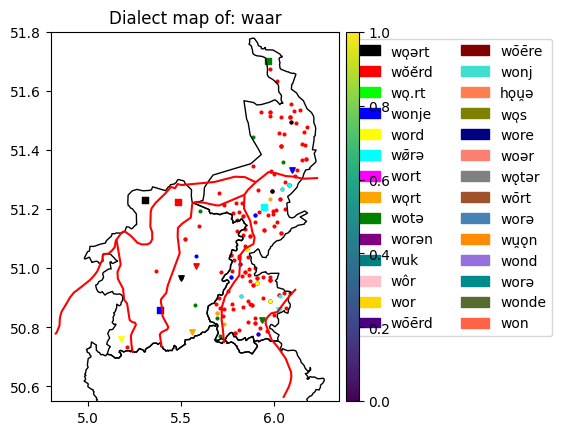

{('red', '.'): 'waar', ('green', '.'): 'woar', ('blue', '.'): 'wáár', ('cyan', '.'): 'wāār', ('orange', '.'): 'waor', ('black', '.'): 'wao', ('yellow', '.'): 'wààr', ('red', 'v'): 'naam', ('green', 'v'): 'aa', ('blue', 'v'): 'bewaard', ('cyan', 'v'): 'woa', ('orange', 'v'): 'woor', ('black', 'v'): 'wār', ('yellow', 'v'): 'waorxeven', ('red', 's'): 'wour', ('green', 's'): 'wor', ('blue', 's'): 'woùr', ('cyan', 's'): 'wââr', ('orange', 's'): 'wòr', ('black', 's'): 'wòuər'}


In [ ]:
DialectMap('waar', df)

<ipython-input-21-fa3fa0c15758>:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(longitude, latitude, color=colors_markers[i][0], s=12, marker=colors_markers[i][1], cmap='brg', label=sound)


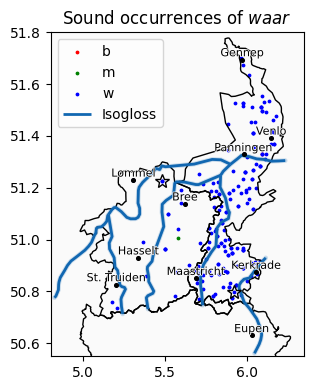

In [ ]:
DialectMapSounds('waar', df, ['b','m','w'], True, [5.9255403,50.7963578], [5.4835769,51.2251071])

In [ ]:
print(BeamSearch_normalization(transformer_normalization, ['kool'], [[0.19135108585711208,0.6714974639687558]], [[0.19135108585711208,0.6714974639687558]]))

NameError: name 'BeamSearch_normalization' is not defined

## Generate variation maps

In [ ]:
#find entries of a specific kloekecode
def findEntries(keyword, kloekecode, df):
  entries = df.loc[df['Kloekecode'] == kloekecode]
  idxs = []
  for word in entries['trefwoord'].to_numpy():
    if keyword in word:
      idxs.append(True)
    else:
      idxs.append(False)
  entries = entries[idxs]
  return(entries)

def findMatches(concept, df):
  idxs = []
  for word in df['trefwoord'].to_numpy():
    if word == concept:
      idxs.append(True)
    else:
      idxs.append(False)
  return(df[idxs])


#print(findEntries('wanneer', 'L360p', df_normalized))
print(findMatches('wie', df))

           index                              begrip trefwoord dialectopgave  \
110674      1104                 (met) stevige benen       wie           wie   
111110      1364  (persoon met) bleek, flets gezicht       wie          waai   
111114      1365  (persoon met) bleek, flets gezicht       wie           wij   
111118      1366  (persoon met) bleek, flets gezicht       wie          waai   
111123      1367  (persoon met) bleek, flets gezicht       wie            wi   
...          ...                                 ...       ...           ...   
1889965  1718889               zwak en mager persoon       wie           wie   
1889990  1718899              zwak en tenger persoon       wie          wiej   
1899988  1728034                              zweven       wie           wie   
1900491  1728527                           zwijmelen       wie            wi   
1901104  1729081                             zwoegen       wie           wie   

        Kloekecode                     

In [ ]:
#load grid for input to transformer
'''with open('/content/drive/MyDrive/Thesis/grid.pickle', 'rb') as handle:
    grid = pickle.load(handle)'''

#generate grid for input to transformer
granularity = 0.01

grid = []
count = 0
for y in np.arange(0, 1 + granularity, granularity):
  for x in np.arange(0, 1.05 + granularity, granularity):
    if (count % 20) == 0:
      print(count / (1/granularity)**2)
    count += 1
    #creates buffer zone around region to avoid extrapolating too far
    coords = normalized_to_coordinates(y, x)
    coords2 = geopandas.GeoSeries.from_xy([coords[1]], [coords[0]], crs="EPSG:4326").to_crs('EPSG:3035')[0]
    if True in region.to_crs('EPSG:3035').buffer(5000).to_crs('EPSG:3035').contains(coords2).to_list():
      grid.append((y,x))

0.0
0.002
0.004
0.006
0.008
0.01
0.012
0.014
0.016
0.018
0.02
0.022
0.024
0.026
0.028
0.03
0.032
0.034
0.036
0.038
0.04
0.042
0.044
0.046
0.048
0.05
0.052
0.054
0.056
0.058
0.06
0.062
0.064
0.066
0.068
0.07
0.072
0.074
0.076
0.078
0.08
0.082
0.084
0.086
0.088
0.09
0.092
0.094
0.096
0.098
0.1
0.102
0.104
0.106
0.108
0.11
0.112
0.114
0.116
0.118
0.12
0.122
0.124
0.126
0.128
0.13
0.132
0.134
0.136
0.138
0.14
0.142
0.144
0.146
0.148
0.15
0.152
0.154
0.156
0.158
0.16
0.162
0.164
0.166
0.168
0.17
0.172
0.174
0.176
0.178
0.18
0.182
0.184
0.186
0.188
0.19
0.192
0.194
0.196
0.198
0.2
0.202
0.204
0.206
0.208
0.21
0.212
0.214
0.216
0.218
0.22
0.222
0.224
0.226
0.228
0.23
0.232
0.234
0.236
0.238
0.24
0.242
0.244
0.246
0.248
0.25
0.252
0.254
0.256
0.258
0.26
0.262
0.264
0.266
0.268
0.27
0.272
0.274
0.276
0.278
0.28
0.282
0.284
0.286
0.288
0.29
0.292
0.294
0.296
0.298
0.3
0.302
0.304
0.306
0.308
0.31
0.312
0.314
0.316
0.318
0.32
0.322
0.324
0.326
0.328
0.33
0.332
0.334
0.336
0.338
0.34
0.342
0.344
0

In [ ]:
#perform translation on grid

#divide in batches to prevent GPU RAM overflow
def BeamSearchBatched(grid, word_origin, coords_origin, batch_size, likelihoods=False):
  gc.collect()
  batches = int(np.floor(len(grid) / batch_size))
  outputs = []
  for i in range(batches):
    if (i % 20) == 0:
      print(i/batches)
    idx_start = i*batch_size
    if i == batches-1:
      idx_end = len(grid)
    else:
      idx_end = (i+1)*batch_size
    if likelihoods == True:
      output = BeamSearchLikelihoods([word_origin]*len(grid[idx_start:idx_end]), [coords_origin]*len(grid[idx_start:idx_end]), grid[idx_start:idx_end]).tolist()
    else:
      output = BeamSearch([word_origin]*len(grid[idx_start:idx_end]), [coords_origin]*len(grid[idx_start:idx_end]), grid[idx_start:idx_end])
      output = [word[1:-1] for word in output]
    outputs = outputs + output
  return(outputs)

def TranslationGrid(word, coords_origin):
  #translate grid
  output_words = BeamSearchBatched(grid, word, coords_origin, 1024, False)
  #output_likelihoods = BeamSearchBatched(grid, word, coords_origin, 512, True)
  outputs = []
  for i in range(len(output_words)):
    #outputs.append([grid[i], output_words[i], output_likelihoods[i]])
    outputs.append([grid[i], output_words[i], np.nan])
  return(outputs)

#diest coordinates
lat = 51.139
lon = 5.5966
coords_bree = coordinates_to_normalized(lat, lon)

lat = 50.9797
lon = 5.0556
coords_diest = coordinates_to_normalized(lat, lon)

lat = 50.8188
lon = 5.1820
coords_sttruiden = coordinates_to_normalized(lat, lon)

lat = 50.8514
lon = 5.6910
coords_maastricht = coordinates_to_normalized(lat, lon)

lat = 50.9326
lon = 5.3426
coords_hasselt = coordinates_to_normalized(lat, lon)

lat = 51.1913
lon = 5.9878
coords_roermond = coordinates_to_normalized(lat, lon)

lat = 50.9662
lon = 5.5022
coords_genk = coordinates_to_normalized(lat, lon)

lat = 51.2510
lon = 5.5425
coords_achel = coordinates_to_normalized(lat, lon)

lat = 51.1544
lon = 5.5084
coords_brogel = coordinates_to_normalized(lat, lon)

lat = 50.867
lon = 6.069
coords_kerkrade = coordinates_to_normalized(lat, lon)


#outputs = TranslationGrid('šo.l', coords_maastricht)
outputs = TranslationGrid('wie', coords_bree)

0.0


In [ ]:
def MapVariation(fig, ax, coordinates, values, title, bar=False):
  coordinates = np.array(coordinates)
  latitudes, longitudes = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])

  sc = ax.scatter(longitudes, latitudes, c=values, s=1, cmap='brg')
  region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
  if bar == True:
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(sc, cax=cax)

  PlaceNames(fig, ax)

  #buffer is 1 km, which is approx. width of Uerdinger line as by Pauwels, 1935. This is only indicative of the margin of error of isoglosses. The Gete line is notably much broader
  isoglosses2_merged.to_crs('EPSG:3035').buffer(1000).to_crs('EPSG:4326').plot(ax=ax, color='#00001a', alpha=0.2, zorder=1)
  #isoglosses2.to_crs('EPSG:3035').buffer(900).to_crs('EPSG:4326').plot(ax=ax, color='#8d021f', alpha=0.2, zorder=1)
  isoglosses2_merged.to_crs('EPSG:3035').buffer(500).to_crs('EPSG:4326').plot(ax=ax, color='#00001a', alpha=0.2, zorder=1)
  isoglosses2_merged.plot(ax=ax, color = '#00001a', alpha=1, linewidth=2, label='Isogloss', zorder=1)
  ax.set_title(title)
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)

<ipython-input-86-b5eae5d8ed6b>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(longitudes, latitudes, c=values, s=1, cmap='brg')


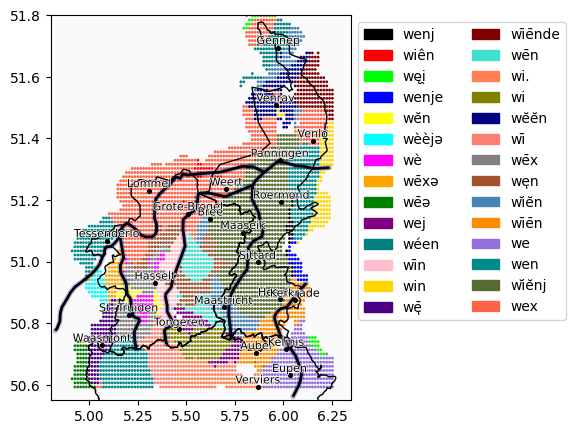

In [ ]:
#plot variation map
colors = ['black', 'red', 'lime', 'blue', 'yellow', 'cyan', 'magenta',
        'orange', 'green', 'purple', 'teal', 'pink', 'gold', 'indigo', 'maroon',
        'turquoise', 'coral', 'olive', 'navy', 'salmon', 'gray', 'sienna',
        'steelblue', 'darkorange', 'mediumpurple', 'darkcyan',
        'darkolivegreen', 'tomato']

#group by translated word
df_grid = pd.DataFrame(outputs)
grid_grouped = df_grid.groupby([1], as_index=False).agg({0 : lambda x: list(x), 2 : lambda x: list(x)}).to_numpy()

#only most common word groups for simplicity (up until amount of colors, i.e. 30)
lengths = [len(row[1]) for row in grid_grouped]
sorted_idxs = np.argsort(lengths)
grid_grouped = grid_grouped[sorted_idxs][-len(colors):]

legend = {}
coordinates = []
words = []
color_words = []

for i, row in enumerate(grid_grouped):
  coordinates = coordinates + row[1]
  legend[colors[i]] = row[0]
  color_words = color_words + [colors[i]]*len(row[2])

fig, ax = plt.subplots(figsize=(6.3,5))
MapVariation(fig, ax, coordinates, color_words, '', bar=False)
plt.subplots_adjust(wspace=1)

#create legend
legend_entries = []
for color in legend:
  entry = mpatches.Patch(color=color, label=legend[color])
  legend_entries.append(entry)
ax.legend(handles=legend_entries, ncols=2, bbox_to_anchor=(1, 1), loc='upper left')

#plt.tight_layout()
#plt.savefig('Variation6.png', dpi=1200, bbox_inches='tight')
plt.show()

# **Dialect identification: traditional deep learning**

## **Input encoding**

## Split in training, validation and test data

In [ ]:
X = df_normalized['dialectopgave'].values

y_coords = df_normalized['y'].values
x_coords = df_normalized['x'].values
Y = np.array(list(zip(y_coords, x_coords)))

length_10_mask = [True if len(word) <= 10 else False for word in X]
X = X[length_10_mask]
Y = Y[(length_10_mask)]

X_train, X_remainder, y_train, y_remainder = train_test_split(np.array(X), np.array(Y), test_size=0.2, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(np.array(X_remainder), np.array(y_remainder), test_size=0.5, shuffle=True)

## One-hot encoding

In [ ]:
#performs one hot encoding
vocab = ['-', '.', ':', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¯', 'à', 'á', 'â', 'ä',
              'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ù', 'ú', 'û', 'ü',
              'ā', 'ē', 'ę', 'ī', 'ŋ', 'ō', 'ő', 'š', 'ū', 'ű', 'ž', 'ǝ', 'ǫ', 'ǭ', 'ȳ', 'ə', 'ɛ', 'ʔ',
              '˙', '˱', '˲', '̃', '̄', '̆', '̇', '̋', '̌', '̜', '̝', '̞', '̣', '̥', '̯', '͂', 'ͅ', 'ẽ', '‧', '□', '$']

char_to_idx = {char: idx for idx, char in enumerate(vocab)}

def encode_one_hot(encoded_words):
    num_chars = len(vocab)
    one_hot = tf.one_hot(encoded_words, num_chars)
    return(one_hot)

#embed training, validation and test set

encoded_words = []
for i, word in enumerate(X_train):
  #output = np.array(string_to_one_hot(word, vocab))
  encoded_word = [char_to_idx[char] for char in word]
  encoded_word = encoded_word + [0]*(10-len(encoded_word))
  #encoded_word = np.pad(output, [(0, 10 - len(encoded_word)), (0, 0)], 'constant')
  encoded_words.append(encoded_word)
  #X_new.append(X[i])
X_train_embedded_LSTM = encode_one_hot(encoded_words)
X_train_embedded = tf.reshape(X_train_embedded_LSTM, (X_train_embedded_LSTM.shape[0], 920)) #flatten for use in e.g. feedforward neural net

encoded_words = []
for i, word in enumerate(X_val):
  #output = np.array(string_to_one_hot(word, vocab))
  encoded_word = [char_to_idx[char] for char in word]
  encoded_word = encoded_word + [0]*(10-len(encoded_word))
  #encoded_word = np.pad(output, [(0, 10 - len(encoded_word)), (0, 0)], 'constant')
  encoded_words.append(encoded_word)
  #X_new.append(X[i])
X_val_embedded_LSTM = encode_one_hot(encoded_words)
X_val_embedded = tf.reshape(X_val_embedded_LSTM, (X_val_embedded_LSTM.shape[0], 920)) #flatten for use in e.g. feedforward neural net

encoded_words = []
for i, word in enumerate(X_test):
  #output = np.array(string_to_one_hot(word, vocab))
  encoded_word = [char_to_idx[char] for char in word]
  encoded_word = encoded_word + [0]*(10-len(encoded_word))
  #encoded_word = np.pad(output, [(0, 10 - len(encoded_word)), (0, 0)], 'constant')
  encoded_words.append(encoded_word)
  #X_new.append(X[i])
X_test_embedded_LSTM = encode_one_hot(encoded_words)
X_test_embedded = tf.reshape(X_test_embedded_LSTM, (X_test_embedded_LSTM.shape[0], 920)) #flatten for use in e.g. feedforward neural net

## Implementations

In [ ]:
#input dimension for one-hot encoded embedding
input_dimension = len(X_train_embedded[0])
print(input_dimension)

### **Implementation 7:**
bi-directional LSTM + feedforward NN, max. 10 characters, padded, no regularization

In [ ]:
#optional garbage collection during training callback
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

callback = GarbageCollectorCallback()

In [ ]:
#%%script false --no-raise-error
#single implementation (no early stopping)

# define the model
model = Sequential()
model.add(Bidirectional(LSTM(300, return_sequences=True), merge_mode='concat'))
model.add(Bidirectional(LSTM(300, return_sequences=True), merge_mode='concat'))
model.add(Bidirectional(LSTM(300, return_sequences=True), merge_mode='concat'))
model.add(Flatten()) #flatten before feedforward part
model.add(Dense(500, activation='relu'))
model.add(Dense(2, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model.fit(X_train_embedded_LSTM, y_train, validation_data=(X_val_embedded_LSTM, y_val), epochs=50, batch_size=160, verbose=2, callbacks=[callback])

In [ ]:
y_hat = model.predict(X_test_embedded_LSTM)

In [ ]:
model.evaluate(x=X_test_embedded_LSTM, y=y_test)

In [ ]:
model.summary()

#**Save/load weights**

In [ ]:
transformer.save_weights('/content/drive/MyDrive/Thesis/checkpoints/GeographicTransformerTranslationFinal2')

In [ ]:
transformer.load_weights('/content/drive/MyDrive/Thesis/checkpoints/GeographicTransformerTranslationFinal')

# VarDial 2024 plots


ValueError: RGBA sequence should have length 3 or 4

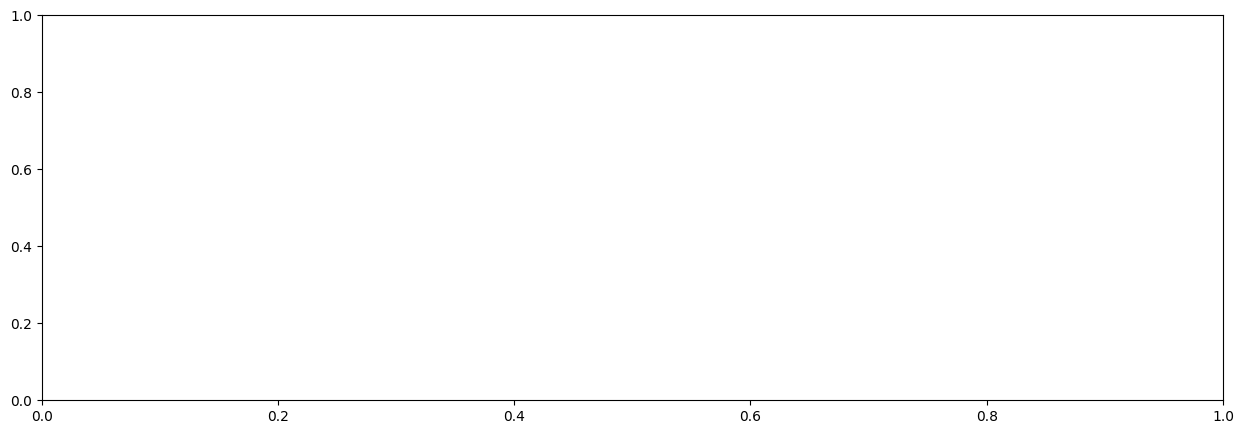

In [ ]:
#2D frequency histogram of WLD

fig, ax = plt.subplots(figsize=(6.3, 5))
plt.subplots_adjust(right=2)
factor = 0.3

legend_entries = []
for color in legend:
  entry = mpatches.Patch(color=color, label=legend[color])
  legend_entries.append(entry)
ax.legend(handles=legend_entries, ncols=2, bbox_to_anchor=(1, 1), loc='upper left')

coordinates = np.array(list(zip(WLD_grouped['y'].values, WLD_grouped['x'].values)))
latitudes, longitudes = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])

hist = ax.hist2d(longitudes, latitudes, bins=15, weights=WLD_grouped['index'].values, cmap='hot_r', alpha=0.8)

region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(hist[3], cax=cax)

places = [('Hasselt', 50.9303735, 5.3378043), ('Maastricht', 50.8512438, 5.6909768), ('Venlo', 51.39244885, 6.1511724144122955),
          ('Lommel', 51.2305657, 5.3076895),('Gennep', 51.6950839, 5.9734549)]

for i in range(len(places)):
  ax.scatter(places[i][2], places[i][1], s=9, color='black', zorder=5)
  ax.annotate(places[i][0], (places[i][2], places[i][1] + 0.005), size=11, ha='center', va='bottom', path_effects=[pe.withStroke(linewidth=2, foreground="white")], zorder=5)
ax.set_facecolor('#FAFAFA')

ax.annotate("$\it{Limburg \ (BE)}$", (5.45, 51.04), size=9, color='blue', ha='center', va='bottom', path_effects=[pe.withStroke(linewidth=2, foreground="white")], zorder=5)
ax.annotate("$\it{Limburg \ (NL)}$", (5.86, 51.23), size=9, color='blue', ha='center', va='bottom', path_effects=[pe.withStroke(linewidth=2, foreground="white")], zorder=5)
ax.annotate("$\it{Liège \ (BE)}$", (5.6, 50.6), size=9, color='blue', ha='center', va='bottom', path_effects=[pe.withStroke(linewidth=2, foreground="white")], zorder=5)


plt.savefig('FrequencyHistogram.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
def MapVariation(fig, ax, coordinates, values, title, bar=False):
  coordinates = np.array(coordinates)
  latitudes, longitudes = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])

  sc = ax.scatter(longitudes, latitudes, c=values, s=1, cmap='brg')
  region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
  if bar == True:
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(sc, cax=cax)

  PlaceNames(fig, ax)

  #buffer is 1 km, which is approx. width of Uerdinger line as by Pauwels, 1935. This is only indicative of the margin of error of isoglosses. The Gete line is notably much broader
  isoglosses2_merged.to_crs('EPSG:3035').buffer(1000).to_crs('EPSG:4326').plot(ax=ax, color='#00001a', alpha=0.2, zorder=1)
  #isoglosses2.to_crs('EPSG:3035').buffer(900).to_crs('EPSG:4326').plot(ax=ax, color='#8d021f', alpha=0.2, zorder=1)
  isoglosses2_merged.to_crs('EPSG:3035').buffer(500).to_crs('EPSG:4326').plot(ax=ax, color='#00001a', alpha=0.2, zorder=1)
  isoglosses2_merged.plot(ax=ax, color = '#00001a', alpha=1, linewidth=2, label='Isogloss', zorder=1)
  ax.set_title(title)
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)

<ipython-input-207-295609edaf77>:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(longitudes, latitudes, c=color_words, s=1, cmap='brg')


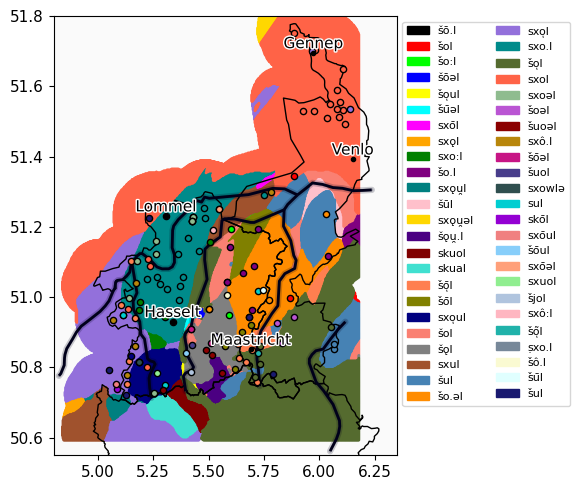

{'black': 'šō.l', 'red': 'šol', 'lime': 'šo:l', 'blue': 'šōǝl', 'yellow': 'šoͅul', 'cyan': 'šūəl', 'magenta': 'sxōl', 'orange': 'sxǫl', 'green': 'sxo:l', 'purple': 'šo.l', 'teal': 'sxǫu̯l', 'pink': 'šūl', 'gold': 'sxǫu̯ǝl', 'indigo': 'šǫu̯.l', 'maroon': 'skuol', 'turquoise': 'skual', 'coral': 'šōͅl', 'olive': 'šōl', 'navy': 'sxoͅul', 'salmon': 'šol', 'gray': 'šǫl', 'sienna': 'sxul', 'steelblue': 'šul', 'darkorange': 'šo.əl', 'mediumpurple': 'sxoͅl', 'darkcyan': 'sxo.l', 'darkolivegreen': 'šoͅl', 'tomato': 'sxol', 'darkseagreen': 'sxoəl', 'mediumorchid': 'šoəl', 'darkred': 'šuoəl', 'darkgoldenrod': 'sxô.l', 'mediumvioletred': 'šōəl', 'darkslateblue': 'šuol', 'darkslategray': 'sxowlə', 'darkturquoise': 'sul', 'darkviolet': 'skōl', 'lightcoral': 'sxōul', 'lightskyblue': 'šōul', 'lightsalmon': 'sxōəl', 'lightgreen': 'sxuol', 'lightsteelblue': 'šjol', 'lightpink': 'sxô:l', 'lightseagreen': 'šo͂ͅl', 'lightslategray': 'ṣxo.l', 'lightgoldenrodyellow': 'šô.l', 'lightc

In [ ]:
#check code in cell below for fixed legend, this is dynamically generated legend

#variation map: from model
#plot variation map

#colors for the variation plot of WLD + model
colors = ['black', 'red', 'lime', 'blue', 'yellow', 'cyan', 'magenta',
        'orange', 'green', 'purple', 'teal', 'pink', 'gold', 'indigo', 'maroon',
        'turquoise', 'coral', 'olive', 'navy', 'salmon', 'gray', 'sienna',
        'steelblue', 'darkorange', 'mediumpurple', 'darkcyan',
        'darkolivegreen', 'tomato']

#colors for all extra words that are in WLD but not in model
supplement_colors = ['slategray', 'darkseagreen', 'mediumorchid', 'darkred', 'darkgoldenrod',
                     'mediumvioletred', 'darkslateblue', 'darkslategray', 'darkturquoise',
                     'darkviolet', 'lightcoral', 'lightskyblue', 'lightsalmon', 'lightgreen',
                     'lightsteelblue', 'lightpink', 'lightseagreen', 'lightslategray',
                     'lightgoldenrodyellow', 'lightcyan', 'MidnightBlue']

#group by translated word
df_grid = pd.DataFrame(outputs)
grid_grouped = df_grid.groupby([1], as_index=False).agg({0 : lambda x: list(x), 2 : lambda x: list(x)}).to_numpy()

#only most common word groups for simplicity (up until amount of colors, i.e. 30)
lengths = [len(row[1]) for row in grid_grouped]
sorted_idxs = np.argsort(lengths)
grid_grouped = grid_grouped[sorted_idxs][-len(colors):]

#make legend using colors from above
legend = {}
coordinates = []
words = []
color_words = []

for i, row in enumerate(grid_grouped):
  coordinates = coordinates + row[1]
  legend[colors[i]] = row[0]
  color_words = color_words + [colors[i]]*len(row[2])

fig, ax = plt.subplots(figsize=(6.3, 5))

coordinates = np.array(coordinates)
latitudes, longitudes = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])

sc = ax.scatter(longitudes, latitudes, c=color_words, s=1, cmap='brg')
region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)

ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)

places = [('Hasselt', 50.9303735, 5.3378043), ('Maastricht', 50.8512438, 5.6909768), ('Venlo', 51.39244885, 6.1511724144122955),
          ('Lommel', 51.2305657, 5.3076895),('Gennep', 51.6950839, 5.9734549)]
for i in range(len(places)):
  ax.scatter(places[i][2], places[i][1], s=9, color='black', zorder=2)
  ax.annotate(places[i][0], (places[i][2], places[i][1] + 0.005), size=11, ha='center', va='bottom', path_effects=[pe.withStroke(linewidth=2, foreground="white")], zorder=2)

ax.set_facecolor('#FAFAFA')

#buffer is 1 km, which is approx. width of Uerdinger line as by Pauwels, 1935. This is only indicative of the margin of error of isoglosses. The Gete line is notably much broader
isoglosses2_merged.to_crs('EPSG:3035').buffer(1000).to_crs('EPSG:4326').plot(ax=ax, color='#00001a', alpha=0.2, zorder=1)
#isoglosses2.to_crs('EPSG:3035').buffer(900).to_crs('EPSG:4326').plot(ax=ax, color='#8d021f', alpha=0.2, zorder=1)
isoglosses2_merged.to_crs('EPSG:3035').buffer(500).to_crs('EPSG:4326').plot(ax=ax, color='#00001a', alpha=0.2, zorder=1)
isoglosses2_merged.plot(ax=ax, color = '#00001a', alpha=1, linewidth=2, label='Isogloss', zorder=1)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

plt.subplots_adjust(wspace=1)

#ax.legend(handles=legend_entries, ncols=2, loc='upper left', prop={'size': 6})

#variation map: in WLD
#################################################################################

#gets the model's generated color scheme
word_color_matches = {}
for i in range(len(grid_grouped[:,0])):
  word_color_matches[grid_grouped[i,0]] = colors[i]

keyword = "school"

entries = df_normalized.loc[df['trefwoord'] == keyword]
entries_grouped = entries.groupby(['dialectopgave'], as_index=False).agg({'y' : lambda x: list(x), 'x' : lambda x: list(x)})
entries_grouped = entries_grouped.sort_values(by='y', key=lambda x: x.str.len(), ascending=False).to_numpy()

#list of words that aren't featured in the generated map, only display ones that are featured at least twice
remaining_words = ['skōl', 'sul', 'sxowlə', 'sxoəl', 'sxōul', 'sxōəl', 'sxuol', 'sxô.l', 'sxô:l', 'šjol', 'šoəl', 'šōul', 'šōəl', 'šo͂ͅl', 'šul', 'šuol', 'šuoəl', 'šūl', 'šô.l', 'ṣxo.l']
#list to keep track of first used instance of a word
featured_words = []

#fig, ax = plt.subplots()
for i, row in enumerate(entries_grouped):
  try: #checks if color matches the legend of the model variation map
    color = word_color_matches[row[0]]
    legend[color] = row[0]
  except: #otherwise uses the supplementary list
    if row[0] not in featured_words and row[0] in remaining_words:
      featured_words.append(row[0])
      color = supplement_colors[len(featured_words)]
      legend[color] = row[0]
  coordinates = np.transpose(np.array([row[1], row[2]]))
  latitude, longitude = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])

  sc = ax.scatter(longitude, latitude, color=color, edgecolors='black', linewidth=1, s=20, label=row[0], zorder=1)

legend_entries = []
for color in legend:
  entry = mpatches.Patch(color=color, label=legend[color])
  legend_entries.append(entry)

ax.legend(handles=legend_entries, ncols=2, bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 8})

plt.tight_layout()
#plt.savefig('Variation6.png', dpi=1200, bbox_inches='tight')
plt.show()
print(legend)

In [ ]:
color_dict = {
#red
    'sxo.l': (1.0, 0.0, 0.0),         # Red
    'sxo:l': (1.0, 0.2, 0.2),         # Light Red
    'sxol': (0.8, 0.0, 0.0),          # Dark Red
    'sxōl': (1.0, 0.4, 0.4),         # Rosy Red
    'sxoͅl': (1.0, 0.6, 0.6),         # Pinkish Red
    'sxǫl': (0.6, 0.0, 0.0),          # Deep Red
    'sxowlə': (0.8, 0.2, 0.2),        # Maroon
    'sxô.l': (0.8, 0.0, 0.2),         # Crimson
    'sxô:l': (1.0, 0.0, 0.4),         # Bright Red
    'ṣxo.l': (0.6, 0.2, 0.2),         # Burgundy

#magenta
    'sxoəl': (1.0, 0.0, 1.0),         # Magenta
    'sxōəl': (1.0, 0.2, 1.0),         # Light Magenta
    'sxul': (0.8, 0.0, 0.8),          # Dark Magenta

#blue-violet
    'sxōul': (0.6, 0.2, 1.0),         # Violet
    'sxoͅul': (0.8, 0.4, 1.0),         # Lavender
    'sxuol': (0.4, 0.0, 0.8),          # Deep Violet
    'sxǫu̯l': (0.6, 0.4, 1.0),         # Indigo
    'sxǫu̯ǝl': (0.8, 0.6, 1.0),        # Light Indigo

#indigo-cyan
'šo.l': (0.0, 0.2, 0.4),
 'šol': (0.0, 0.30196078431372547, 0.5019607843137255),
 'šōͅl': (0.0, 0.4, 0.6),
 'šo͂ͅl': (0.0, 0.5019607843137255, 0.7019607843137254),
 'šoͅl': (0.0, 0.6, 0.8),
'šô.l': (0.0, 0.6980392156862745, 0.8980392156862745),
'šo:l': (0.0, 0.8, 1.0),
'šōl': (0.0, 0.9019607843137255, 1.0),
'šō.l': (0.0, 1.0, 1.0),
'šǫl': (0.2, 1.0, 1.0),

#green
    'šǫu̯.l': (0.0, 0.502, 0.0),      # Green
    'šoͅul': (0.4, 0.8, 0.0),        # Lime Green
    'šōul': (0.2, 1.0, 0.2),         # Light Green
    'šūəl': (0.0, 0.8, 0.0),         # Medium Green
    'šuol': (0.0, 0.6, 0.0),          # Dark Green
    'šuoəl': (0.2, 0.8, 0.2),        # Emerald Green

#yellow
    'šo.əl': (1.0, 1.0, 0.0),         # Yellow
    'šoəl': (1.0, 1.0, 0.4),          # Light Yellow
    'šūl': (0.8, 0.8, 0.0),           # Dark Yellow
    'šōǝl': (1.0, 1.0, 0.2),          # Bright Yellow
    'šul': (0.8, 0.8, 0.2),           # Olive Yellow
    'šūl': (1.0, 1.0, 0.6),           # Pale Yellow
    'šōəl': (0.8, 0.8, 0.4),          # Mustard Yellow

#orange
    'skōl': 'saddlebrown',        # Orange
    'skual': 'chocolate',          # Light Orange
    'skuol': 'sandybrown',        # Dark Orange
}

<ipython-input-323-c4c353c78427>:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(longitudes, latitudes, c=color_words, s=1, cmap='brg')


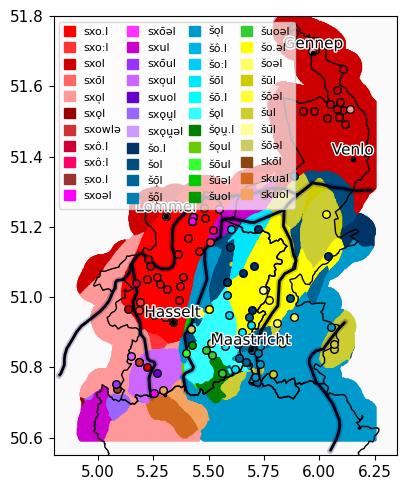

In [ ]:
#same graph as above but with fixed legend

#variation map: from model

#colors for the variation plot of WLD + model
colors = ['black', 'red', 'lime', 'blue', 'yellow', 'cyan', 'magenta',
        'orange', 'green', 'purple', 'teal', 'pink', 'gold', 'indigo', 'maroon',
        'turquoise', 'coral', 'olive', 'navy', 'salmon', 'gray', 'sienna',
        'steelblue', 'darkorange', 'mediumpurple', 'darkcyan',
        'darkolivegreen', 'tomato']

#colors for all extra words that are in WLD but not in model
supplement_colors = ['slategray', 'darkseagreen', 'mediumorchid', 'darkred', 'darkgoldenrod',
                     'mediumvioletred', 'darkslateblue', 'darkslategray', 'darkturquoise',
                     'darkviolet', 'lightcoral', 'lightskyblue', 'lightsalmon', 'lightgreen',
                     'lightsteelblue', 'lightpink', 'lightseagreen', 'lightslategray',
                     'lightgoldenrodyellow', 'lightcyan', 'MidnightBlue']

#group by translated word
df_grid = pd.DataFrame(outputs)
grid_grouped = df_grid.groupby([1], as_index=False).agg({0 : lambda x: list(x), 2 : lambda x: list(x)}).to_numpy()
#only most common word groups for simplicity (up until amount of colors, i.e. 30)
lengths = [len(row[1]) for row in grid_grouped]
sorted_idxs = np.argsort(lengths)
grid_grouped = grid_grouped[sorted_idxs][-len(colors):]

#make legend using colors from above
coordinates = []
color_words = []

for i, row in enumerate(grid_grouped):
  if row[0] == 'sul':
    continue
  coordinates = coordinates + row[1]
  temp_word = row[0]
  temp_word = row[0]
  temp_word = temp_word.replace('š', 'š')
  temp_word = temp_word.replace('š', 'š')
  temp_word = temp_word.replace('š', 'š')
  temp_word = temp_word.replace('š', 'š')
  color_words = color_words + [color_dict[temp_word]]*len(row[2])

fig, ax = plt.subplots(figsize=(6.3,5))

coordinates = np.array(coordinates)
latitudes, longitudes = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])

sc = ax.scatter(longitudes, latitudes, c=color_words, s=1, cmap='brg')
region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)

ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)

places = [('Hasselt', 50.9303735, 5.3378043), ('Maastricht', 50.8512438, 5.6909768), ('Venlo', 51.39244885, 6.1511724144122955),
          ('Lommel', 51.2305657, 5.3076895),('Gennep', 51.6950839, 5.9734549)]
for i in range(len(places)):
  ax.scatter(places[i][2], places[i][1], s=9, color='black', zorder=2)
  ax.annotate(places[i][0], (places[i][2], places[i][1] + 0.005), size=11, ha='center', va='bottom', path_effects=[pe.withStroke(linewidth=2, foreground="white")], zorder=2)

ax.set_facecolor('#FAFAFA')

#buffer is 1 km, which is approx. width of Uerdinger line as by Pauwels, 1935. This is only indicative of the margin of error of isoglosses. The Gete line is notably much broader
isoglosses2_merged.to_crs('EPSG:3035').buffer(1000).to_crs('EPSG:4326').plot(ax=ax, color='#00001a', alpha=0.2, zorder=1)
#isoglosses2.to_crs('EPSG:3035').buffer(900).to_crs('EPSG:4326').plot(ax=ax, color='#8d021f', alpha=0.2, zorder=1)
isoglosses2_merged.to_crs('EPSG:3035').buffer(500).to_crs('EPSG:4326').plot(ax=ax, color='#00001a', alpha=0.2, zorder=1)
isoglosses2_merged.plot(ax=ax, color = '#00001a', alpha=1, linewidth=2, label='Isogloss', zorder=1)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

plt.subplots_adjust(wspace=1)

#ax.legend(handles=legend_entries, ncols=2, loc='upper left', prop={'size': 6})

#variation map: in WLD
#################################################################################

#gets the model's generated color scheme
word_color_matches = {}
for i in range(len(grid_grouped[:,0])):
  word_color_matches[grid_grouped[i,0]] = colors[i]

keyword = "school"

entries = df_normalized.loc[df['trefwoord'] == keyword]
entries_grouped = entries.groupby(['dialectopgave'], as_index=False).agg({'y' : lambda x: list(x), 'x' : lambda x: list(x)})
entries_grouped = entries_grouped.sort_values(by='y', key=lambda x: x.str.len(), ascending=False).to_numpy()

legend = {}

#fig, ax = plt.subplots()
for i, row in enumerate(entries_grouped):
  if row[0] == 'sul':
    continue
  try:
    temp_word = row[0]
    temp_word = temp_word.replace('š', 'š')
    temp_word = temp_word.replace('š', 'š')
    temp_word = temp_word.replace('š', 'š')
    temp_word = temp_word.replace('š', 'š')
    color = color_dict[temp_word]
  except:
    continue
  coordinates = np.transpose(np.array([row[1], row[2]]))
  latitude, longitude = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])

  sc = ax.scatter(longitude, latitude, color=color, edgecolors='black', linewidth=1, s=30, label=temp_word, zorder=1)

legend_entries = []
for word in color_dict.keys():
  entry = mpatches.Patch(color=color_dict[word], label=word)
  legend_entries.append(entry)

ax.legend(handles=legend_entries, ncols=4, loc='upper left', prop={'size': 8}, handlelength=1, handleheight=1, framealpha=0.7, columnspacing=0.5)

plt.tight_layout()
plt.savefig('VariationMap.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
colors = {
    'šo.l': (0, 51, 102),    # Dark Azure
    'šol': (0, 77, 128),     # Azure
    'šōͅl': (0, 102, 153),   # Rich Azure
    'šo͂ͅl': (0, 128, 179),   # Deep Azure
    'šoͅl': (0, 153, 204),   # Strong Azure
    'šô.l': (0, 178, 229),   # Azure Mist
    'šo:l': (0, 204, 255),   # Sky Azure
    'šōl': (0, 230, 255),   # Light Azure
    'šō.l': (0, 255, 255),   # Cyan
    'šǫl': (51, 255, 255)   # Electric Cyan
}

In [ ]:
colors2 = {}
for key in colors.keys():
  colors2[key] = tuple([i/255 for i in colors[key]])
print(colors2)

{'šo.l': (0.0, 0.2, 0.4), 'šol': (0.0, 0.30196078431372547, 0.5019607843137255), 'šōͅl': (0.0, 0.4, 0.6), 'šo͂ͅl': (0.0, 0.5019607843137255, 0.7019607843137254), 'šoͅl': (0.0, 0.6, 0.8), 'šô.l': (0.0, 0.6980392156862745, 0.8980392156862745), 'šo:l': (0.0, 0.8, 1.0), 'šōl': (0.0, 0.9019607843137255, 1.0), 'šō.l': (0.0, 1.0, 1.0), 'šǫl': (0.2, 1.0, 1.0)}


In [ ]:
#variation map: in WLD
#plot ordinary dialect map

keyword = "school"

entries = df_normalized.loc[df['trefwoord'] == keyword]
entries_grouped = entries.groupby(['dialectopgave'], as_index=False).agg({'y' : lambda x: list(x), 'x' : lambda x: list(x)})
entries_grouped = entries_grouped.sort_values(by='y', key=lambda x: x.str.len(), ascending=False).to_numpy()

legend = {}

#list of words that aren't featured in the generated map, only display ones that are featured at least twice
remaining_words = ['skōl', 'sul', 'sxowlə', 'sxoəl', 'sxōul', 'sxōəl', 'sxuol', 'sxô.l', 'sxô:l', 'šjol', 'šoəl', 'šōul', 'šōəl', 'šo͂ͅl', 'šul', 'šuol', 'šuoəl', 'šūl', 'šô.l', 'ṣxo.l']
#list to keep track of first used instance of a word
featured_words = []

#fig, ax = plt.subplots()
for i, row in enumerate(entries_grouped):
  try: #checks if color matches the legend of the model variation map
    color = word_color_matches[row[0]]
    legend[color] = row[0]
  except: #otherwise uses the supplementary list
    if row[0] not in featured_words and row[0] in remaining_words:
      featured_words.append(row[0])
      legend[supplement_colors[len(featured_words)]] = row[0]
  coordinates = np.transpose(np.array([row[1], row[2]]))
  latitude, longitude = normalized_to_coordinates(coordinates[:,0], coordinates[:,1])

  sc = ax.scatter(longitude, latitude, color=color, s=15, cmap='brg', label=row[0])

isoglosses2.plot(ax=ax, color = 'red')
region.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=1)
ax.set_title('Dialect map of: ' + keyword)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(sc, cax=cax)
ax.legend(handles=legend_entries, ncols=2, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()
print(legend)

<ipython-input-127-723f8a159c2d>:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(longitude, latitude, color=color, s=15, cmap='brg', label=row[0])


<Figure size 640x480 with 0 Axes>

{'tomato': 'sxol', 'darkcyan': 'sxo.l', 'olive': 'šōl', 'purple': 'šo.l', 'coral': 'šōͅl', 'darkseagreen': 'sxoəl', 'darkolivegreen': 'šoͅl', 'mediumorchid': 'šoəl', 'green': 'sxo:l', 'darkorange': 'šo.əl', 'darkred': 'šuoəl', 'mediumpurple': 'sxoͅl', 'darkgoldenrod': 'sxô.l', 'mediumvioletred': 'šōəl', 'lime': 'šo:l', 'steelblue': 'šul', 'red': 'šol', 'darkslateblue': 'šuol', 'magenta': 'sxōl', 'darkslategray': 'sxowlə', 'darkturquoise': 'sul', 'darkviolet': 'skōl', 'maroon': 'skuol', 'lightcoral': 'sxōul', 'navy': 'sxoͅul', 'lightskyblue': 'šōul', 'lightsalmon': 'sxōəl', 'lightgreen': 'sxuol', 'lightsteelblue': 'šjol', 'lightpink': 'sxô:l', 'lightseagreen': 'šo͂ͅl', 'lightslategray': 'ṣxo.l', 'lightgoldenrodyellow': 'šô.l', 'lightcyan': 'šūl', 'MidnightBlue': 'šul'}
